#Analyzing Harvard Q Guide Data

# Table of Contents
* [Analyzing Harvard Q Guide Data](#Analyzing-Harvard-Q-Guide-Data)
* [Preloading](#Preloading)
* [Perspectives](#Perspectives)
    * [Perspective Bar Graphs](#Perspective-Bar-Graphs)
    * [Overall Stats](#Overall-Stats)
* [Categories](#Categories)
* [Histograms](#Histograms)
* [Enrollment](#Enrollment)
    * [Enrollment Chart](#Enrollment-Chart)
* [Workload](#Workload)
    * [Category Workloads](#Category-Workloads)
* [Sorting](#Sorting)
    * [Customizable Sorting (Search based on Workload, Section, Overall, etc.)](#Customizable-Sorting)


### Preloading

Loads in required packages and imports the CSVs

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import IPython
import csv
import time
import matplotlib
#matplotlib.use('TkAgg')
#matplotlib.style.use('ggplot')
from IPython.display import display, HTML
%matplotlib inline
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def readAndProcessCSV(datcsv):
    df = pd.read_csv(datcsv)
    df = df.replace({'False': np.nan}, regex=True) #because I when extracting
    df = df.replace({'FALSE': np.nan}, regex=True)
    df[['Std Workload Q']] = df[['Std Workload Q']].astype(float) #because dumb autoconversion fail
    return df
def getIntIfPossible(value):
    try:
        junk = int(value)
        return junk
    except ValueError:
        return False
    except TypeError: #usually None
        return False

In [110]:
df = readAndProcessCSV('allyears.csv')
lastspringdf = readAndProcessCSV('Std Post Spring Term 2015.csv')
lastfalldf = readAndProcessCSV('Std Post Fall Term 2014.csv')
bothdf = lastfalldf.append(lastspringdf)

In [4]:
assert len(df) > 18000
df.columns

Index([u'Unnamed: 0', u'Course Category', u'Course Number', u'Course Title', u'Overall Q', u'Workload Q', u'Std Workload Q', u'Would Recommend Q', u'Enrollment', u'Evaluations', u'Response Rate', u'Materials Q', u'Assignments Q', u'Feedback Q', u'Section Q', u'Elective Reason', u'Concentration Req Reason', u'Secondary Field or Language Req Reason', u'Undeergrad Core or Gen Ed Req Reason', u'Expos Req Reason', u'Foreign Lang Req Reason', u'Pre-Med Req Reason', u'Year', u'Term'], dtype='object')

## Perspectives

Get student and dean perspectives on classes. All Courses and Category Mean Ratings for Overall, Std Workload, Recommend, and Enrollment.

In [5]:
def getBetterPerspective(df):
    
    index = ['Overall', 'Std Workload', 'Recommend', 'Enrollment']
    columns = ['Mean', 'Median']
    
    ovr = [df['Overall Q'].mean(), df['Overall Q'].median()]
    wrk = [df['Std Workload Q'].mean(), df['Std Workload Q'].median()]
    rec = [df['Would Recommend Q'].mean(), df['Would Recommend Q'].median()]
    enr = [df['Enrollment'].mean(), df['Enrollment'].median()]
    
    dean = pd.DataFrame([ovr,wrk,rec,enr], index=index, columns=columns)
    
    studentover = []
    studentwork = []
    studentrecc = []
    studentenroll = []

    for _, course in df.iterrows():
        evs = getIntIfPossible(course['Evaluations'])
        if not evs:
            continue
        studentover.extend([course['Overall Q']] * evs)
        studentwork.extend([course['Std Workload Q']] * evs)
        studentrecc.extend([course['Would Recommend Q']] * evs)

        ens = getIntIfPossible(course['Enrollment'])
        if ens:
            studentenroll.extend([ens] * ens)
    so = pd.Series(studentover)
    sw = pd.Series(studentwork)
    sr = pd.Series(studentrecc)
    se = pd.Series(studentenroll)
    stud = pd.DataFrame([\
            [so.mean(), so.median()],\
            [sw.mean(), sw.median()],\
            [sr.mean(), sr.median()],\
            [se.mean(), se.median()]\
        ], index=index, columns=columns)
    return {'student': stud, 'dean': dean}

In [66]:
def getPerspective(df):
    print 'Dean\'s perspective'
    print 'Overall Mean/Median:'
    print df['Overall Q'].mean(), df['Overall Q'].median()
    print 'Std Workload Mean/Median/Max:'
    print df['Std Workload Q'].mean(), df['Std Workload Q'].median(), df['Std Workload Q'].max()
    print 'Recommend Mean/Median:'
    print df['Would Recommend Q'].mean(), df['Would Recommend Q'].median()
    print 'Enrollments Mean/Median/Max:'
    print df['Enrollment'].mean(), df['Enrollment'].median(), df['Enrollment'].max()
    print '\n'
    print 'Student\'s perspective'
    
    studentover = []
    studentwork = []
    studentrecc = []
    studentenroll = []

    for _, course in df.iterrows():
        evs = getIntIfPossible(course['Evaluations'])
        if not evs:
            continue
        studentover.extend([course['Overall Q']] * evs)
        studentwork.extend([course['Std Workload Q']] * evs)
        studentrecc.extend([course['Would Recommend Q']] * evs)

        ens = getIntIfPossible(course['Enrollment'])
        if ens:
            studentenroll.extend([ens] * ens)
    so = pd.Series(studentover)
    sw = pd.Series(studentwork)
    sr = pd.Series(studentrecc)
    se = pd.Series(studentenroll)
    print 'Overall Mean/Median:'
    print so.mean(), so.median()
    print 'Std Workload Mean/Median:'
    print sw.mean(), sw.median()
    print 'Recommend Mean/Median:'
    print sr.mean(), sr.median()
    print 'Enrollments Mean/Median:'
    print se.mean(), se.median()

def getCategories(df):
    return df['Course Category'].unique()

def getSortedCategories(df, floor=0):
    ab = df['Course Category'].value_counts()
    if floor:
        ab = ab[ab > floor]
    return ab.keys()
def getAllPerspectivesForDF(df, floor=200, decimalprecision=2, show=True):
    dacats = getSortedCategories(df,floor=floor)
    withall = dacats.insert(0, 'ALL')
    withall = withall.insert(1, 'GEN')
    allofit = getBetterPerspective(df)
    gened = ['GEN-ED', 'AESTHINT', 'CULTBLF', 'ETHRSON', 'SCILIVSY', 'SCIPHUNV', 'SOCWORLD', 'US-WORLD', 'EMREAS'] #HARDCODED
    genedper = getBetterPerspective(df[df['Course Category'].isin(gened)])
    
    allstuds = [allofit['student']['Mean'].round(decimals=decimalprecision),\
                genedper['student']['Mean'].round(decimals=decimalprecision)] # rounding to 2 decimals for readability
    alldeans = [allofit['dean']['Mean'].round(decimals=decimalprecision),\
                genedper['dean']['Mean'].round(decimals=decimalprecision)] # rounding to 2 decimals for readability
    
    for c in dacats:
        per = getBetterPerspective(df[df['Course Category'] == c])
        allstuds.append(per['student']['Mean'].round(decimals=decimalprecision)) # rounding to 2 decimals for readability
        alldeans.append(per['dean']['Mean'].round(decimals=decimalprecision)) # rounding to 2 decimals for readability

    st = pd.DataFrame(allstuds, index=withall)

    # see diffs from ALL
    stcopy = st.copy()
    for c in stcopy.columns:
        stcopy[c] = stcopy[c] - stcopy[c]['ALL']
        #stcopy[c + 'Mean Delta'] = stcopy[c] - stcopy[c]['ALL']
    if show:
        print 'Student perspective'
        display(st)
        display(stcopy)

    de = pd.DataFrame(alldeans, index=withall)
    decopy = de.copy()
    for c in decopy.columns:
        decopy[c] = decopy[c] - decopy[c]['ALL']
    if show:
        print 'Dean perspective'
        display(de)
        display(decopy)
    return {'student': st, 'dean': de, 'studentdiff': stcopy, 'deandiff': decopy}

In [7]:
getCategories(df)
gened = ['GEN-ED', 'AESTHINT', 'CULTBLF', 'ETHRSON', 'SCILIVSY', 'SCIPHUNV', 'SOCWORLD', 'US-WORLD', 'EMREAS']

In [8]:
# TABLES
print 'Fall 2006 to Spring 2015'
getAllPerspectivesForDF(df, floor=200, show=True)
print '\n'
print 'Fall 2014 to Spring 2015'
getAllPerspectivesForDF(bothdf, floor=50, show=True)

Fall 2006 to Spring 2015
Student perspective


Overall  Std Workload  Recommend  Enrollment
ALL          3.95          5.73       4.04      119.21
GEN          3.84          4.00       3.98      165.95
FRSEMR       4.25          3.02       4.31       11.68
HIST         4.16          6.16       4.19       41.61
ECON         3.65          5.88       3.80      224.22
GOV          4.00          5.70       4.08      101.11
ENGLISH      4.23          5.73       4.31       96.93
EXPOS        4.04          5.47       4.09       19.75
PSY          4.11          4.12       4.23      115.24
MATH         3.98          8.45       3.98       37.91
VES          4.32          7.20       4.39       18.12
ANTHRO       4.02          5.16       4.16       50.77
MUSIC        4.29          4.80       4.36       55.99
SOCIOL       3.90          4.88       4.03       88.89
ENG-SCI      3.74          7.37       3.80       36.12
HAA          4.03          4.55       4.15       98.42
STAT         3.89          7.20       3.95      124.86
HISTSCI      4.01          4.83       4.12       48.61
COMPSCI      3.94         10.70       4.01      208.85
OEB          4.06          4.18       4.13       46.61
MCB          3.80          5.58       3.86      116.60
SLAVIC       4.32          7.09       4.38       12.38
SOC-STD      4.23          7.97       4.29       68.67
PHIL         4.15          5.37       4.12       30.79
FRENCH       4.22          5.28       4.31       41.46
PHYSICS      3.62          9.32       3.71       47.05
AFRAMER      3.91          4.13       4.14       70.87
RELIGION     4.17          5.00       4.23       60.65
CHEM         3.78          8.17       3.77      138.49

Overall  Std Workload  Recommend  Enrollment
ALL          0.00          0.00       0.00        0.00
GEN         -0.11         -1.73      -0.06       46.74
FRSEMR       0.30         -2.71       0.27     -107.53
HIST         0.21          0.43       0.15      -77.60
ECON        -0.30          0.15      -0.24      105.01
GOV          0.05         -0.03       0.04      -18.10
ENGLISH      0.28          0.00       0.27      -22.28
EXPOS        0.09         -0.26       0.05      -99.46
PSY          0.16         -1.61       0.19       -3.97
MATH         0.03          2.72      -0.06      -81.30
VES          0.37          1.47       0.35     -101.09
ANTHRO       0.07         -0.57       0.12      -68.44
MUSIC        0.34         -0.93       0.32      -63.22
SOCIOL      -0.05         -0.85      -0.01      -30.32
ENG-SCI     -0.21          1.64      -0.24      -83.09
HAA          0.08         -1.18       0.11      -20.79
STAT        -0.06          1.47      -0.09        5.65
HISTSCI      0.06         -0.90       0.08      -70.60
COMPSCI     -0.01          4.97      -0.03       89.64
OEB          0.11         -1.55       0.09      -72.60
MCB         -0.15         -0.15      -0.18       -2.61
SLAVIC       0.37          1.36       0.34     -106.83
SOC-STD      0.28          2.24       0.25      -50.54
PHIL         0.20         -0.36       0.08      -88.42
FRENCH       0.27         -0.45       0.27      -77.75
PHYSICS     -0.33          3.59      -0.33      -72.16
AFRAMER     -0.04         -1.60       0.10      -48.34
RELIGION     0.22         -0.73       0.19      -58.56
CHEM        -0.17          2.44      -0.27       19.28

Dean perspective


Overall  Std Workload  Recommend  Enrollment
ALL          4.18          6.06       4.24       24.70
GEN          3.89          4.30       3.99       73.47
FRSEMR       4.24          3.10       4.30       10.37
HIST         4.29          6.91       4.31       16.12
ECON         4.02          6.70       4.09       38.34
GOV          4.17          6.40       4.23       30.43
ENGLISH      4.33          6.27       4.37       25.12
EXPOS        4.04          5.45       4.08       14.46
PSY          4.22          5.00       4.30       27.96
MATH         4.18          7.78       4.15       23.31
VES          4.40          7.92       4.46       11.45
ANTHRO       4.14          6.42       4.23       17.06
MUSIC        4.39          5.70       4.44       17.23
SOCIOL       4.04          5.94       4.14       31.03
ENG-SCI      3.87          7.54       3.92       16.95
HAA          4.25          5.76       4.33       22.12
STAT         4.01          6.79       4.06       36.42
HISTSCI      4.23          5.67       4.31       20.53
COMPSCI      4.05          8.74       4.08       50.16
OEB          4.29          4.61       4.33       19.78
MCB          3.97          5.76       4.02       34.32
SLAVIC       4.41          6.77       4.45        7.55
SOC-STD      4.36          7.15       4.37       16.18
PHIL         4.19          5.74       4.17       18.59
FRENCH       4.19          5.80       4.26       21.93
PHYSICS      3.96          9.18       4.04       23.05
AFRAMER      4.03          5.16       4.16       24.21
RELIGION     4.22          5.90       4.23       15.91
CHEM         3.78          7.29       3.84       45.35

Overall  Std Workload  Recommend  Enrollment
ALL          0.00          0.00       0.00        0.00
GEN         -0.29         -1.76      -0.25       48.77
FRSEMR       0.06         -2.96       0.06      -14.33
HIST         0.11          0.85       0.07       -8.58
ECON        -0.16          0.64      -0.15       13.64
GOV         -0.01          0.34      -0.01        5.73
ENGLISH      0.15          0.21       0.13        0.42
EXPOS       -0.14         -0.61      -0.16      -10.24
PSY          0.04         -1.06       0.06        3.26
MATH         0.00          1.72      -0.09       -1.39
VES          0.22          1.86       0.22      -13.25
ANTHRO      -0.04          0.36      -0.01       -7.64
MUSIC        0.21         -0.36       0.20       -7.47
SOCIOL      -0.14         -0.12      -0.10        6.33
ENG-SCI     -0.31          1.48      -0.32       -7.75
HAA          0.07         -0.30       0.09       -2.58
STAT        -0.17          0.73      -0.18       11.72
HISTSCI      0.05         -0.39       0.07       -4.17
COMPSCI     -0.13          2.68      -0.16       25.46
OEB          0.11         -1.45       0.09       -4.92
MCB         -0.21         -0.30      -0.22        9.62
SLAVIC       0.23          0.71       0.21      -17.15
SOC-STD      0.18          1.09       0.13       -8.52
PHIL         0.01         -0.32      -0.07       -6.11
FRENCH       0.01         -0.26       0.02       -2.77
PHYSICS     -0.22          3.12      -0.20       -1.65
AFRAMER     -0.15         -0.90      -0.08       -0.49
RELIGION     0.04         -0.16      -0.01       -8.79
CHEM        -0.40          1.23      -0.40       20.65



Fall 2014 to Spring 2015
Student perspective


Overall  Std Workload  Recommend  Enrollment
ALL         3.99          5.95       4.07      111.52
GEN         3.95          3.76       4.08      178.32
EXPOS       3.98          5.41       3.98       13.99
FRSEMR      4.30          2.75       4.34       11.76
ECON        3.74          6.44       3.83      262.70
HIST        4.17          5.39       4.18       51.92
GOV         4.01          5.36       4.05       87.90
ENGLISH     4.31          5.56       4.39       46.05
MUSIC       4.47          4.47       4.53       34.98
MATH        4.07          9.15       4.05       39.09
SOCIOL      3.94          4.49       4.00       47.27
PSY         4.25          3.55       4.36      102.89
ANTHRO      4.09          4.86       4.16       38.74

Overall  Std Workload  Recommend  Enrollment
ALL         0.00          0.00       0.00        0.00
GEN        -0.04         -2.19       0.01       66.80
EXPOS      -0.01         -0.54      -0.09      -97.53
FRSEMR      0.31         -3.20       0.27      -99.76
ECON       -0.25          0.49      -0.24      151.18
HIST        0.18         -0.56       0.11      -59.60
GOV         0.02         -0.59      -0.02      -23.62
ENGLISH     0.32         -0.39       0.32      -65.47
MUSIC       0.48         -1.48       0.46      -76.54
MATH        0.08          3.20      -0.02      -72.43
SOCIOL     -0.05         -1.46      -0.07      -64.25
PSY         0.26         -2.40       0.29       -8.63
ANTHRO      0.10         -1.09       0.09      -72.78

Dean perspective


Overall  Std Workload  Recommend  Enrollment
ALL         4.24          5.93       4.28       23.66
GEN         3.96          3.97       4.05       81.09
EXPOS       4.01          5.40       3.99       13.70
FRSEMR      4.29          2.81       4.32       10.52
ECON        4.20          7.22       4.17       38.26
HIST        4.36          6.40       4.36       17.89
GOV         4.22          5.70       4.24       29.66
ENGLISH     4.34          5.61       4.40       23.02
MUSIC       4.55          5.51       4.62       15.15
MATH        4.24          8.45       4.21       24.32
SOCIOL      4.15          5.53       4.22       22.95
PSY         4.30          4.20       4.37       29.57
ANTHRO      4.24          6.28       4.24       16.83

Overall  Std Workload  Recommend  Enrollment
ALL         0.00          0.00       0.00        0.00
GEN        -0.28         -1.96      -0.23       57.43
EXPOS      -0.23         -0.53      -0.29       -9.96
FRSEMR      0.05         -3.12       0.04      -13.14
ECON       -0.04          1.29      -0.11       14.60
HIST        0.12          0.47       0.08       -5.77
GOV        -0.02         -0.23      -0.04        6.00
ENGLISH     0.10         -0.32       0.12       -0.64
MUSIC       0.31         -0.42       0.34       -8.51
MATH        0.00          2.52      -0.07        0.66
SOCIOL     -0.09         -0.40      -0.06       -0.71
PSY         0.06         -1.73       0.09        5.91
ANTHRO      0.00          0.35      -0.04       -6.83

### Perspective Bar Graphs

In [90]:
print 'Fall 2006 to Spring 2015'
studdeandict = getAllPerspectivesForDF(df, floor=200, show=False)
st = studdeandict['student']
de = studdeandict['dean']

Fall 2006 to Spring 2015


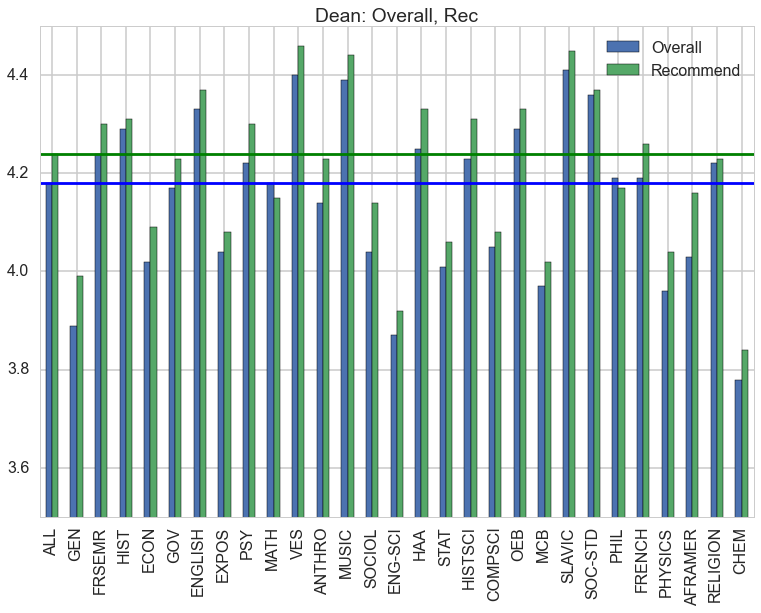

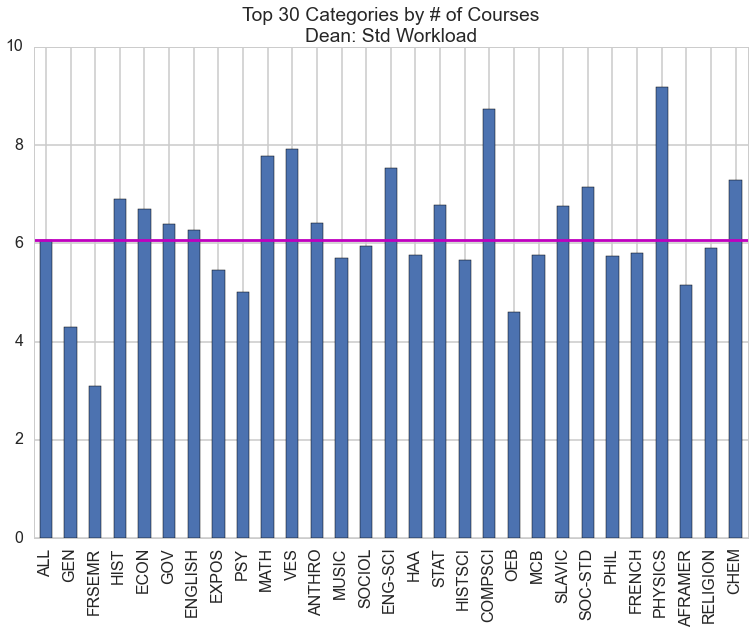

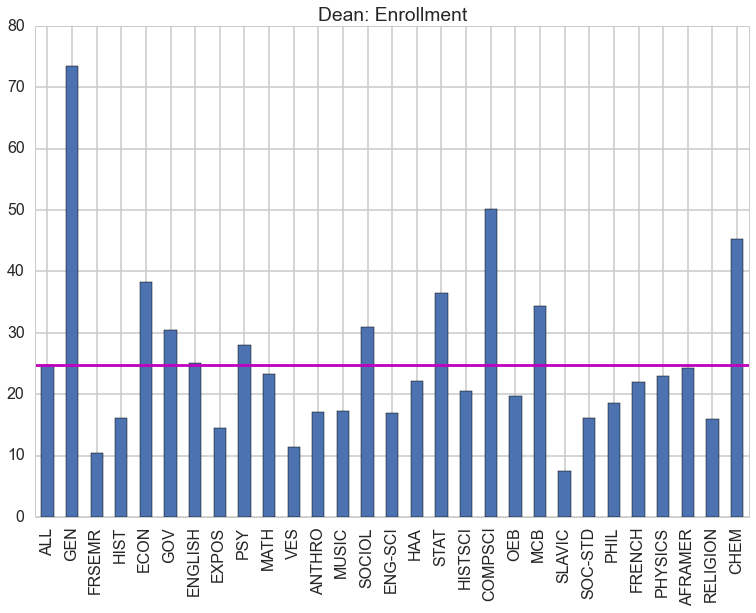

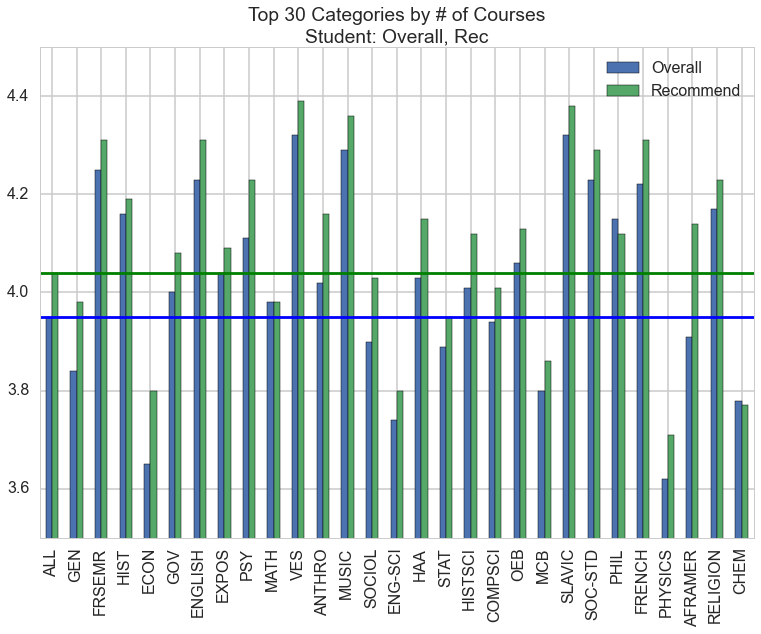

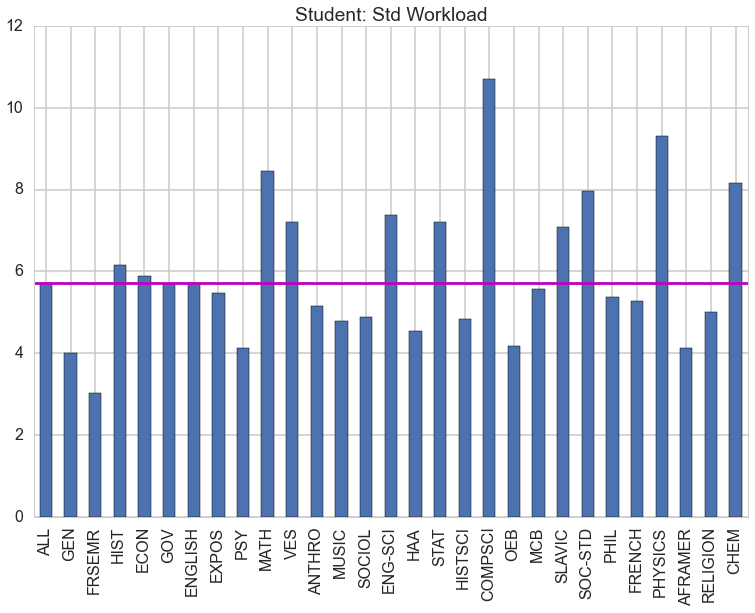

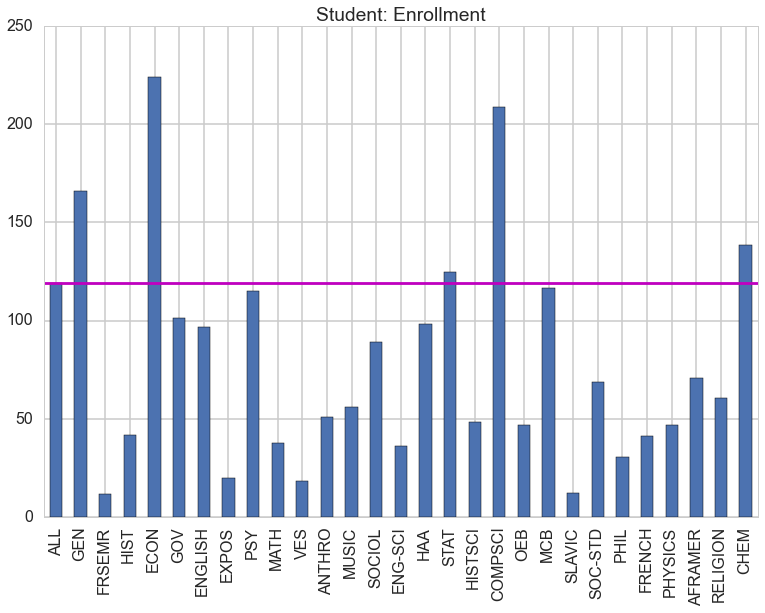

In [153]:
denoen = de.drop(['Enrollment','Std Workload'], axis=1)
denoen.plot(kind='bar', ylim=(3.5, 4.5), title='Dean: Overall, Rec')
plt.axhline(de['Overall']['ALL'], 0, 1, color='b', label='Mean')
plt.axhline(de['Recommend']['ALL'], 0, 1, color='g', label='Mean')
plt.figure()
de['Std Workload'].plot(kind='bar', title='Top 30 Categories by # of Courses\nDean: Std Workload')
plt.axhline(de['Std Workload']['ALL'], 0, 1, color='m', label='Mean')
plt.figure()
de['Enrollment'].plot(kind='bar', title='Dean: Enrollment')
plt.axhline(de['Enrollment']['ALL'], 0, 1, color='m', label='Mean')

plt.figure()
stnoen = st.drop(['Enrollment','Std Workload'], axis=1)
stnoen.plot(kind='bar', ylim=(3.5, 4.5), title='Top 30 Categories by # of Courses\nStudent: Overall, Rec')
plt.axhline(st['Overall']['ALL'], 0, 1, color='b', label='Mean')
plt.axhline(st['Recommend']['ALL'], 0, 1, color='g', label='Mean')
plt.figure()
st['Std Workload'].plot(kind='bar', title='Student: Std Workload')
plt.axhline(st['Std Workload']['ALL'], 0, 1, color='m', label='Mean')
plt.figure()
st['Enrollment'].plot(kind='bar', title='Student: Enrollment')
plt.axhline(st['Enrollment']['ALL'], 0, 1, color='m', label='Mean')


######Overall Stats

In [9]:
getPerspective(df)

Dean's perspective
Overall Mean/Median:
4.17960595817 4.2
Std Workload Mean/Median/Max:
6.06297885869 5.6 30.3
Recommend Mean/Median:
4.23636603933 4.3
Enrollments Mean/Median/Max:
24.697702667 12.0 1072.0


Student's perspective
Overall Mean/Median:
3.94957436423 4.0
Std Workload Mean/Median:
5.73201094538 5.3
Recommend Mean/Median:
4.04420319981 4.1
Enrollments Mean/Median:
119.211200233 51.0



These are the stats for Fall 2007 to Spring 2015.

We see with each course weighed equally, the average Q score is approximately 4.19, with worload hovering at around 6. Interestingly, Would Recommend Q scores are slightly higher than the overall Q scores. The average for each class is 24 students, with a median of 12. This is with each class weighed equally. As shown in Stat 110, the picture can be different when evaluated from the means encountered by those going to class.

Given equal weight to each student, the overall and would recommend Q scores fall by 0.2 points. Workload falls by about 0.3 hours. And enrollment increases drastically to mean of 118, and median of 50.

###Categories

In [10]:
def getCategoryInfo(df, enrollmin = 20):
    cats = df.columns[4:15]
    cats = np.delete(cats, 6)
    for cat in cats:
        print 'Max ' + cat
        maxcat = df
        if cat != 'Enrollment':
            maxcat = maxcat[maxcat['Enrollment'] >= enrollmin]
        maxcat = maxcat[maxcat[cat] == maxcat[cat].max()]
        maxcat = maxcat.sort(['Year', 'Term'], ascending = [True, True])
    #    springsorted = lastspringdf.sort(['Workload Q', 'Overall Q', 'Would Recommend Q', 'Evaluations'], ascending=[True, False, False, False]

        display(pd.concat([maxcat['Course Category'], maxcat['Course Number'], maxcat['Course Title'],\
                        maxcat[cat], maxcat['Term'], maxcat['Year']], axis=1, keys=['category', 'num',\
                                                                                   'title', cat, 'term', 'year']))
        display(maxcat['Course Category'].value_counts())
        print 'Min ' + cat
        mincat = df
        if cat != 'Enrollment':
            mincat = mincat[mincat['Enrollment'] >= enrollmin]
        mincat = mincat[mincat[cat] == mincat[cat].min()]
        mincat = mincat.sort(['Year', 'Term'], ascending = [True, True])

        display(pd.concat([mincat['Course Category'], mincat['Course Number'], mincat['Course Title'],\
                        mincat[cat], mincat['Term'], mincat['Year']], axis=1, keys=['category', 'num',\
                                                                                   'title', cat, 'term', 'year']))
        display(mincat['Course Category'].value_counts())

In [12]:
getCategoryInfo(df, enrollmin = 5)

Max Overall Q


category             num                                              title  Overall Q    term  year
5       AFRAMER     AFRAMER 193        Religion and Social Change in Black America          5    Fall  2006
12        AKKAD       AKKAD 120                              Intermediate Akkadian          5    Fall  2006
20       ANTHRO     ANTHRO 1160          Introduction to the Yucatec Maya Language          5    Fall  2006
70       ASTRON     ASTRON 97HF                              Introductory Tutorial          5    Fall  2006
106       CHNSE       CHNSE AAB                Intensive Elementary Modern Chinese          5    Fall  2006
113     CHNSLIT    CHNSLIT 245R  Topics in Sinophone Studies - Modern Chinese P...          5    Fall  2006
119     COMPLIT     COMPLIT 275             Theory of Narrative: Conference Course          5    Fall  2006
148      E-PSCI       E-PSCI 99                             Tutorial - Senior Year          5    Fall  2006
192        ECON       ECON 985E                         Research in Macroeconomics          5    Fall  2006
197     ENG-SCI     ENG-SCI 125                                 Mechanical Systems          5    Fall  2006
198     ENG-SCI     ENG-SCI 128       Computational Solid and Structural Mechanics          5    Fall  2006
213     ENG-SCI     ENG-SCI 240                                    Solid Mechanics          5    Fall  2006
227     ENGLISH     ENGLISH 144   Early Modern Literature: Six Voices, Six Visions          5    Fall  2006
228     ENGLISH     ENGLISH 154  19th-Century English Poetry: Wordsworth to Ten...          5    Fall  2006
234     ENGLISH     ENGLISH 187                Native American Literary Traditions          5    Fall  2006
235     ENGLISH    ENGLISH 195X           Contemporary African American Literature          5    Fall  2006
240     ENGLISH     ENGLISH 255  European Romantic and Post-romantic Approaches...          5    Fall  2006
241     ENGLISH     ENGLISH 279  Foreign Affair? Literature and Culture of the ...          5    Fall  2006
242     ENGLISH     ENGLISH 282            Theories of Modernism: Graduate Seminar          5    Fall  2006
251     ENGLISH    ENGLISH 90WJ                           The Poetry of John Keats          5    Fall  2006
252     ENGLISH    ENGLISH 90WM                                    Words and Music          5    Fall  2006
257     ENGLISH     ENGLISH CQR                            Advanced Poetry Writing          5    Fall  2006
259     ENGLISH     ENGLISH CTR                           Advanced Fiction Writing          5    Fall  2006
262     ENGLISH     ENGLISH CYR                                    The Lyric Essay          5    Fall  2006
309      FRSEMR      FRSEMR 25N  Understanding Psychological Development, Disor...          5    Fall  2006
323      FRSEMR      FRSEMR 32K                         The Poetry of Walt Whitman          5    Fall  2006
353      FRSEMR      FRSEMR 47M               Nationalism in Modern Western Europe          5    Fall  2006
408         GOV        GOV 2319          Legislative and Popular Constitutionalism          5    Fall  2006
409         GOV        GOV 2490                The Political Economy of the School          5    Fall  2006
441         HAA        HAA 199G  Global Art: Comparative Approaches in Art Hist...          5    Fall  2006
...         ...             ...                                                ...        ...     ...   ...
18602     MUSIC       MUSIC 156                        Tonal Counterpoint: Seminar          5  Spring  2015
18604     MUSIC     MUSIC 15HFR                                  Harvard Glee Club          5  Spring  2015
18611     MUSIC      MUSIC 192R         Topics in Music from 1600-1800: Proseminar          5  Spring  2015
18614     MUSIC      MUSIC 201B                 Current Methods in Ethnomusicology          5  Spring  2015
18617     MUSIC      MUSIC 217R                        19th-Century Music: Seminar          5  Spring  2015
18618     M

ENGLISH     68
VES         52
MATH        49
FRSEMR      46
ECON        43
HIST        41
MUSIC       41
PSY         37
GOV         33
HAA         22
RELIGION    21
ANTHRO      19
HISTSCI     19
SOCIOL      17
OEB         16
STAT        16
SLAVIC      15
CHNSLIT     13
NEUROBIO    12
SOC-STD     12
DRAMA       11
ASTRON      11
SPANSH      11
HEB         10
KOREAN       9
LATIN        9
AFRAMER      9
PHIL         9
WOMGEN       8
CHNSE        8
            ..
LITERTRE     2
HEBREW       2
SYSTBIO      2
CHEM         2
MEDVLSTD     2
CLASARCH     2
EABS         2
ESPP         2
DUTCH        1
HINDI        1
YIDDISH      1
MEDGREEK     1
CL           1
SEMPHIL      1
HLTHPOL      1
BIOLOGY      1
TIBETAN      1
CLAS-HEB     1
MANCHU       1
HSEMR-MA     1
VIROLOGY     1
HSEMR-WI     1
HBTM         1
MEDLATIN     1
CULTBLF      1
MED-SCI      1
AESTHINT     1
DRB          1
ROM-STD      1
JEWISHST     1
dtype: int64

Min Overall Q


category          num                   title  Overall Q  term  year
71    ASTRON  ASTRON 98HF  Tutorial - Junior Year          1  Fall  2006
586     LING      LING 99  Tutorial - Senior Year          1  Fall  2006

ASTRON    1
LING      1
dtype: int64

Max Workload Q


category          num              title  Workload Q    term  year
17985  COMPSCI  COMPSCI 161  Operating Systems        30.3  Spring  2015

COMPSCI    1
dtype: int64

Min Workload Q


category             num                                              title  Workload Q    term  year
66       ASTRON    ASTRON 200HF       Seminar in Modern Astrophysics and Cosmology           1    Fall  2006
69       ASTRON    ASTRON 301HF                                     Research Forum           1    Fall  2006
245     ENGLISH     ENGLISH 350                                Teaching Colloquium           1    Fall  2006
276    FOR-CULT     FOR-CULT 80                                      Korea at 2100           1    Fall  2006
306      FRSEMR      FRSEMR 24Y                  Pharmaceuticals and Global Health           1    Fall  2006
308      FRSEMR      FRSEMR 25K                               You Are What You Eat           1    Fall  2006
313      FRSEMR      FRSEMR 25Z  Stress and Disease (Biobehavioral Aspects of H...           1    Fall  2006
341      FRSEMR      FRSEMR 41E  The American Creed: Exceptionalism and Nationa...           1    Fall  2006
419         GOV        GOV 90MI                        Plato's Political Dialogues           1    Fall  2006
525     HLTHPOL  HLTHPOL 3040HF                  Research Seminar in Health Policy           1    Fall  2006
800     SEMPHIL     SEMPHIL 140  Introduction to the Comparative Study of Semit...           1    Fall  2006
995      ASTRON    ASTRON 301HF                                     Research Forum           1    Fall  2007
996      ASTRON     ASTRON 97HF                              Introductory Tutorial           1    Fall  2007
999        BCMP        BCMP 230        Principles and Practice of Drug Development           1    Fall  2007
1058    CLASSIC     CLASSIC 350                    Classical Philology: Proseminar           1    Fall  2007
1137       ECON       ECON 985F        Research in International Trade and Finance           1    Fall  2007
1236     FRSEMR      FRSEMR 22I                             The Science of Sailing           1    Fall  2007
1238     FRSEMR      FRSEMR 23Z                             A Short History of DNA           1    Fall  2007
1251     FRSEMR      FRSEMR 31J                           Skepticism and Knowledge           1    Fall  2007
1568       MATH        MATH 265                  Infinite Dimensional Lie Algebras           1    Fall  2007
1570       MATH        MATH 282              Introduction to Seiberg-Witten Theory           1    Fall  2007
1571       MATH        MATH 283                              Topics in Knot Theory           1    Fall  2007
1572       MATH        MATH 288                                 Algebraic K-Theory           1    Fall  2007
1614      MUSIC     MUSIC 194RS                         Special Topics: Proseminar           1    Fall  2007
1715   RELIGION   RELIGION 1434          History of Western Christianity, 150-1100           1    Fall  2007
1719   RELIGION   RELIGION 1825  Themes in Feminism and Islam: A Historical Ove...           1    Fall  2007
1728    ROM-STD      ROM-STD 79       Romance Languages in Comparative Perspective           1    Fall  2007
1789     SOCIOL    SOCIOL 300HF                      Race, Identity and Inequality           1    Fall  2007
1837    SYSTBIO   SYSTBIO 300HF           Introduction to Systems Biology Research           1    Fall  2007
9468     ASTRON    ASTRON 200HF       Seminar in Modern Astrophysics and Cosmology           1  Spring  2007
...         ...             ...                                                ...         ...     ...   ...
8913       HIST     HIST 3920HF                   Colloquium on Teaching Practices           1    Fall  2014
9151       PHIL      PHIL 315HF                 Instructional Styles in Philosophy           1    Fall  2014
16757    ASTRON    ASTRON 301HF                                       Journal Club           1  Spring  2014
16790   CELLBIO   CELLBIO 309QC                    Advanced Topics in Cell Biology           1  Spring  2014
16792   CELLBIO   CELLBIO 311QC                    Recent Advances in Cell Biology 

FRSEMR      86
ECON        15
MATH        13
ASTRON      12
MUSIC       11
PHIL         8
DRAMA        6
SOCIOL       5
ENGLISH      5
HIST         5
CELLBIO      5
PSY          5
HAA          5
GOV          3
COMPSCI      3
RELIGION     3
CHEM         3
GENETIC      3
STAT         3
MED-SCI      3
E-PSCI       2
MCB          2
IMUIL        2
COMPLIT      2
MBB          2
NEUROBIO     2
CLASSIC      2
ENG-SCI      2
HLTHPOL      2
SPOL         2
BCMP         2
HBTM         2
MEDVLSTD     1
HSEMR-LO     1
LING         1
ANTHRO       1
PHYSICS      1
SCAND        1
SLAVIC       1
ESPP         1
ANE          1
PORTUG       1
AFRAMER      1
SCRB         1
RSRA         1
MODGRK       1
ROM-STD      1
FOR-CULT     1
CHEMBIO      1
CATALAN      1
YORUBA       1
HEBREW       1
SYSTBIO      1
SEMPHIL      1
dtype: int64

Max Std Workload Q


category          num              title  Std Workload Q    term  year
17985  COMPSCI  COMPSCI 161  Operating Systems            30.3  Spring  2015

COMPSCI    1
dtype: int64

Min Std Workload Q


category             num                                              title  Std Workload Q    term  year
8375    ASTRON    ASTRON 301HF                                       Journal Club               1    Fall  2014
8913      HIST     HIST 3920HF                   Colloquium on Teaching Practices               1    Fall  2014
9151      PHIL      PHIL 315HF                 Instructional Styles in Philosophy               1    Fall  2014
17979  COMPLIT   COMPLIT 243HF    Survive and Thrive - Graduate School and Beyond               1  Spring  2015
18061     ECON       ECON 2001          Research in Behavior in Games and Markets               1  Spring  2015
18461  HLTHPOL  HLTHPOL 3002HF      Graduate Reading Course: Mental Health Policy               1  Spring  2015
18575      MCB       MCB 350QC                               Scientific Integrity               1  Spring  2015
18669     PHIL       PHIL 321D                 Philosophy in Translation - German               1  Spring  2015
18717      PSY       PSY 2436R  Social Neuroscience and Psychopathology Labora...               1  Spring  2015
18875     STAT     STAT 300HFR                             Research in Statistics               1  Spring  2015
18881     STAT      STAT 392HF  Research Topics in Missing Data, Matching and ...               1  Spring  2015

PHIL       2
STAT       2
ECON       1
ASTRON     1
HLTHPOL    1
COMPLIT    1
PSY        1
MCB        1
HIST       1
dtype: int64

Max Would Recommend Q


category             num                                              title  Would Recommend Q    term  year
5       AFRAMER     AFRAMER 193        Religion and Social Change in Black America                  5    Fall  2006
12        AKKAD       AKKAD 120                              Intermediate Akkadian                  5    Fall  2006
20       ANTHRO     ANTHRO 1160          Introduction to the Yucatec Maya Language                  5    Fall  2006
58       ARABIC     ARABIC 130A                        Advanced Classical Arabic I                  5    Fall  2006
62       ARABIC     ARABIC 240R                         Classical Arabic Philology                  5    Fall  2006
110     CHNSLIT     CHNSLIT 132                                         Chinatowns                  5    Fall  2006
112     CHNSLIT     CHNSLIT 205  Issues in the Study of Chinese Vernacular Fiction                  5    Fall  2006
119     COMPLIT     COMPLIT 275             Theory of Narrative: Conference Course                  5    Fall  2006
133       DRAMA         DRAMA 1                            Introduction to Theatre                  5    Fall  2006
134       DRAMA        DRAMA 10                                   Beginning Acting                  5    Fall  2006
135       DRAMA        DRAMA 23                                          Directing                  5    Fall  2006
192        ECON       ECON 985E                         Research in Macroeconomics                  5    Fall  2006
227     ENGLISH     ENGLISH 144   Early Modern Literature: Six Voices, Six Visions                  5    Fall  2006
228     ENGLISH     ENGLISH 154  19th-Century English Poetry: Wordsworth to Ten...                  5    Fall  2006
234     ENGLISH     ENGLISH 187                Native American Literary Traditions                  5    Fall  2006
235     ENGLISH    ENGLISH 195X           Contemporary African American Literature                  5    Fall  2006
242     ENGLISH     ENGLISH 282            Theories of Modernism: Graduate Seminar                  5    Fall  2006
251     ENGLISH    ENGLISH 90WJ                           The Poetry of John Keats                  5    Fall  2006
252     ENGLISH    ENGLISH 90WM                                    Words and Music                  5    Fall  2006
257     ENGLISH     ENGLISH CQR                            Advanced Poetry Writing                  5    Fall  2006
259     ENGLISH     ENGLISH CTR                           Advanced Fiction Writing                  5    Fall  2006
262     ENGLISH     ENGLISH CYR                                    The Lyric Essay                  5    Fall  2006
265        ESPP        ESPP 90D  Status of Environmental Justice as a Public Po...                  5    Fall  2006
270    FOLKMYTH    FOLKMYTH 162  Edda and Saga: Myth and Reality of the Viking Age                  5    Fall  2006
303      FRSEMR      FRSEMR 23Z                             A Short History of DNA                  5    Fall  2006
307      FRSEMR      FRSEMR 25G  The Impact of Infectious Diseases on History a...                  5    Fall  2006
309      FRSEMR      FRSEMR 25N  Understanding Psychological Development, Disor...                  5    Fall  2006
317      FRSEMR      FRSEMR 26Q                    Testosterone and Human Behavior                  5    Fall  2006
353      FRSEMR      FRSEMR 47M               Nationalism in Modern Western Europe                  5    Fall  2006
359      GERMAN      GERMAN 162                Gender Theory and Narrative Fiction                  5    Fall  2006
...         ...             ...                                                ...                ...     ...   ...
18641       OEB        OEB 215R                            Topics in Ecophysiology                  5  Spring  2015
18643       OEB         OEB 234                           Topics in Marine Biology                  5  Spring  2015
18669      PHIL       PHIL 321D                 Philosophy in T

ENGLISH     82
FRSEMR      74
VES         64
MUSIC       56
HIST        47
GOV         43
PSY         42
MATH        37
ECON        37
HAA         28
ANTHRO      28
SLAVIC      25
OEB         24
HISTSCI     23
DRAMA       22
SOCIOL      22
SOC-STD     20
SPANSH      18
RELIGION    15
NEUROBIO    14
ARABIC      14
PHIL        14
WOMGEN      12
ASTRON      11
HEB         10
STAT        10
EASTD       10
CLASPHIL    10
HIST-LIT     9
ITAL         9
            ..
BIOLOGY      2
CLASARCH     2
RUSS         2
APPHY        1
LIT          1
LAT-STD      1
IMUIL        1
SHBT         1
CHEM         1
CLS-STDY     1
EGYPTIAN     1
HLTHPOL      1
BIOPHYS      1
APMTH        1
KORLIT       1
BBS          1
LIT-ART      1
MED-SCI      1
EAFM         1
HSEMR-PF     1
CATALAN      1
HEBREW       1
ROM-STD      1
JEWISHST     1
WELSH        1
VIROLOGY     1
EABS         1
EMREAS       1
HIND-URD     1
HSEMR-MA     1
dtype: int64

Min Would Recommend Q


category          num                   title  Would Recommend Q  term  year
71   ASTRON  ASTRON 98HF  Tutorial - Junior Year                  1  Fall  2006

ASTRON    1
dtype: int64

Max Enrollment


category          num    title  Enrollment  term  year
1606  MOR-REAS  MOR-REAS 22  Justice        1072  Fall  2007

MOR-REAS    1
dtype: int64

Min Enrollment


category            num                                              title  Enrollment    term  year
9952   JEWISHST   JEWISHST 142  Gender Roles and the Role of Gender: Jewish So...           1  Spring  2007
2798        TWI      TWI 101AR                                     Reading in Twi           1    Fall  2008
2947        BPH        BPH 206                    Advanced Respiratory Physiology           1    Fall  2009
2993   CLASARCH   CLASARCH 97R                              Classical Archaeology           1    Fall  2009
3349       HIST      HIST 1166  Marriage, Sex, and Family in Western Europe, 1...           1    Fall  2009
3645    PHYSICS    PHYSICS 136  Physics of NMR Imaging with Medical Applicatio...           1    Fall  2009
11346    CELTIC    CELTIC 129R                          Intermediate Modern Welsh           1  Spring  2009
11609    FRSEMR     FRSEMR 23F       Uncertainty, Probability, and Climate Change           1  Spring  2009
11873     LATIN      LATIN AAB                        Beginning Latin (Intensive)           1  Spring  2009
11951    MODGRK     MODGRK 100  Advanced Modern Greek: Introduction to Modern ...           1  Spring  2009
11953    MODGRK       MODGRK B  Intermediate Modern Greek: Language and Civili...           1  Spring  2009
12114    SLAVIC      SLAVIC 98                             Tutorial - Junior Year           1  Spring  2009
3953     CELTIC     CELTIC 128                       Introduction to Modern Welsh           1    Fall  2010
4445       HIST      HIST 1618           Telling Lives in Asia: Conference Course           1    Fall  2010
4457       HIST      HIST 2133    Studies in Tudor and Stuart History: Proseminar           1    Fall  2010
4708    PHYSICS    PHYSICS 136                         Physics of Medical Imaging           1    Fall  2010
4807     SLAVIC      SLAVIC GA                              Beginning Ukrainian I           1    Fall  2010
4897        TWI      TWI 101AR                                     Reading in Twi           1    Fall  2010
12666    FRSEMR     FRSEMR 42T            The Age of Reason: Science and Religion           1  Spring  2010
12802      HIST      HIST 2110  Problems in Late Medieval, Renaissance/Reforma...           1  Spring  2010
12815      HIST       HIST 70G                  Modern Jewish Religious Movements           1  Spring  2010
12817      HIST       HIST 72F       East European Identities: Russia and Ukraine           1  Spring  2010
12976  MEDGREEK   MEDGREEK 195         Byzantine Saints' Lives of the 7th Century           1  Spring  2010
12977  MEDLATIN   MEDLATIN 110            Latin Literature of the Twelfth Century           1  Spring  2010
12989    MODGRK       MODGRK B  Intermediate Modern Greek: Language and Civili...           1  Spring  2010
13085   PHYSICS   PHYSICS 289R  Euclidean Random Fields, Relativistic Quantum ...           1  Spring  2010
13165    SLAVIC     SLAVIC 151        Experiments in Reading: Chekhov and Nabokov           1  Spring  2010
13176    SLAVIC      SLAVIC CC                               Intermediate Czech I           1  Spring  2010
13178    SLAVIC      SLAVIC GB                             Beginning Ukrainian II           1  Spring  2010
5571       HIST       HIST 81I                    Holland in the Age of Rembrandt           1    Fall  2011
...         ...            ...                                                ...         ...     ...   ...
16871      CZCH         CZCH B                                 Intermediate Czech           1  Spring  2014
16973   ENG-SCI    ENG-SCI 224     Laboratory in Engineering and Physical Biology           1  Spring  2014
16976   ENG-SCI    ENG-SCI 230                        Advanced Tissue Engineering           1  Spring  2014
17131    FRSEMR     FRSEMR 30I        Noam Chomsky and the Science of Linguistics           1  Spring  2014
17172    GIKUYU       GIKUYU A                                  Elementary Gikuyu           1  Spring  2014
17304      

SLAVIC      19
HIST        16
NEP          7
FRSEMR       6
VIETNAM      4
MODGRK       4
CELTIC       4
SAS          4
TWI          4
MEDGREEK     3
ENG-SCI      3
PHYSICS      3
OEB          3
PLSH         3
TIBET        3
THI          3
UYGHUR       3
PALI         2
CZCH         2
LATIN        2
APPHY        2
RELIGION     2
YORUBA       2
TIBETAN      2
MCB          2
GIKUYU       2
JAPNLIT      2
VES          2
CLS-STDY     1
IRISH        1
FOLKMYTH     1
UKRA         1
SANSKRIT     1
JEWISHST     1
SOC-STD      1
BPH          1
CHNSE        1
BE           1
MEDLATIN     1
ECON         1
HEB          1
APCOMP       1
SALLC        1
CLASARCH     1
WELSH        1
CHNSHIS      1
BIOSTAT      1
MICROBI      1
DRB          1
E-PSCI       1
TAM          1
ASTRON       1
EASTD        1
APMTH        1
dtype: int64

Max Evaluations


category      num                    title  Evaluations  term  year
4045     ECON  ECON 10  Principles of Economics          741  Fall  2010

ECON    1
dtype: int64

Min Evaluations


category            num                                              title  Evaluations    term  year
70       ASTRON    ASTRON 97HF                              Introductory Tutorial            1    Fall  2006
71       ASTRON    ASTRON 98HF                             Tutorial - Junior Year            1    Fall  2006
112     CHNSLIT    CHNSLIT 205  Issues in the Study of Chinese Vernacular Fiction            1    Fall  2006
194        ECON      ECON 985H                      Research in Financial Markets            1    Fall  2006
197     ENG-SCI    ENG-SCI 125                                 Mechanical Systems            1    Fall  2006
227     ENGLISH    ENGLISH 144   Early Modern Literature: Six Voices, Six Visions            1    Fall  2006
238     ENGLISH   ENGLISH 232Z  Literary Forms and Cultural Forces: 1603-1640:...            1    Fall  2006
242     ENGLISH    ENGLISH 282            Theories of Modernism: Graduate Seminar            1    Fall  2006
408         GOV       GOV 2319          Legislative and Popular Constitutionalism            1    Fall  2006
419         GOV       GOV 90MI                        Plato's Political Dialogues            1    Fall  2006
441         HAA       HAA 199G  Global Art: Comparative Approaches in Art Hist...            1    Fall  2006
447         HAA       HAA 275W                                          The Thing            1    Fall  2006
543        ITAL        ITAL 48  Advanced Italian: Voices from Italy: Issues of...            1    Fall  2006
558      KOREAN    KOREAN 150A                       Readings in Cultural Studies            1    Fall  2006
562       LATIN      LATIN 109                            Lucan's De Bello Civili            1    Fall  2006
566       LATIN      LATIN 134                                      Archaic Latin            1    Fall  2006
567       LATIN      LATIN 201                                      Reading Latin            1    Fall  2006
585        LING       LING 98A                       Group Tutorial - Junior Year            1    Fall  2006
586        LING        LING 99                             Tutorial - Senior Year            1    Fall  2006
632        MATH      MATH 260A                 Introduction to Algebraic Geometry            1    Fall  2006
640         MCB        MCB 118                              Developmental Biology            1    Fall  2006
716        PHIL      PHIL 274Z               Contemporary Ethical Theory: Seminar            1    Fall  2006
735     PHYSICS   PHYSICS 287A                      Introduction to String Theory            1    Fall  2006
779    RELIGION  RELIGION 1825  Issues in Feminism and Islam: A Historical Ove...            1    Fall  2006
781    RELIGION  RELIGION 2001      The Cultural History of the Study of Religion            1    Fall  2006
782    RELIGION  RELIGION 2841  Orthodoxy: Religion, Truth, and Authority: Sem...            1    Fall  2006
800     SEMPHIL    SEMPHIL 140  Introduction to the Comparative Study of Semit...            1    Fall  2006
855      SOCIOL    SOCIOL 296A       Proseminar on Inequality and Social Policy I            1    Fall  2006
878        STAT       STAT 131              Times Series Analysis and Forecasting            1    Fall  2006
885     SWAHILI      SWAHILI B                               Intermediate Swahili            1    Fall  2006
...         ...            ...                                                ...          ...     ...   ...
8520       ECON      ECON 2001          Research in Behavior in Games and Markets            1    Fall  2014
8900       HIST    HIST 2320HF  Foundations of Modern European Intellectual Hi...            1    Fall  2014
8953    HISTSCI   HISTSCI 298V                        Media, Method, and Practice            1    Fall  2014
9151       PHIL     PHIL 315HF                 Instructional Styles in Philosophy            1    Fall  2014
9192        PSY      PSY 2436R  Social Neuroscience and Psychopathology Labora...  

ECON        26
MATH        20
RELIGION     9
PHIL         8
GOV          7
PSY          7
HIST         6
HAA          6
ANTHRO       5
SOCIOL       5
ENGLISH      4
LATIN        4
VES          4
TIBET        2
NEUROBIO     2
STAT         2
VIROLOGY     2
SLAVIC       2
ASTRON       2
CHNSLIT      2
JAPNHIST     2
CHNSHIS      2
PHYSICS      2
LING         2
CELLBIO      2
CLASSIC      1
CLASPHIL     1
SHBT         1
CHEM         1
ENG-SCI      1
GREEK        1
AKKAD        1
ITAL         1
TIBETAN      1
HISTSCI      1
SANSKRIT     1
KOREAN       1
SEMPHIL      1
ANE          1
RUSS         1
SYSTBIO      1
GENETIC      1
SOC-STD      1
MCB          1
BCMP         1
CLASARCH     1
HEB          1
URDU         1
FOLKMYTH     1
KORLIT       1
SWAHILI      1
dtype: int64

Max Materials Q


category             num                                              title  Materials Q    term  year
12        AKKAD       AKKAD 120                              Intermediate Akkadian            5    Fall  2006
16          ANE         ANE 210     Textual Criticism of the Hebrew Bible: Seminar            5    Fall  2006
38       ANTHRO     ANTHRO 2680                          Globalization and Culture            5    Fall  2006
58       ARABIC     ARABIC 130A                        Advanced Classical Arabic I            5    Fall  2006
61       ARABIC     ARABIC 231A                                  Qur'an I: Seminar            5    Fall  2006
62       ARABIC     ARABIC 240R                         Classical Arabic Philology            5    Fall  2006
75      BIOSTAT     BIOSTAT 232                                          Methods I            5    Fall  2006
114     CHNSLIT     CHNSLIT 269                         Chinese Poetry and Poetics            5    Fall  2006
119     COMPLIT     COMPLIT 275             Theory of Narrative: Conference Course            5    Fall  2006
144      E-PSCI     E-PSCI 270R          Structural Interpretation of Seismic Data            5    Fall  2006
173        ECON       ECON 2070                           Economics of Information            5    Fall  2006
213     ENG-SCI     ENG-SCI 240                                    Solid Mechanics            5    Fall  2006
227     ENGLISH     ENGLISH 144   Early Modern Literature: Six Voices, Six Visions            5    Fall  2006
228     ENGLISH     ENGLISH 154  19th-Century English Poetry: Wordsworth to Ten...            5    Fall  2006
234     ENGLISH     ENGLISH 187                Native American Literary Traditions            5    Fall  2006
240     ENGLISH     ENGLISH 255  European Romantic and Post-romantic Approaches...            5    Fall  2006
241     ENGLISH     ENGLISH 279  Foreign Affair? Literature and Culture of the ...            5    Fall  2006
242     ENGLISH     ENGLISH 282            Theories of Modernism: Graduate Seminar            5    Fall  2006
251     ENGLISH    ENGLISH 90WJ                           The Poetry of John Keats            5    Fall  2006
252     ENGLISH    ENGLISH 90WM                                    Words and Music            5    Fall  2006
259     ENGLISH     ENGLISH CTR                           Advanced Fiction Writing            5    Fall  2006
262     ENGLISH     ENGLISH CYR                                    The Lyric Essay            5    Fall  2006
323      FRSEMR      FRSEMR 32K                         The Poetry of Walt Whitman            5    Fall  2006
334      FRSEMR      FRSEMR 39K  Literature Humanities: The Foundation Texts of...            5    Fall  2006
406         GOV        GOV 2285                        Political Science and China            5    Fall  2006
408         GOV        GOV 2319          Legislative and Popular Constitutionalism            5    Fall  2006
443         HAA         HAA 242           Issues of Interpretation in Medieval Art            5    Fall  2006
453         HEB        HEB 1418       Endocrinology and Behavior: Research Seminar            5    Fall  2006
498        HIST       HIST 2532                       The Soviet Union: Proseminar            5    Fall  2006
506        HIST       HIST 2906                     International History: Seminar            5    Fall  2006
...         ...             ...                                                ...          ...     ...   ...
18522     LITER       LITER 193  What's Love Got to Do With It; Love Poetry of ...            5  Spring  2015
18538      MATH      MATH 213BR                          Advanced Complex Analysis            5  Spring  2015
18542      MATH      MATH 232BR                              Algebraic Geometry II            5  Spring  2015
18545      MATH        MATH 259                           Diophantine Definability            5  Spring  2015
18547      MATH        MATH 261  Topics in Symp

ENGLISH     72
MATH        56
VES         56
ECON        47
MUSIC       45
HIST        44
FRSEMR      36
SLAVIC      33
PSY         32
HAA         26
HISTSCI     26
ANTHRO      22
GOV         21
STAT        21
SPANSH      14
CHNSLIT     13
ARABIC      13
RELIGION    13
SOCIOL      12
SOC-STD     12
PHIL        12
FRENCH      11
LATIN       10
WOMGEN       9
CLASPHIL     9
NEUROBIO     9
LING         9
EASTD        9
GERMAN       8
TIBET        8
            ..
SCIPHUNV     1
BIOCHSCI     1
IMUIL        1
DRB          1
SCAND        1
SAS          1
MODMDEST     1
MEDLATIN     1
MICROBI      1
SHBT         1
KORLIT       1
CULTBLF      1
TIBETAN      1
YORUBA       1
EXPOS        1
CLS-STDY     1
BCMP         1
SYSTBIO      1
LAT-STD      1
AESTHINT     1
SPOL         1
MBB          1
ESPP         1
APCOMP       1
VIETNAM      1
SWAHILI      1
WELSH        1
MES          1
SCRB         1
LIT-ART      1
dtype: int64

Min Materials Q


category          num                                        title  Materials Q    term  year
71      ASTRON  ASTRON 98HF                       Tutorial - Junior Year            1    Fall  2006
245    ENGLISH  ENGLISH 350                          Teaching Colloquium            1    Fall  2006
9609      ECON    ECON 985C                  Research in Labor Economics            1  Spring  2007
2548      MATH     MATH 286                         Random Matrix Theory            1    Fall  2008
11495     ECON    ECON 985F  Research in International Trade and Finance            1  Spring  2009

ECON       2
ASTRON     1
MATH       1
ENGLISH    1
dtype: int64

Max Assignments Q


category             num                                              title  Assignments Q    term  year
12        AKKAD       AKKAD 120                              Intermediate Akkadian              5    Fall  2006
38       ANTHRO     ANTHRO 2680                          Globalization and Culture              5    Fall  2006
70       ASTRON     ASTRON 97HF                              Introductory Tutorial              5    Fall  2006
75      BIOSTAT     BIOSTAT 232                                          Methods I              5    Fall  2006
113     CHNSLIT    CHNSLIT 245R  Topics in Sinophone Studies - Modern Chinese P...              5    Fall  2006
143      E-PSCI     E-PSCI 255R                        Topics in Tropical Dynamics              5    Fall  2006
192        ECON       ECON 985E                         Research in Macroeconomics              5    Fall  2006
197     ENG-SCI     ENG-SCI 125                                 Mechanical Systems              5    Fall  2006
227     ENGLISH     ENGLISH 144   Early Modern Literature: Six Voices, Six Visions              5    Fall  2006
240     ENGLISH     ENGLISH 255  European Romantic and Post-romantic Approaches...              5    Fall  2006
241     ENGLISH     ENGLISH 279  Foreign Affair? Literature and Culture of the ...              5    Fall  2006
251     ENGLISH    ENGLISH 90WJ                           The Poetry of John Keats              5    Fall  2006
257     ENGLISH     ENGLISH CQR                            Advanced Poetry Writing              5    Fall  2006
262     ENGLISH     ENGLISH CYR                                    The Lyric Essay              5    Fall  2006
269    FOLKMYTH    FOLKMYTH 114  Embodied Expression/Expressive Body: Dance in ...              5    Fall  2006
283      FRENCH      FRENCH 259  The Culture of Hysteria in Nineteenth-Century ...              5    Fall  2006
325      FRSEMR      FRSEMR 33X     Complexity in Works of Art: Ulysses and Hamlet              5    Fall  2006
360      GERMAN      GERMAN 170                          Goethe's Faust in Context              5    Fall  2006
362      GERMAN      GERMAN 288         German Novels Since Reunification: Seminar              5    Fall  2006
441         HAA        HAA 199G  Global Art: Comparative Approaches in Art Hist...              5    Fall  2006
447         HAA        HAA 275W                                          The Thing              5    Fall  2006
455      HEBREW     HEBREW 200R  Problems in the Literature, History, and Relig...              5    Fall  2006
506        HIST       HIST 2906                     International History: Seminar              5    Fall  2006
509    HIST-LIT     HIST-LIT 99                             Tutorial - Senior Year              5    Fall  2006
517     HISTSCI     HISTSCI 212  The Sciences of Life, Medicine and the Body in...              5    Fall  2006
519     HISTSCI     HISTSCI 284  Technology and the Text: Machines and Discours...              5    Fall  2006
543        ITAL         ITAL 48  Advanced Italian: Voices from Italy: Issues of...              5    Fall  2006
567       LATIN       LATIN 201                                      Reading Latin              5    Fall  2006
626        MATH      MATH 230AR                              Differential Geometry              5    Fall  2006
629        MATH       MATH 251A                            Algebraic Number Theory              5    Fall  2006
...         ...             ...                                                ...            ...     ...   ...
18603     MUSIC    MUSIC 157GEW               South Indian Music Theory & Practice              5  Spring  2015
18604     MUSIC     MUSIC 15HFR                                  Harvard Glee Club              5  Spring  2015
18608     MUSIC      MUSIC 186R                                 Jazz Improvisation              5  Spring  2015
18609     MUSIC     MUSIC 189RS                          Chamber Music Performance     

VES         55
MATH        47
ENGLISH     45
MUSIC       35
HIST        35
PSY         27
HAA         27
GOV         25
ECON        23
FRSEMR      21
STAT        21
ANTHRO      18
HISTSCI     16
SLAVIC      16
RELIGION    15
SOCIOL      12
NEUROBIO    11
CHNSLIT     10
SOC-STD      9
OEB          9
LING         8
FRENCH       8
PHIL         8
CLASPHIL     8
E-PSCI       7
ASTRON       7
DRAMA        6
SPANSH       6
FOLKMYTH     6
GERMAN       6
            ..
MEDVLSTD     1
IMUIL        1
MEDGREEK     1
BIOSTAT      1
DRB          1
URDU         1
TAM          1
SPOL         1
YORUBA       1
EXPOS        1
BCMP         1
ROM-STD      1
LAT-STD      1
HEBREW       1
WELSH        1
HSEMR-LO     1
ESPP         1
SHBT         1
VIETNAM      1
BPH          1
TURKISH      1
BIOLOGY      1
MES          1
VIROLOGY     1
HLTHPOL      1
CELTIC       1
BBS          1
COMPSCI      1
MEDLATIN     1
HSEMR-MA     1
dtype: int64

Min Assignments Q


category          num                                         title  Assignments Q    term  year
71      ASTRON  ASTRON 98HF                        Tutorial - Junior Year              1    Fall  2006
855     SOCIOL  SOCIOL 296A  Proseminar on Inequality and Social Policy I              1    Fall  2006
1568      MATH     MATH 265             Infinite Dimensional Lie Algebras              1    Fall  2007
9971      LING    LING 202R                               Advanced Syntax              1  Spring  2007
2548      MATH     MATH 286                          Random Matrix Theory              1    Fall  2008
16372     PHIL   PHIL 315HF            Instructional Styles in Philosophy              1  Spring  2013

MATH      2
ASTRON    1
PHIL      1
SOCIOL    1
LING      1
dtype: int64

Max Feedback Q


category            num                                              title  Feedback Q    term  year
20       ANTHRO    ANTHRO 1160          Introduction to the Yucatec Maya Language           5    Fall  2006
38       ANTHRO    ANTHRO 2680                          Globalization and Culture           5    Fall  2006
43       ANTHRO     ANTHRO 91R                    Supervised Reading and Research           5    Fall  2006
109     CHNSHIS    CHNSHIS 244  Introduction to the Study of Late Medieval Chi...           5    Fall  2006
113     CHNSLIT   CHNSLIT 245R  Topics in Sinophone Studies - Modern Chinese P...           5    Fall  2006
143      E-PSCI    E-PSCI 255R                        Topics in Tropical Dynamics           5    Fall  2006
144      E-PSCI    E-PSCI 270R          Structural Interpretation of Seismic Data           5    Fall  2006
160        ECON      ECON 1480              Moral Perspectives on Economic Growth           5    Fall  2006
193        ECON      ECON 985G  Research in Behavioral and Experimental Economics           5    Fall  2006
194        ECON      ECON 985H                      Research in Financial Markets           5    Fall  2006
197     ENG-SCI    ENG-SCI 125                                 Mechanical Systems           5    Fall  2006
213     ENG-SCI    ENG-SCI 240                                    Solid Mechanics           5    Fall  2006
226     ENGLISH    ENGLISH 131                     Milton: Major Poetry and Prose           5    Fall  2006
227     ENGLISH    ENGLISH 144   Early Modern Literature: Six Voices, Six Visions           5    Fall  2006
240     ENGLISH    ENGLISH 255  European Romantic and Post-romantic Approaches...           5    Fall  2006
242     ENGLISH    ENGLISH 282            Theories of Modernism: Graduate Seminar           5    Fall  2006
247     ENGLISH   ENGLISH 90KW                             The American Civil War           5    Fall  2006
251     ENGLISH   ENGLISH 90WJ                           The Poetry of John Keats           5    Fall  2006
257     ENGLISH    ENGLISH CQR                            Advanced Poetry Writing           5    Fall  2006
259     ENGLISH    ENGLISH CTR                           Advanced Fiction Writing           5    Fall  2006
262     ENGLISH    ENGLISH CYR                                    The Lyric Essay           5    Fall  2006
279      FRENCH     FRENCH 112  From the Troubadour to the Grand Rhetoriqueur:...           5    Fall  2006
302      FRSEMR     FRSEMR 23J                              Chess and Mathematics           5    Fall  2006
323      FRSEMR     FRSEMR 32K                         The Poetry of Walt Whitman           5    Fall  2006
362      GERMAN     GERMAN 288         German Novels Since Reunification: Seminar           5    Fall  2006
409         GOV       GOV 2490                The Political Economy of the School           5    Fall  2006
419         GOV       GOV 90MI                        Plato's Political Dialogues           5    Fall  2006
430       GREEK      GREEK 105                                       Aristophanes           5    Fall  2006
443         HAA        HAA 242           Issues of Interpretation in Medieval Art           5    Fall  2006
445         HAA       HAA 271X   The Origins of Modernity: The "New" 18th Century           5    Fall  2006
...         ...            ...                                                ...         ...     ...   ...
18619     MUSIC    MUSIC 250HF                    Colloquium on Teaching Pedagogy           5  Spring  2015
18625     MUSIC      MUSIC BHF            Exercises in Tonal Writing and Analysis           5  Spring  2015
18641       OEB       OEB 215R                            Topics in Ecophysiology           5  Spring  2015
18643       OEB        OEB 234                           Topics in Marine Biology           5  Spring  2015
18669      PHIL      PHIL 321D                 Philosophy in Translation - German           5  Spring  2015
18720      

ENGLISH     73
MATH        54
HIST        54
VES         47
GOV         46
ECON        44
MUSIC       43
FRSEMR      36
PSY         32
HAA         30
HISTSCI     28
RELIGION    25
SLAVIC      25
ANTHRO      25
SOCIOL      19
STAT        19
EXPOS       17
PHIL        17
KOREAN      17
LING        16
GERMAN      16
SOC-STD     15
FRENCH      15
CHNSLIT     13
JAPAN       13
OEB         12
SPANSH      11
DRAMA       10
ARABIC      10
CLASPHIL     9
            ..
JEWISHST     2
BIOLOGY      2
KORLIT       1
CHEMBIO      1
WOM-STD      1
ANE          1
LIT          1
HEBREW       1
MEDGREEK     1
SPOL         1
MCB          1
BIOSTAT      1
MODMDEST     1
TAM          1
URDU         1
BIOPHYS      1
DRB          1
HSEMR-MA     1
MICROBI      1
CLAS-HEB     1
HSEMR-LO     1
ESPP         1
IRISH        1
MANCHU       1
APMTH        1
BBS          1
AM-CIV       1
UYGHUR       1
AKKAD        1
MES          1
dtype: int64

Min Feedback Q


category           num                                              title  Feedback Q    term  year
1      AFRAMER   AFRAMER 113  Fictions of Race, Facts of Racism: Perspective...           1    Fall  2006
71      ASTRON   ASTRON 98HF                             Tutorial - Junior Year           1    Fall  2006
831    SOC-STD  SOC-STD 98IB                        Varieties of Social Justice           1    Fall  2006
984     ARABIC    ARABIC 158  Modern Arabic Literature Seminar: Lebanese Civ...           1    Fall  2007
999       BCMP      BCMP 230        Principles and Practice of Drug Development           1    Fall  2007
1568      MATH      MATH 265                  Infinite Dimensional Lie Algebras           1    Fall  2007
1618     MUSIC    MUSIC 218R                        20th-Century Music: Seminar           1    Fall  2007
9757   GENETIC   GENETIC 206  Genetic and Functional Genomic Dissection of D...           1  Spring  2007
12026     PHIL     PHIL 300B                                         Colloquium           1  Spring  2009
3904    ANTHRO   ANTHRO 2870  Transgressive Texts: Contemporary Latin Americ...           1    Fall  2010
15051    IMUIL   IMUIL 302QC                                  Clinical Sessions           1  Spring  2012
15775     ECON   ECON 2690HF         Environmental Economics and Policy Seminar           1  Spring  2013
16240     MATH    MATH 212BR                             Advanced Real Analysis           1  Spring  2013
8377    ASTRON     ASTRON 99                      Senior Thesis in Astrophysics           1    Fall  2014

MATH       2
ASTRON     2
ANTHRO     1
AFRAMER    1
SOC-STD    1
PHIL       1
ARABIC     1
GENETIC    1
ECON       1
MUSIC      1
BCMP       1
IMUIL      1
dtype: int64

Max Section Q


category            num                                              title  Section Q    term  year
1      AFRAMER    AFRAMER 113  Fictions of Race, Facts of Racism: Perspective...          5    Fall  2006
12       AKKAD      AKKAD 120                              Intermediate Akkadian          5    Fall  2006
23      ANTHRO    ANTHRO 1415     Primate Evolutionary Ecology: Research Seminar          5    Fall  2006
26      ANTHRO    ANTHRO 1625              Global Food Systems: Research Seminar          5    Fall  2006
28      ANTHRO    ANTHRO 1698                            Shamanism and Modernity          5    Fall  2006
51       APMTH      APMTH 206         Advanced Applied Algebra and Combinatorics          5    Fall  2006
82      CELTIC     CELTIC 132                       Introduction to Modern Irish          5    Fall  2006
84      CELTIC     CELTIC 166                              The Folklore of Women          5    Fall  2006
96     CHEMBIO   CHEMBIO 2100                   Organic Chemistry for Biologists          5    Fall  2006
102      CHNSE     CHNSE 142A                    Advanced Conversational Chinese          5    Fall  2006
115         CL         CL 263  Journey, Exile, and Displacement in Modern Ara...          5    Fall  2006
134      DRAMA       DRAMA 10                                   Beginning Acting          5    Fall  2006
136      DRAMA       DRAMA 26                   George Balanchine: Ballet Master          5    Fall  2006
138      DUTCH       DUTCH AA                                   Elementary Dutch          5    Fall  2006
140     E-PSCI     E-PSCI 161                                   Global Tectonics          5    Fall  2006
150      EASTD      EASTD 140                 Major Religious Texts of East Asia          5    Fall  2006
154      EASTD      EASTD 98R                             Tutorial - Junior Year          5    Fall  2006
184       ECON      ECON 2723                                    Asset Pricing I          5    Fall  2006
198    ENG-SCI    ENG-SCI 128       Computational Solid and Structural Mechanics          5    Fall  2006
212    ENG-SCI    ENG-SCI 222                      Advanced Cellular Engineering          5    Fall  2006
213    ENG-SCI    ENG-SCI 240                                    Solid Mechanics          5    Fall  2006
217    ENG-SCI    ENG-SCI 261                   Design of Water Resource Systems          5    Fall  2006
226    ENGLISH    ENGLISH 131                     Milton: Major Poetry and Prose          5    Fall  2006
227    ENGLISH    ENGLISH 144   Early Modern Literature: Six Voices, Six Visions          5    Fall  2006
247    ENGLISH   ENGLISH 90KW                             The American Civil War          5    Fall  2006
248    ENGLISH   ENGLISH 90LV                 Consciousness from Austen to Woolf          5    Fall  2006
249    ENGLISH   ENGLISH 90QC                           Ibsen, Shaw, and Chekhov          5    Fall  2006
252    ENGLISH   ENGLISH 90WM                                    Words and Music          5    Fall  2006
255    ENGLISH    ENGLISH CER                                 Building the Essay          5    Fall  2006
259    ENGLISH    ENGLISH CTR                           Advanced Fiction Writing          5    Fall  2006
...        ...            ...                                                ...        ...     ...   ...
18807  SOC-STD   SOC-STD 98HP                  Is Democracy Possible Everywhere?          5  Spring  2015
18811  SOC-STD   SOC-STD 98MF                                         Liberalism          5  Spring  2015
18813  SOC-STD   SOC-STD 98NQ                                   Global East Asia          5  Spring  2015
18815  SOC-STD   SOC-STD 98NU            Poor People's Politics in Latin America          5  Spring  2015
18816  SOC-STD   SOC-STD 98NY  And Justice for All: Ethics and America's Schools          5  Spring  2015
18829   SOCIOL     SOCIOL 168         Sociology of Biomedicine and Global Health    

FRSEMR      285
VES         200
GOV         188
ENGLISH     182
HIST        168
PSY         109
ECON         99
ANTHRO       90
MUSIC        85
MATH         81
HAA          79
SOCIOL       75
HISTSCI      67
SOC-STD      65
SLAVIC       58
STAT         54
DRAMA        48
SPANSH       47
FRENCH       45
OEB          45
ENG-SCI      45
AFRAMER      43
NEUROBIO     42
RELIGION     42
LATIN        36
COMPSCI      36
GERMAN       35
HEB          31
ITAL         31
ARABIC       31
           ... 
GEN-ED        1
DRB           1
HSEMR-MA      1
WOM-STD       1
URDU          1
HSEMR-CU      1
SPOL          1
NEPALI        1
CLASSIC       1
VIROLOGY      1
EGYPTIAN      1
UKRAN         1
SCIPHUNV      1
HINDI         1
CZCH          1
CHEMBIO       1
AMSTDIES      1
SHBT          1
ANE           1
ARAMAIC       1
ROM-LANG      1
TIBHIST       1
GERM-STD      1
HSEMR-LO      1
LAT-STD       1
APCOMP        1
HSEMR-EL      1
CULTBLF       1
THI           1
BIOCHSCI      1
dtype: int64

Min Section Q


category            num                                              title  Section Q    term  year
182        ECON      ECON 2610                          Industrial Organization I          1    Fall  2006
221     ENG-SCI    ENG-SCI 274                               Quantum Technology I          1    Fall  2006
371         GOV       GOV 1006                           Mathematics of Elections          1    Fall  2006
873      SPANSH      SPANSH AX                                    Reading Spanish          1    Fall  2006
906         VES        VES 169             Dreaming and the Moving Image: Seminar          1    Fall  2006
1069    COMPSCI    COMPSCI 223              Probabilistic Analysis and Algorithms          1    Fall  2007
1143    ENG-SCI    ENG-SCI 145                     Physiological Systems Analysis          1    Fall  2007
1145    ENG-SCI    ENG-SCI 154                    Electronic Devices and Circuits          1    Fall  2007
1170    ENGLISH    ENGLISH 163       Dramatic Literature from the Greeks to Ibsen          1    Fall  2007
1193    ENGLISH   ENGLISH 90XP                   Contemporary Non-American Poetry          1    Fall  2007
1256     FRSEMR     FRSEMR 32L                                              Freud          1    Fall  2007
1263     FRSEMR     FRSEMR 36Z                             Utopia and Anti-Utopia          1    Fall  2007
1440       HIST      HIST 2607  Readings in the US in the 20th Century: Prosem...          1    Fall  2007
1548   LITERTRE    LITERTRE 12                   Introduction to Literary Studies          1    Fall  2007
1791     SOCIOL     SOCIOL 310                       Sociological Research Design          1    Fall  2007
9411    AFRAMER    AFRAMER 118  African American History from the Slave Trade ...          1  Spring  2007
9500       CHEM       CHEM 240                              Statistical Mechanics          1  Spring  2007
9599       ECON      ECON 2724                  Finance Theory in Continuous Time          1  Spring  2007
9620    ENG-SCI    ENG-SCI 151                        Electromagnetic Engineering          1  Spring  2007
9768        GOV       GOV 1004               Introduction to Agent-Based Modeling          1  Spring  2007
1916     ANTHRO    ANTHRO 1662         Anthropology of Middle Eastern Communities          1    Fall  2008
1952     ASTRON       ASTRON 2                               Celestial Navigation          1    Fall  2008
2130    ENGLISH   ENGLISH 171A                       Colonial American Literature          1    Fall  2008
2848     WOMGEN    WOMGEN 1460                Somatechnics: Bodies and Technology          1    Fall  2008
10317   AFRAMER    AFRAMER 113  Fictions of Race, Facts of Racism: Perspective...          1  Spring  2008
10370    ARABIC   ARABIC 241BR               Modern Arabic Literature and Culture          1  Spring  2008
10740       HAA        HAA 206            Science and the Practice of Art History          1  Spring  2008
10906  LITERTRE  LITERTRE 187R   Selected Topics in Poetics and Rhetoric: Seminar          1  Spring  2008
2870    AFRAMER    AFRAMER 185                  Perspectives on the African Novel          1    Fall  2009
2912      APMTH      APMTH 120                          Applicable Linear Algebra          1    Fall  2009
3066       ECON     ECON 2530A                                International Trade          1    Fall  2009
3103    ENGLISH    ENGLISH 130                      17th-Century Poetry and Prose          1    Fall  2009
3823        VES      VES 150AR        Intermediate Film Production: Studio Course          1    Fall  2009
11487      ECON      ECON 2811                                   Social Economics          1  Spring  2009
4084       ECON     ECON 2530A                                International Trade          1    Fall  2010
12591   ENGLISH   ENGLISH 90SA                     The Idea of a Theatre: Seminar          1  Spring  2010
6021        VES        VES 180                 F

ECON        7
ENGLISH     6
VES         5
ENG-SCI     5
GOV         3
AFRAMER     3
FRSEMR      2
HAA         2
ANTHRO      2
ASTRON      2
SOCIOL      2
ARABIC      2
LITERTRE    2
CHEM        1
ESPP        1
IMUIL       1
HIST        1
APMTH       1
COMPSCI     1
PERSIAN     1
SLAVIC      1
COMPLIT     1
SPANSH      1
WOMGEN      1
MATH        1
STAT        1
BE          1
dtype: int64

Things of note:
I filtered to only courses with more than 10 people enrolled. The reason for this is to avoid extremely small classes where only 2 people fill out the evaluation and it's no surprise that a particular course has a 5.0 overall and 5.0 recommendation.

* Max <b>Overall</b> Q: 224 courses with 5.0's, with Math and English classes placing 34 and 29 classes respectively. COMPSCI has only 1 entry :(
* Min <b>Overall</b> Q: Nobody likes CHEM thermodynamics or ARABIC modern literature. Both score 1.3.
* Max Std <b>Workload</b> Q: COMPSCI 161, 30.3. CS is hard. This is also a bit buggy, since I had to standardize the 1-5 scale with the hours scale, and I put a 5.0 as 17.5 hours...
* Min Std <b>Workload</b> Q: 5 courses with 1, as I put a 1.0 to standardize to 1.5... Of the non-standardized Workload Q, 44/101 were FRSEMR, with the next highest going to MATH, ASTRON, and ECON at 10, 8, and 7 respectively. COMPSCI doesn't even make this list.
* Max Recommend Q: 44 FRSEMR, 42 ENG dominate, but this is out of 308 courses that scored a 5.0. Wow. Interestingly, this is more than the Overall Q maxes.
* Min Recommend Q: Nobody likes CHEM thermodynamics. 1.4.
* Max Enroll: MOR-REAS 22 Justice, Fall 2007. 1072 people.
* Min Enroll: 138 courses with 1 person in them. 19 of which are SLAVIC and 16 of which are HIST. Most of these are language courses, unsurprisingly.
* Max Evals: ECON 10a, Fall 2010. 741 evals. Interestingly, the response rate for this class was above Justice's.
* Min Evals: 23 classes with only 1 responder, 13 of which were MATH. This does not include ones with 0 Evals though.

######Other Categories
* Max Materials has 236 5.0 ratings, 41 of which were MATH and 31 ENGLISH. The only 1.0 Materials is also a MATH, MATH 286, Fall 2008.
* Max Assignments has 157 5.0 ratings, 33 of which were MATH and 21 ENGLISH. 2 MATH and 1 LANG classes had 1.0 Assignments, both in 2007/2008
* Max Feedback has 269 5.0 ratings, 39 of which were MATH and 35 ENGLISH. 2 MATH, 1 ARABIC, and 1 MUSIC have 1.0 Feedback, the most recent of which is a Spring 2013 MATH 212BR.
* Max <b>Section</b> has <b>1531</b> 5.0 ratings, 183 of which were FRSEMR and 114 ENGLISH. MATH is down at 57. 34 Sections had 1.0 ratings, with ECON at 5 and ENGLISH at 4.

### Histograms

In [63]:
def histogramSeries(doitpls, title=None, ax=None):
    doitpls = doitpls.dropna()
    if not ax: plt.figure() #maybe it'll break?
    if title == 'Std Workload Q' and ax:
        #make custom ranges, 0-18. cs161 and others are outliers
        ax.hist(doitpls.values, bins=39, range=[0, 18])
    elif title == 'Overall Q' and ax:
        ax.hist(doitpls.values, bins=39, range=[1.0, 5.0])
    elif ax and (title == 'Evaluations' or title == 'Enrollment'):
        ax.hist(doitpls.values, bins=39, range=[0, 175])
    else:
        doitpls.plot(kind='hist', bins = 39, ax=ax)
    p5 = np.percentile(doitpls, 5)
    p95 = np.percentile(doitpls, 95)
    p50 = doitpls.mean()
    if ax:
        ax.axvline(p5, 0, .9, color='r', label='5th percentile')
        ax.axvline(p95, 0, .9, color='r', label='95th percentile')
        ax.axvline(p50, 0, .9, color='g', label='50th percentile')
        ax.set_ylabel("# of courses")
        if title:
            ax.set_title(title)
            #ax.set_xlabel(title)
    else:
        plt.axvline(p5, 0, .9, color='r', label='5th percentile')
        plt.axvline(p95, 0, .9, color='r', label='95th percentile')
        plt.axvline(p50, 0, .9, color='g', label='50th percentile')
        plt.ylabel("# of courses")
        if title:
            plt.title(title)
            plt.xlabel(title)
    if title:
        return (title, p50)


def histogramColsOnDF(dg, alltitle=None):
    cats = dg.columns[4:15]
    cats = np.delete(cats, 6) #kill response rate
    cats = np.delete(cats, 1) #kill regular workload in favor of std workload
    fig, axes=plt.subplots(nrows=3, ncols=3) #9 categories
    #fig.tight_layout()
    collectors = []
    for i in xrange(len(cats)):
        ab = histogramSeries(dg[cats[i]], title=cats[i], ax=axes[i/3][i%3]) # 9 categories
        if ab: collectors.append(ab)
    fig.tight_layout()
    if alltitle:
        plt.suptitle(alltitle, size=24)
    fig.subplots_adjust(top=0.92)
    if alltitle:
        print alltitle, collectors
    else:
        print collectors


spring 20155 [('Overall Q', 4.228046594982076), ('Std Workload Q', 5.925362318840583), ('Would Recommend Q', 4.263620071684594), ('Enrollment', 23.258960573476703), ('Evaluations', 19.14336917562724), ('Materials Q', 4.272292418772565), ('Assignments Q', 4.149411764705878), ('Feedback Q', 4.161767357980164), ('Section Q', 4.30694300518135)]


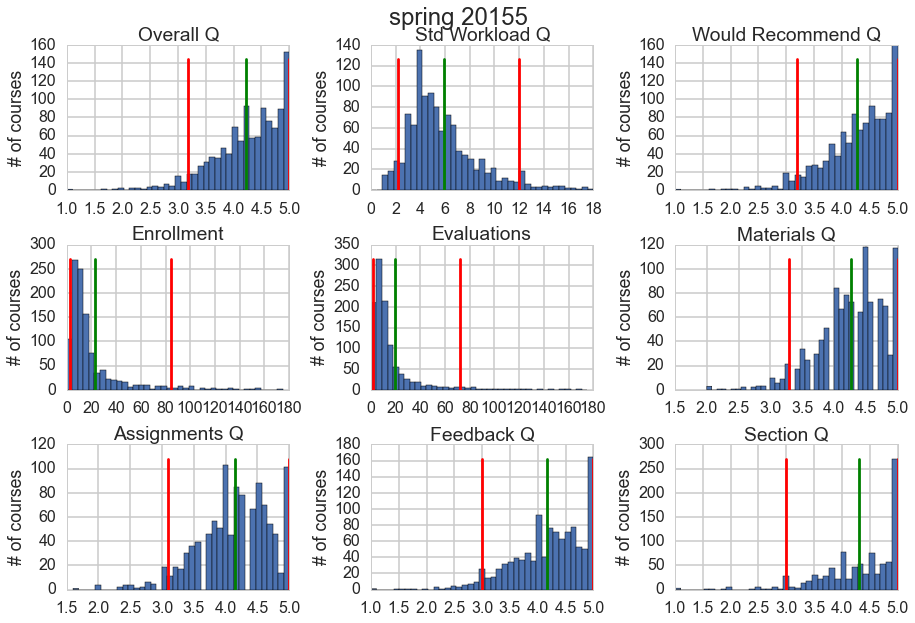

In [64]:
histogramColsOnDF(lastspringdf, alltitle='spring 2015~')

F2006-S2015 [('Overall Q', 4.179605958166069), ('Std Workload Q', 6.062978858686905), ('Would Recommend Q', 4.2363660393318145), ('Enrollment', 24.69770266701875), ('Evaluations', 19.691418008978083), ('Materials Q', 4.200554518795007), ('Assignments Q', 4.093666098444514), ('Feedback Q', 4.077580146980539), ('Section Q', 4.2256540242834)]


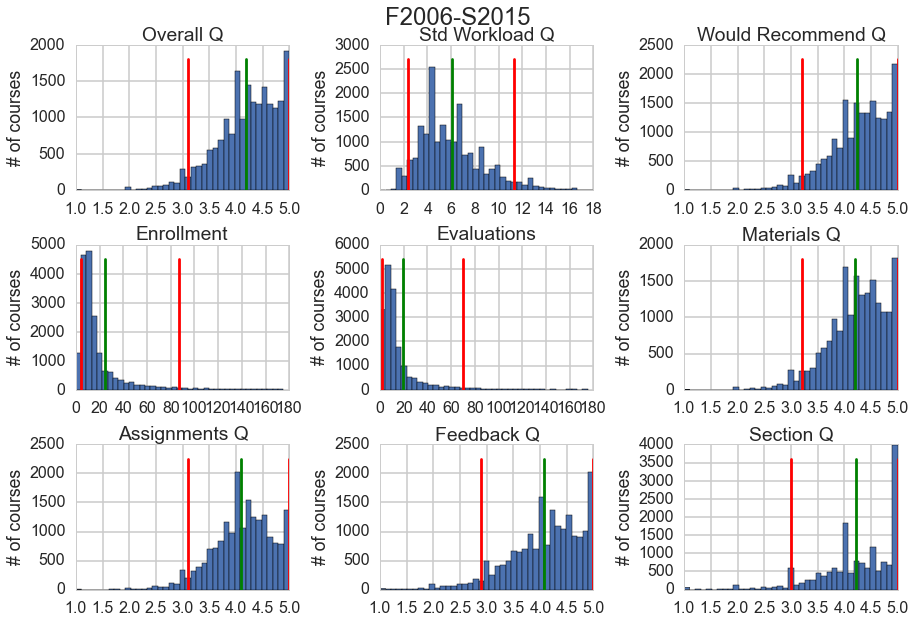

In [65]:
histogramColsOnDF(df, 'F2006-S2015')

[1072, 945, 921, 896, 697, 664, 506, 496, 490, 480, 441, 438, 426, 314, 312, 312, 304, 298, 284, 268, 262, 253, 252, 244, 237, 218, 209, 196, 196, 192, 179, 172, 161, 160, 159, 155, 150, 149, 148, 135, 127, 118, 115, 113, 112, 110, 104, 102, 101]
FRSEMR1072 [('Overall Q', 4.240671641791049), ('Std Workload Q', 3.1007469654528474), ('Would Recommend Q', 4.30307835820896), ('Enrollment', 10.374067164179104), ('Evaluations', 9.25839552238806), ('Materials Q', 4.223084112149531), ('Assignments Q', 4.144090056285176), ('Feedback Q', 4.062030075187973), ('Section Q', 4.350732217573223)]
HIST945 [('Overall Q', 4.292266949152541), ('Std Workload Q', 6.9090618336887015), ('Would Recommend Q', 4.314331210191085), ('Enrollment', 16.11864406779661), ('Evaluations', 12.659957627118644), ('Materials Q', 4.326198083067105), ('Assignments Q', 4.206723585912485), ('Feedback Q', 4.186979722518679), ('Section Q', 4.281376518218626)]
ECON921 [('Overall Q', 4.0173202614379075), ('Std Workload Q', 6.6951219

/Users/Roger/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


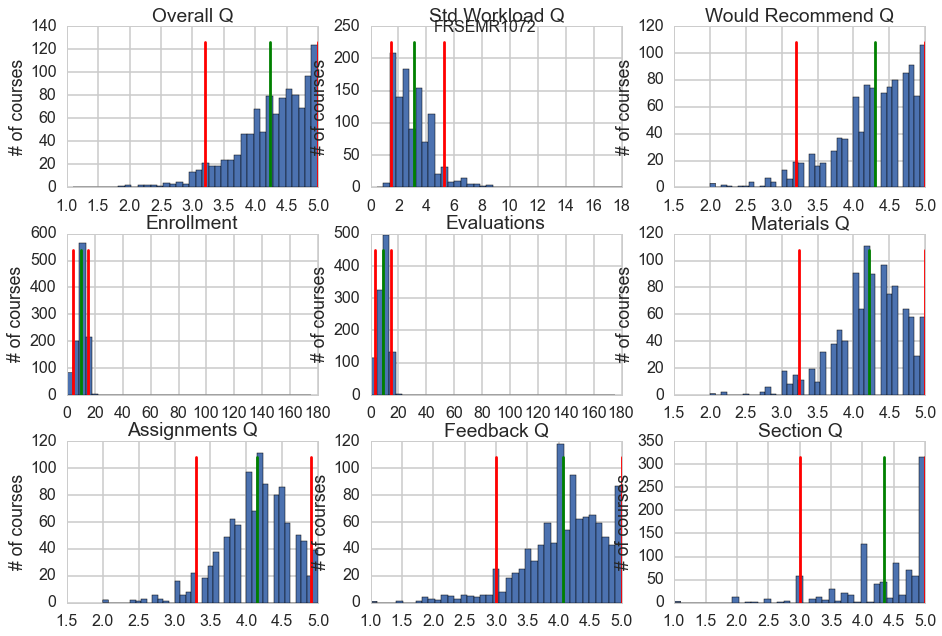

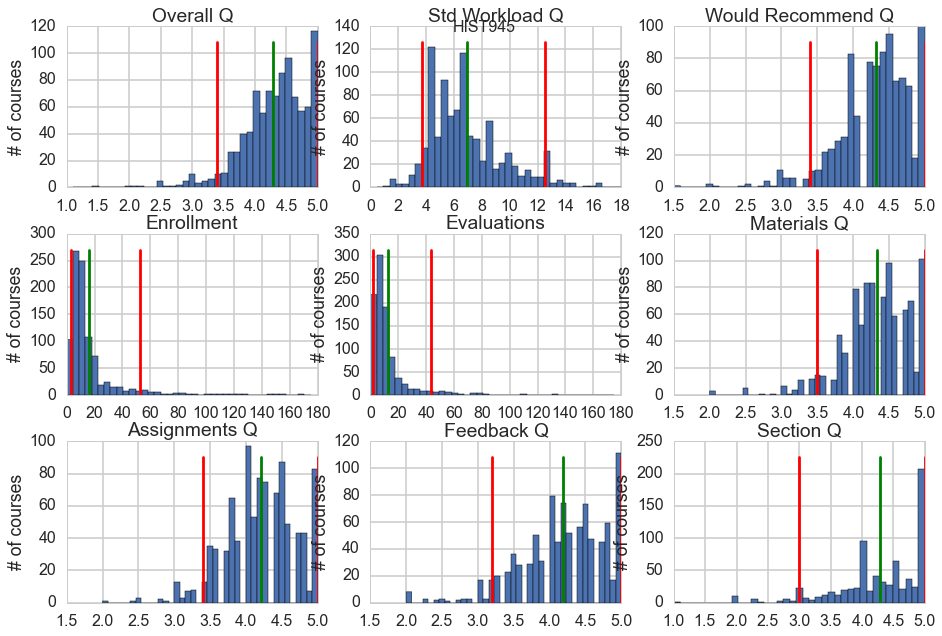

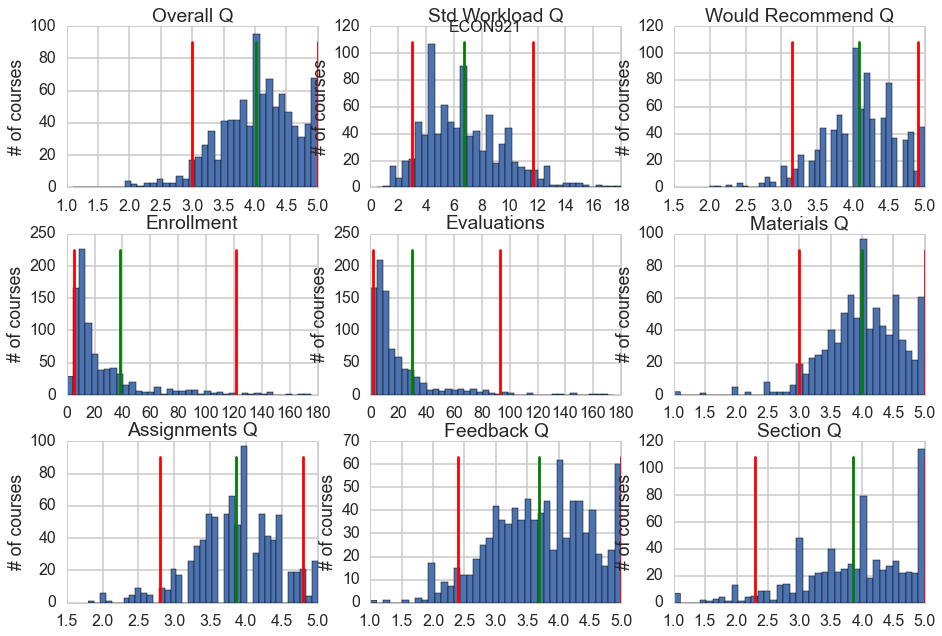

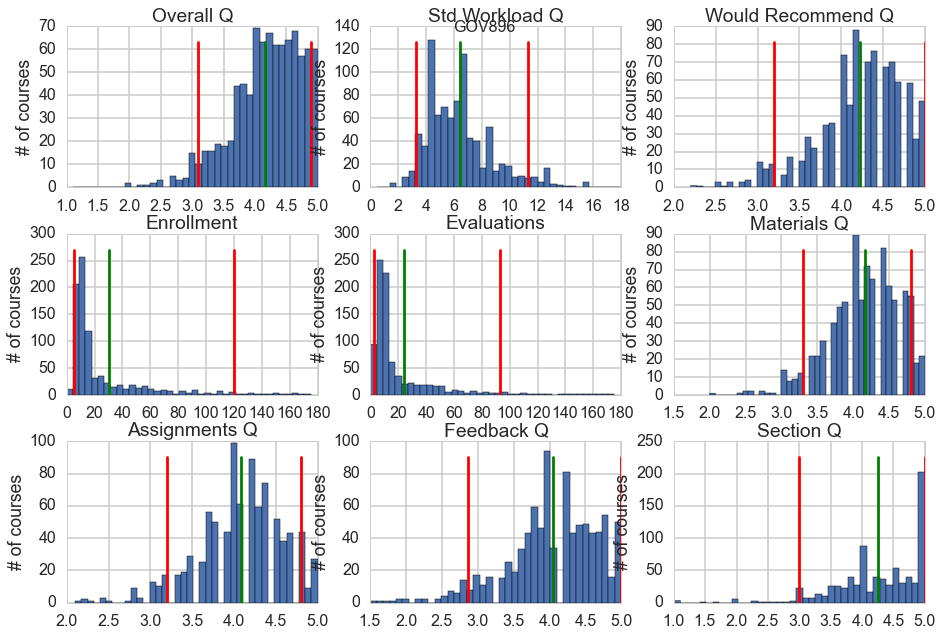

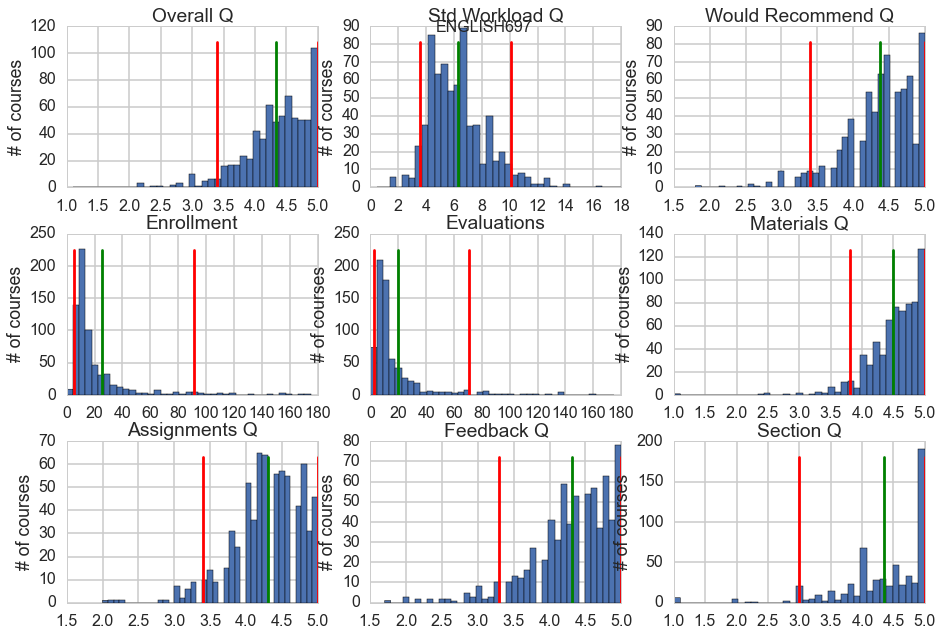

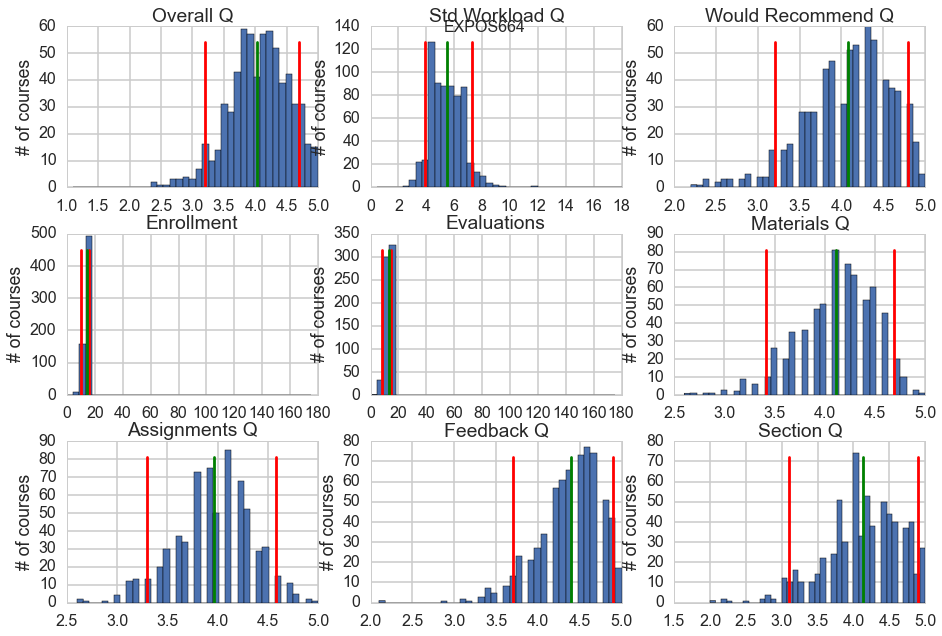

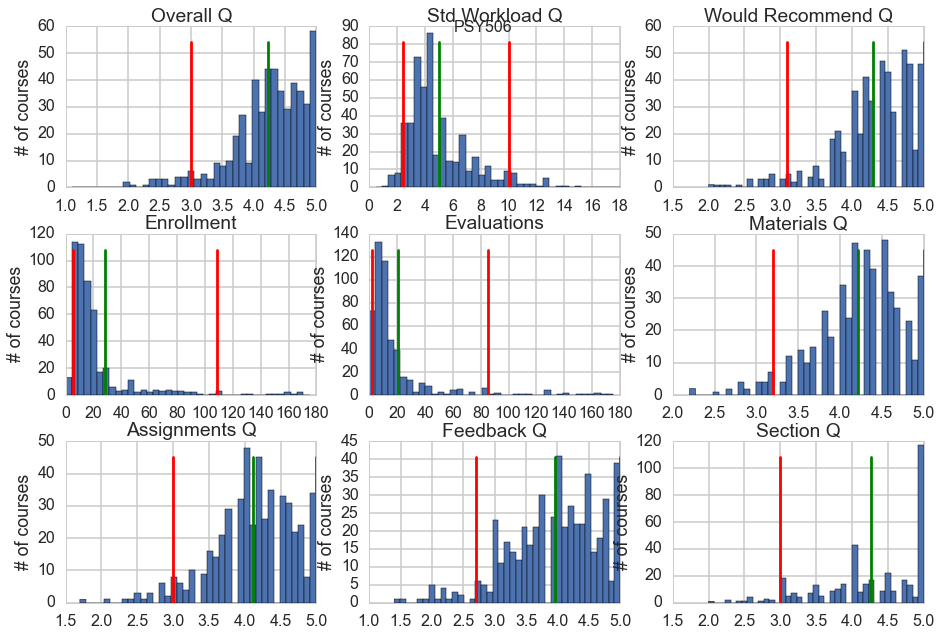

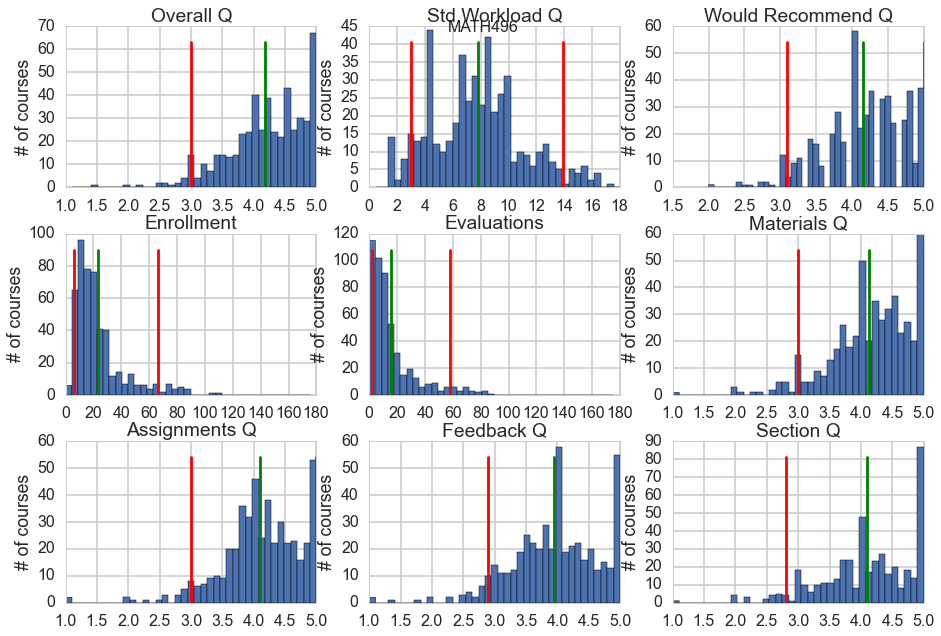

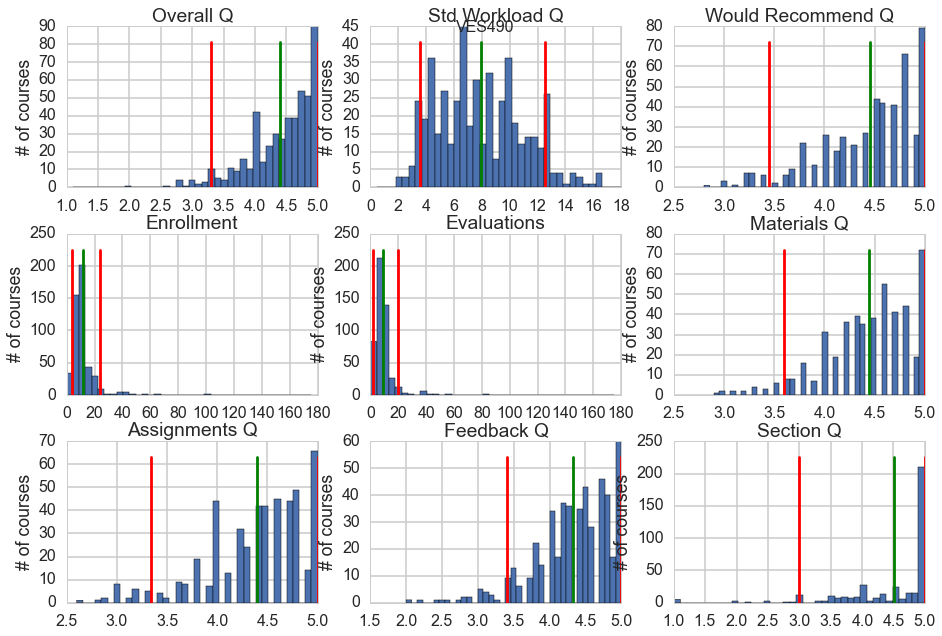

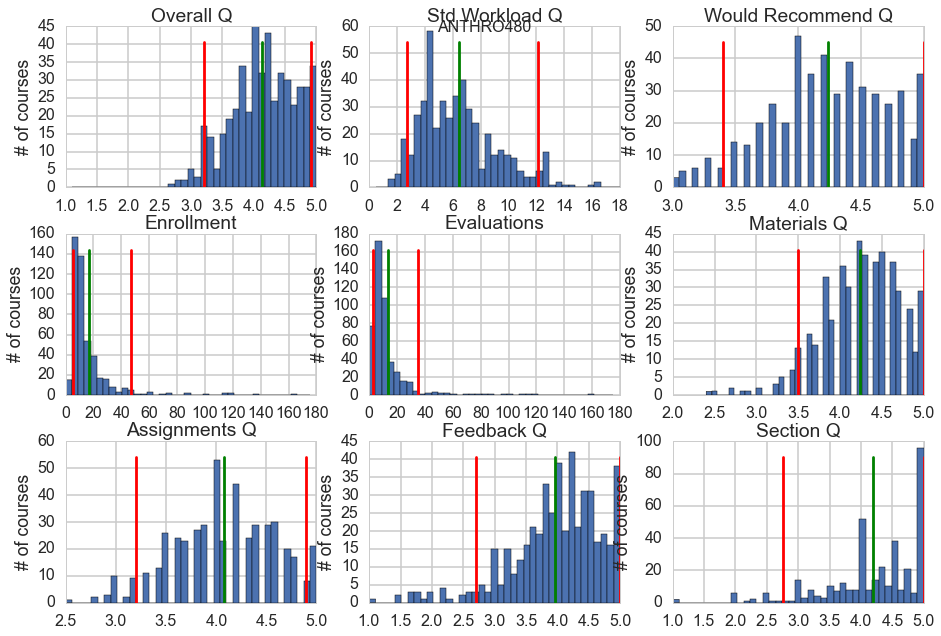

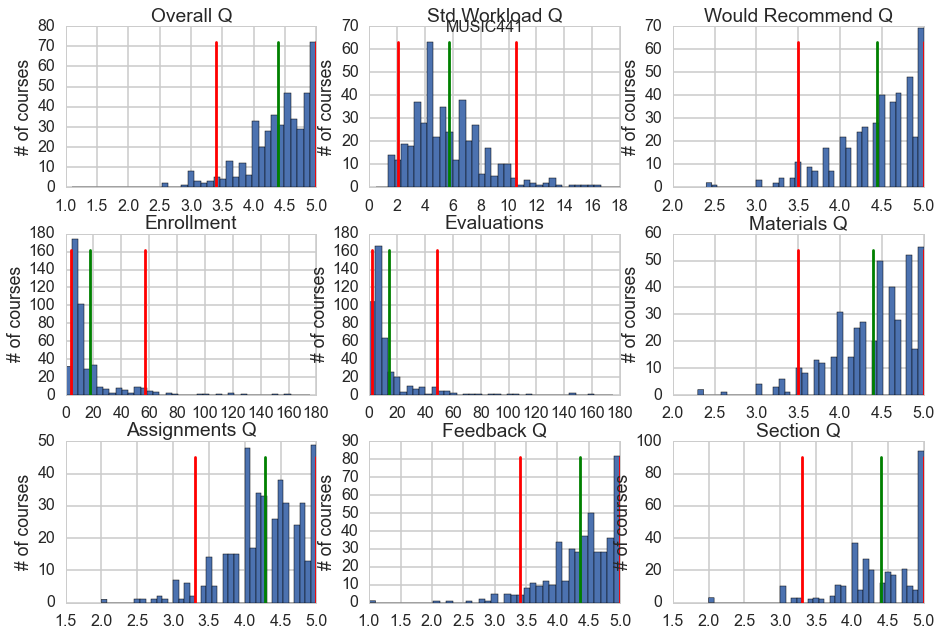

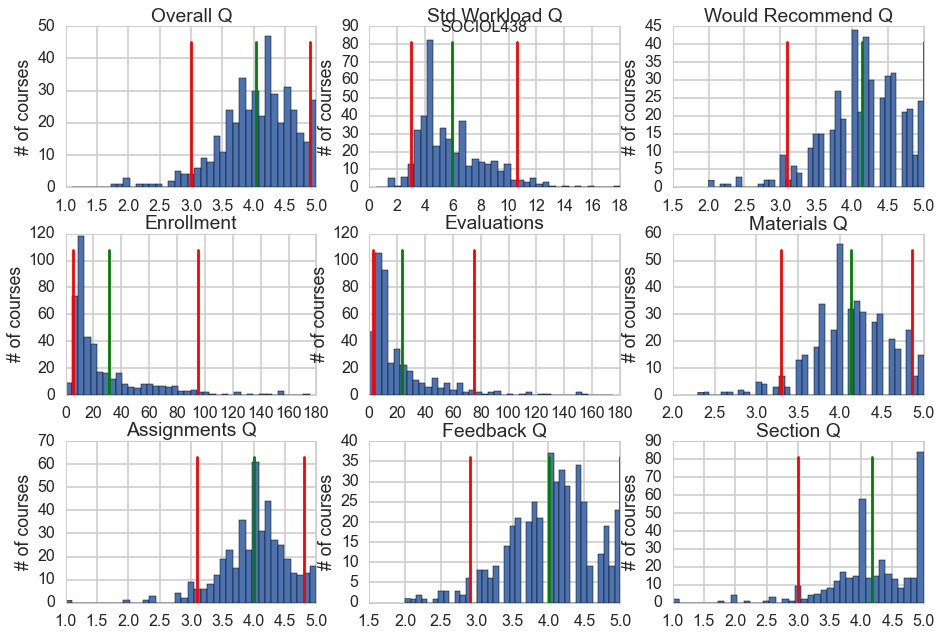

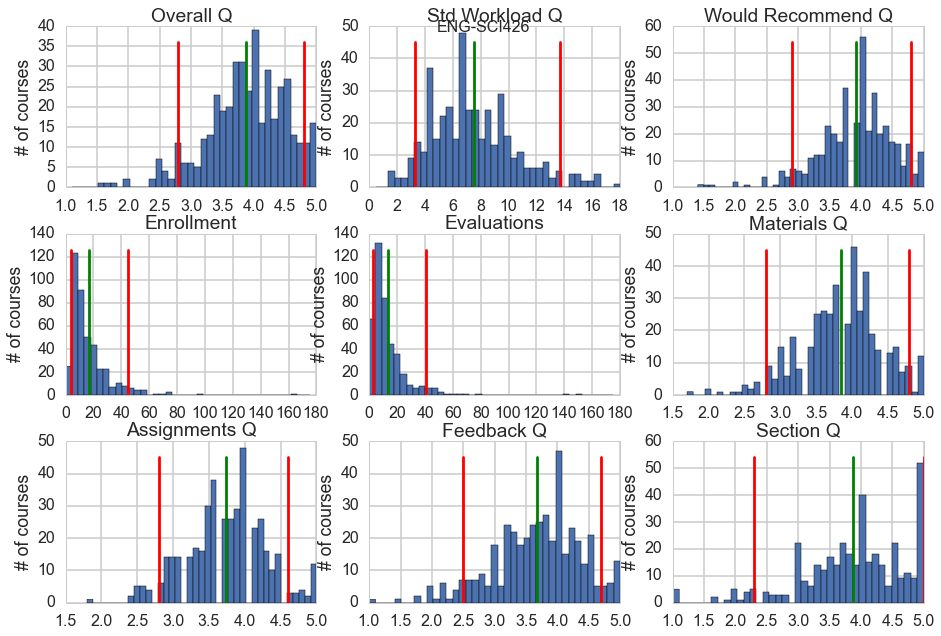

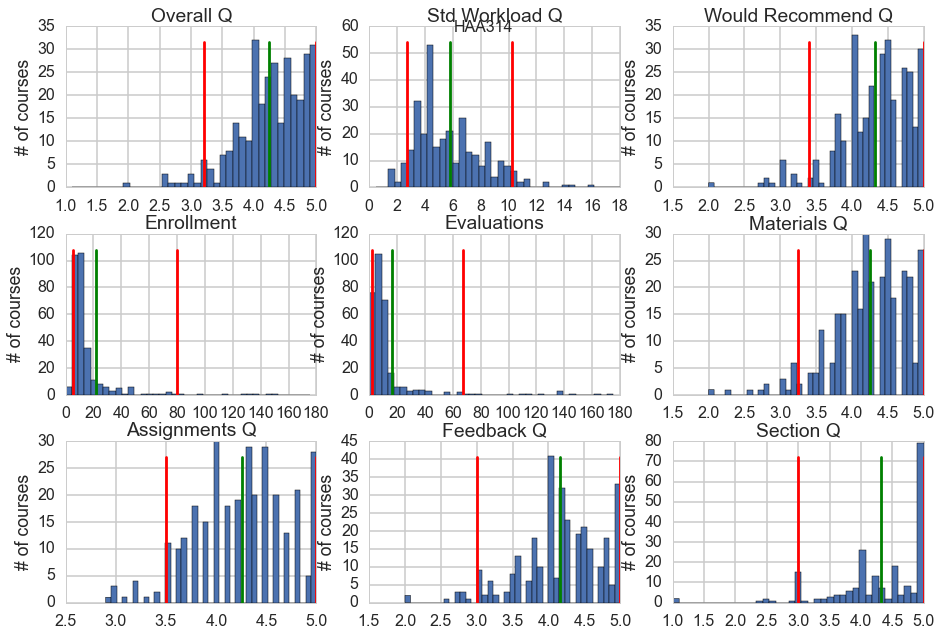

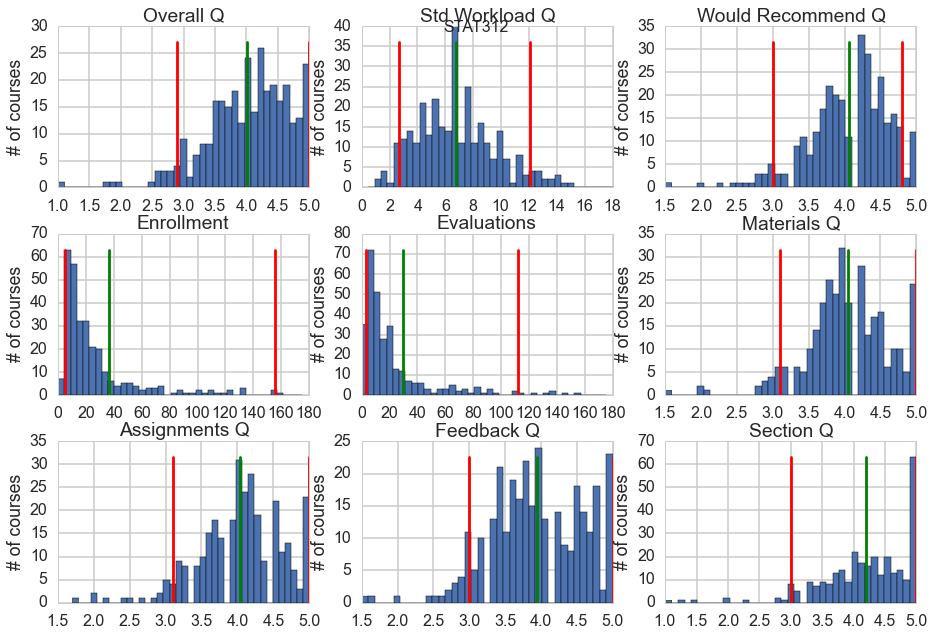

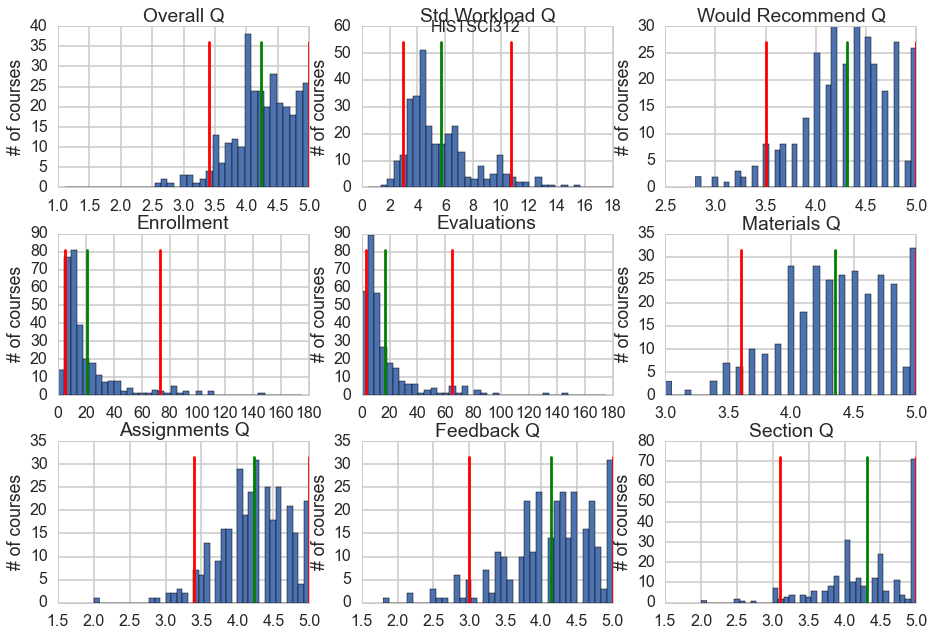

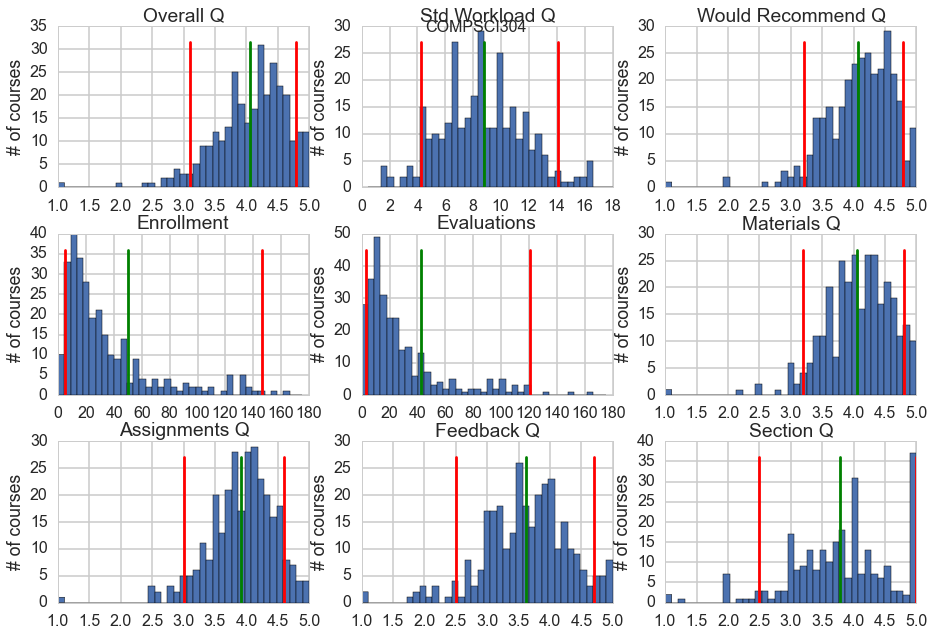

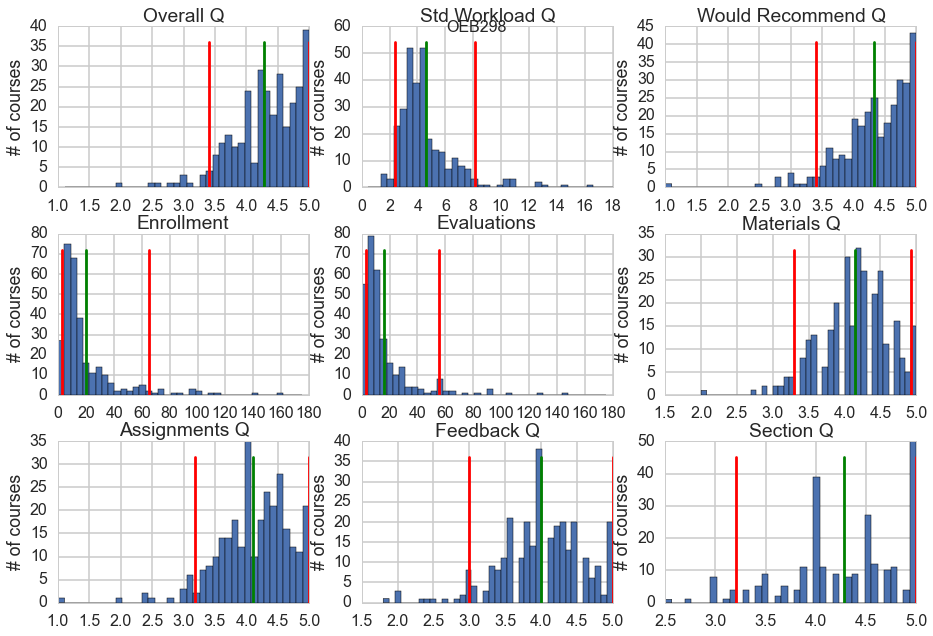

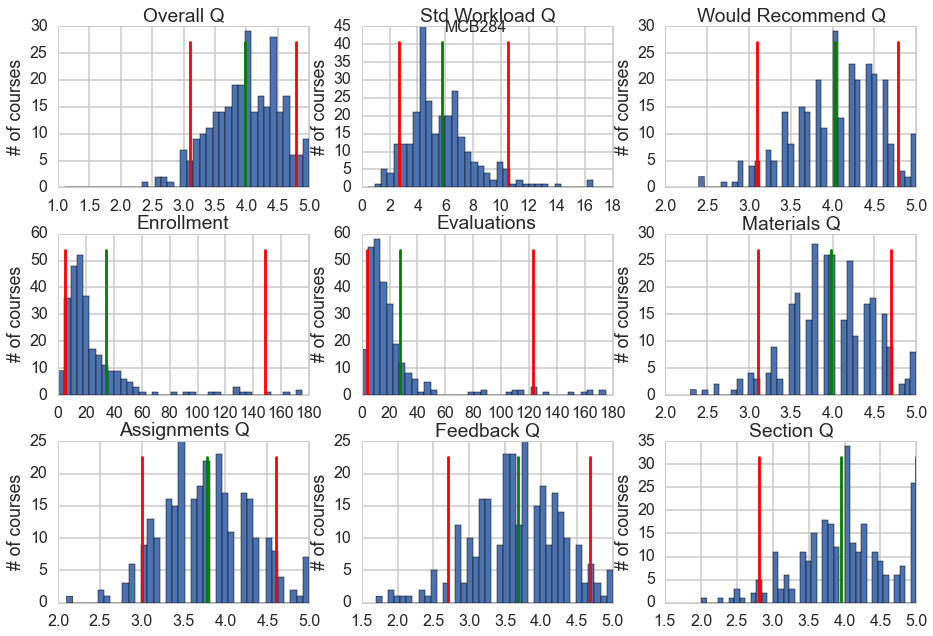

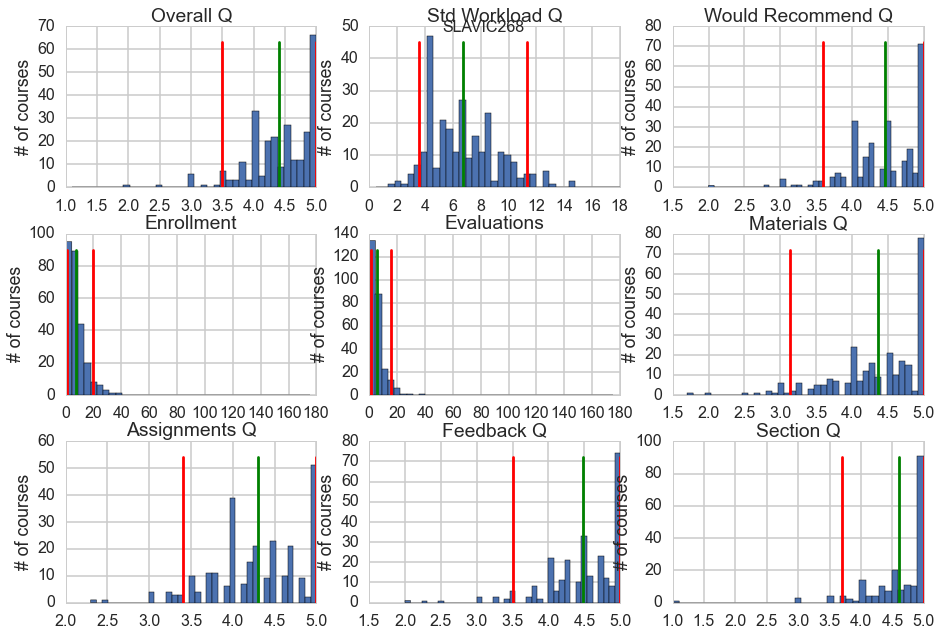

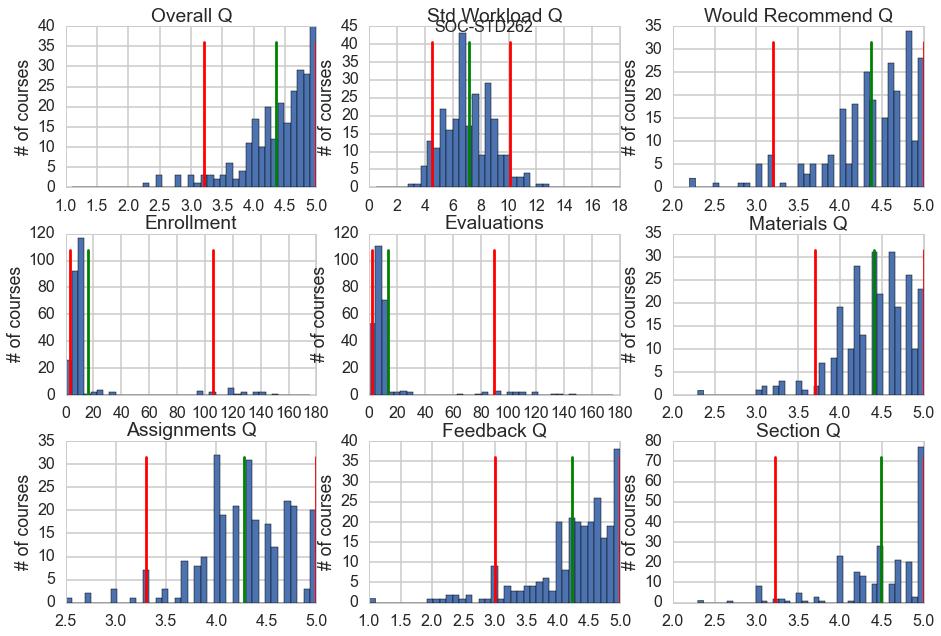

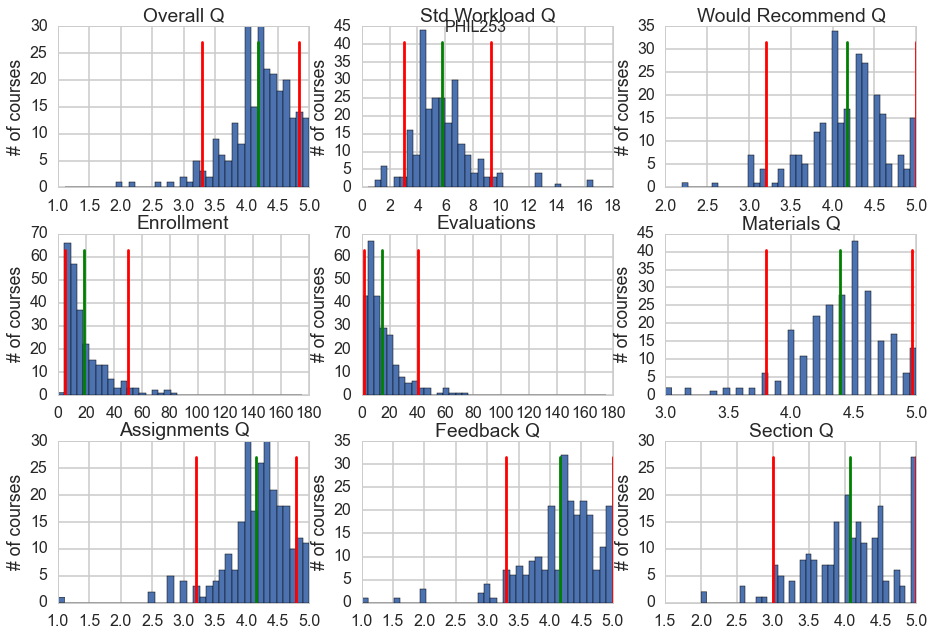

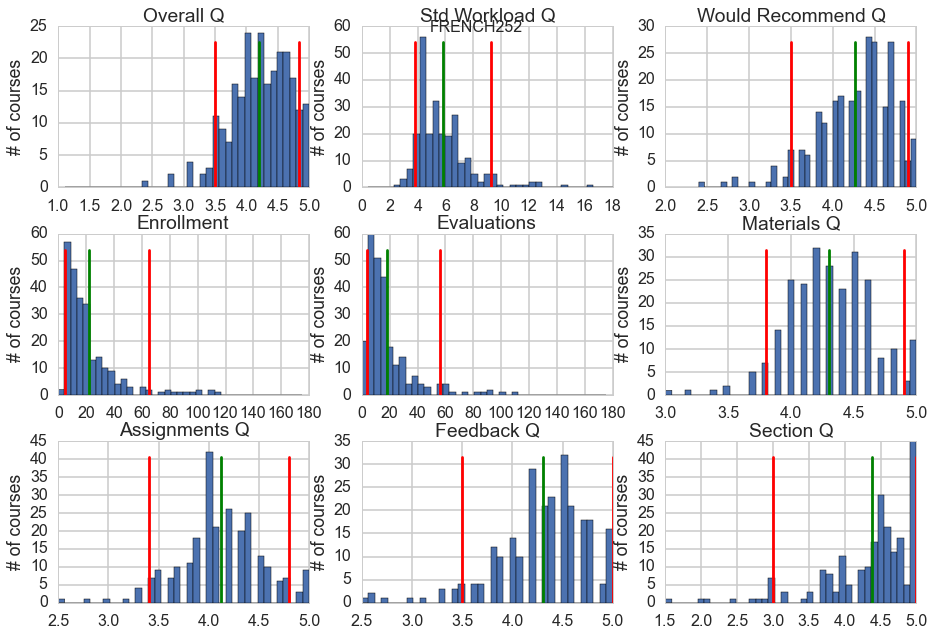

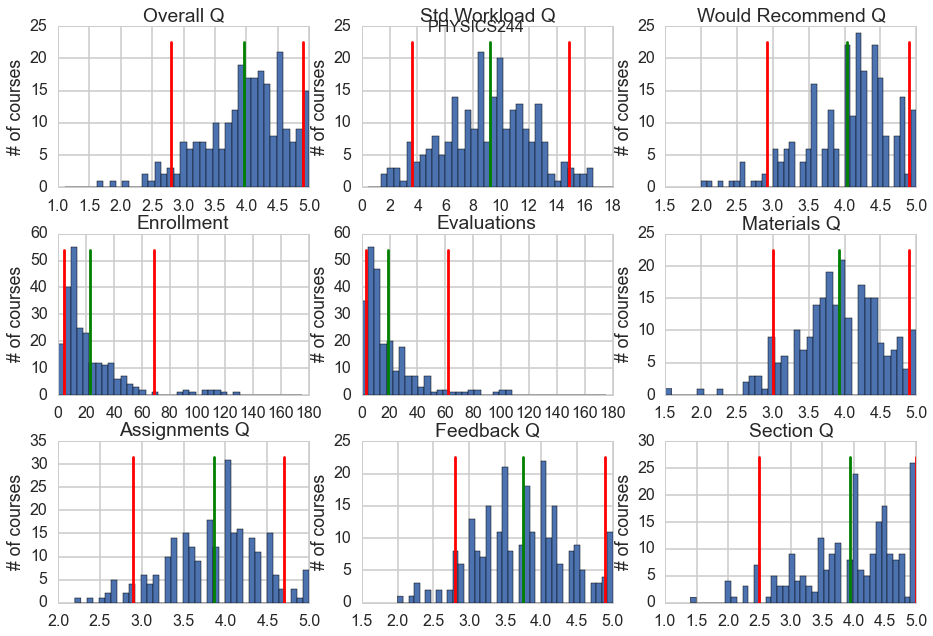

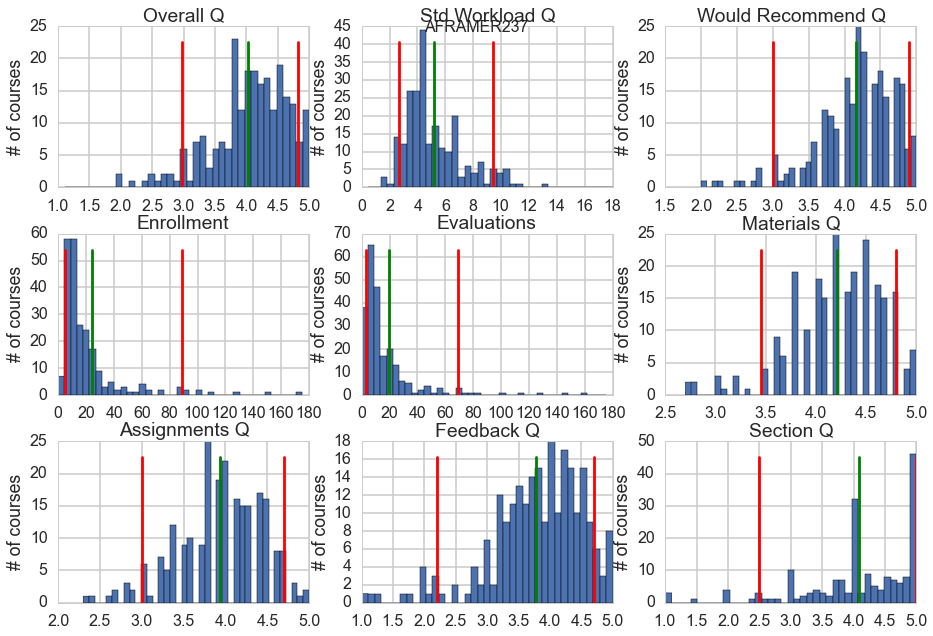

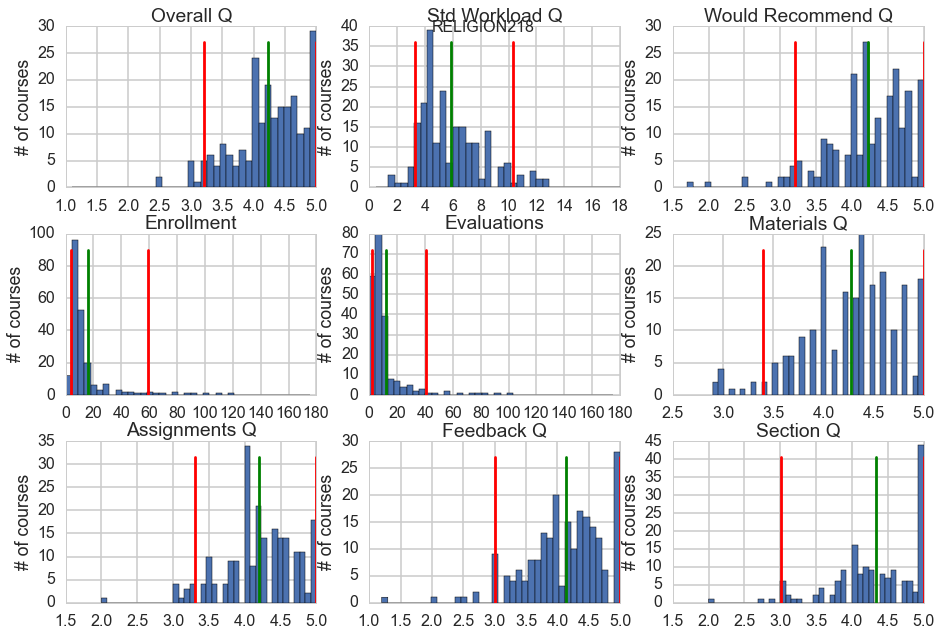

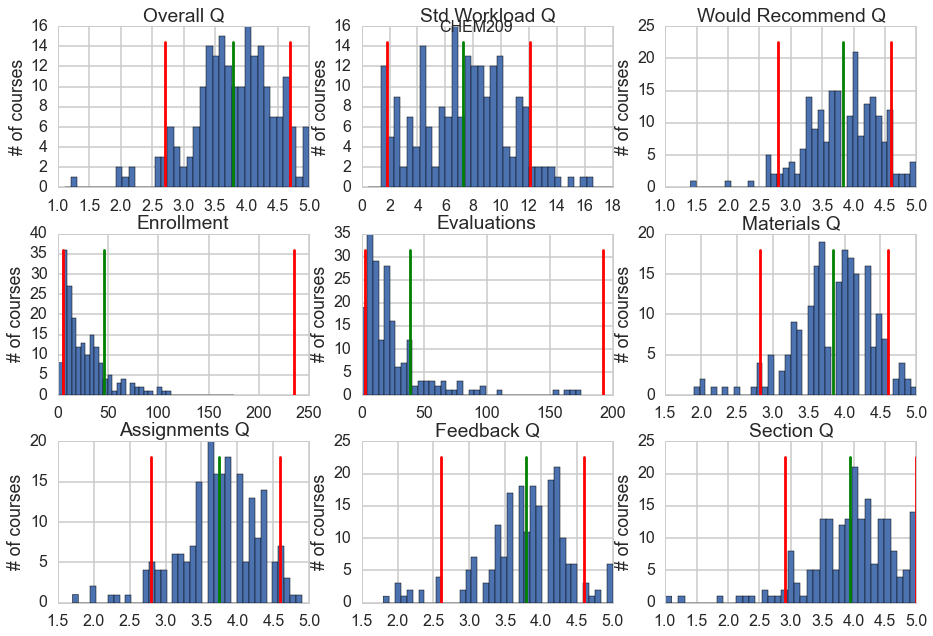

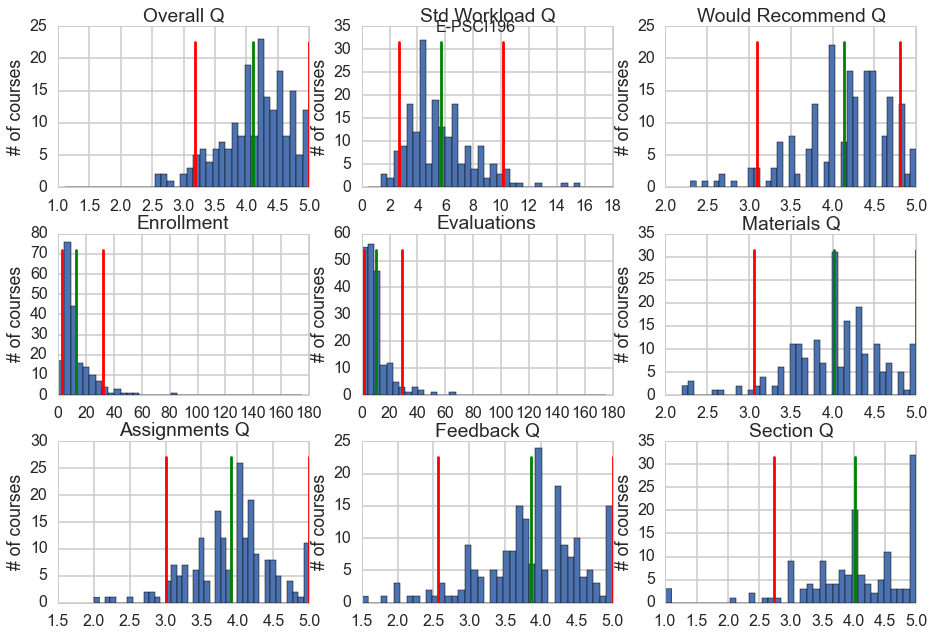

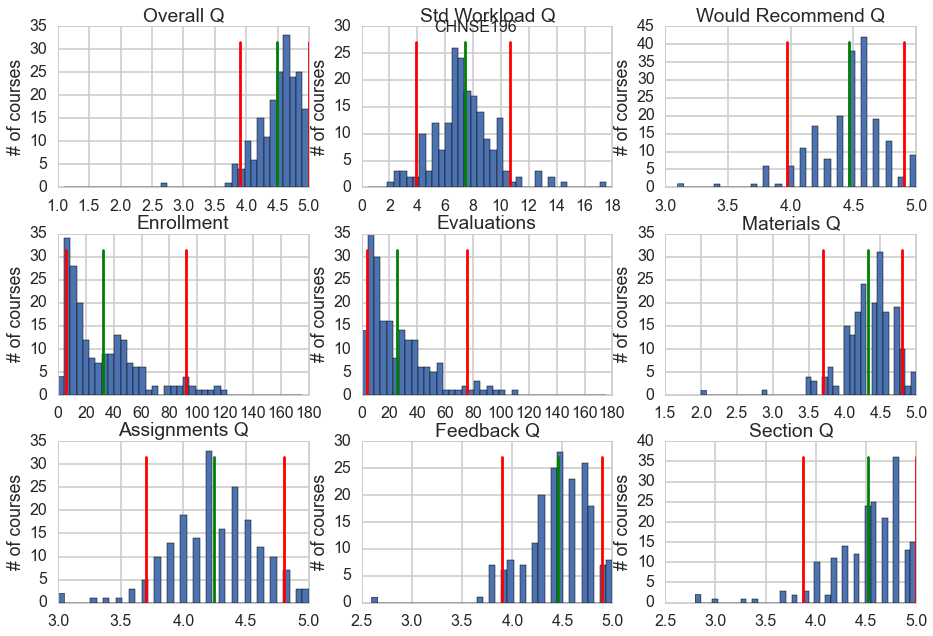

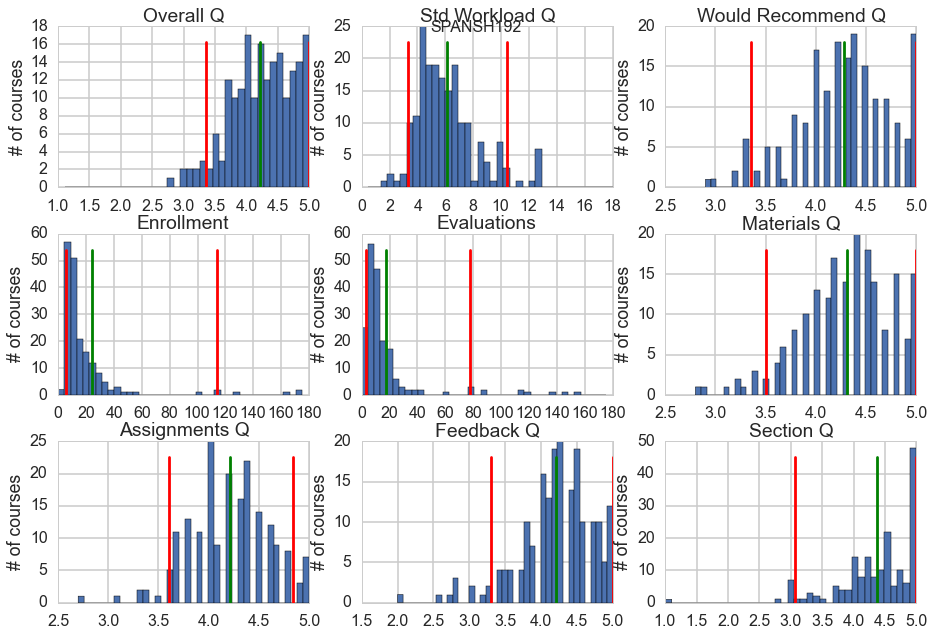

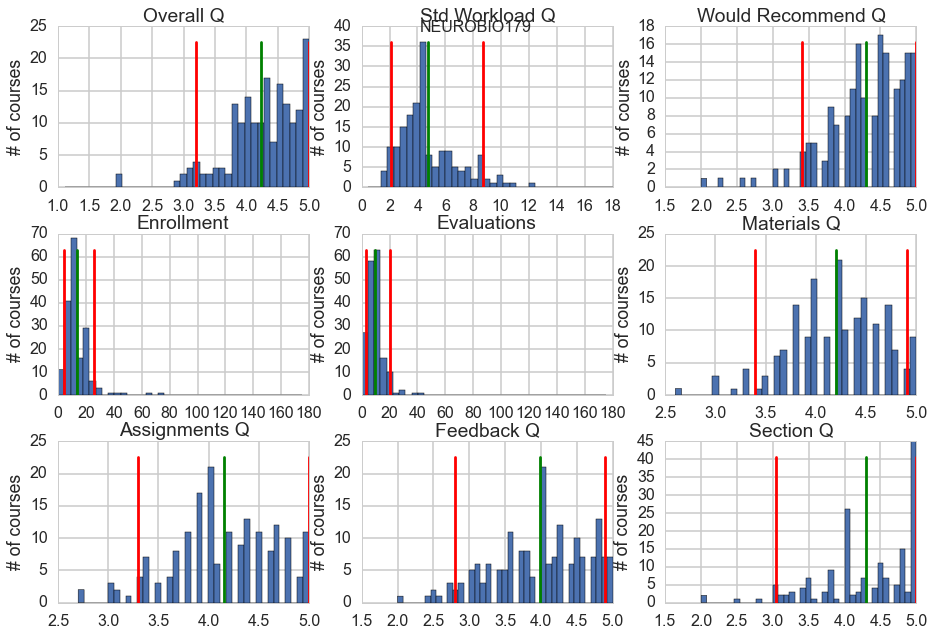

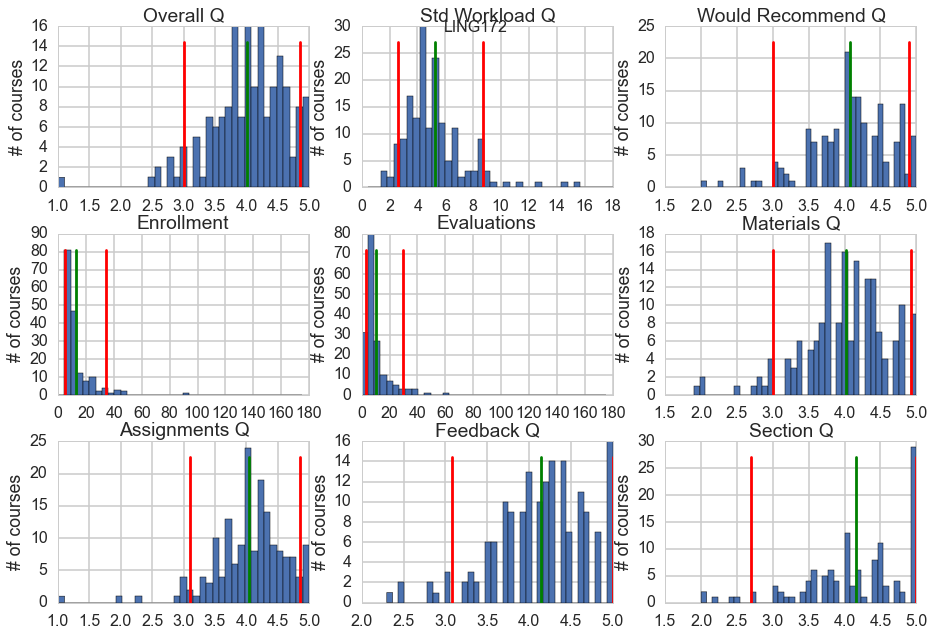

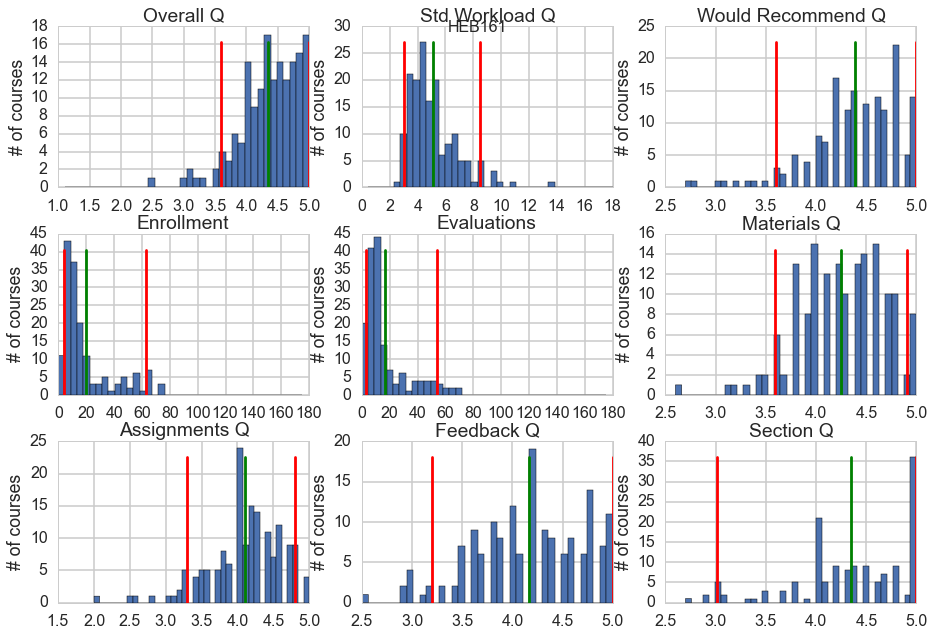

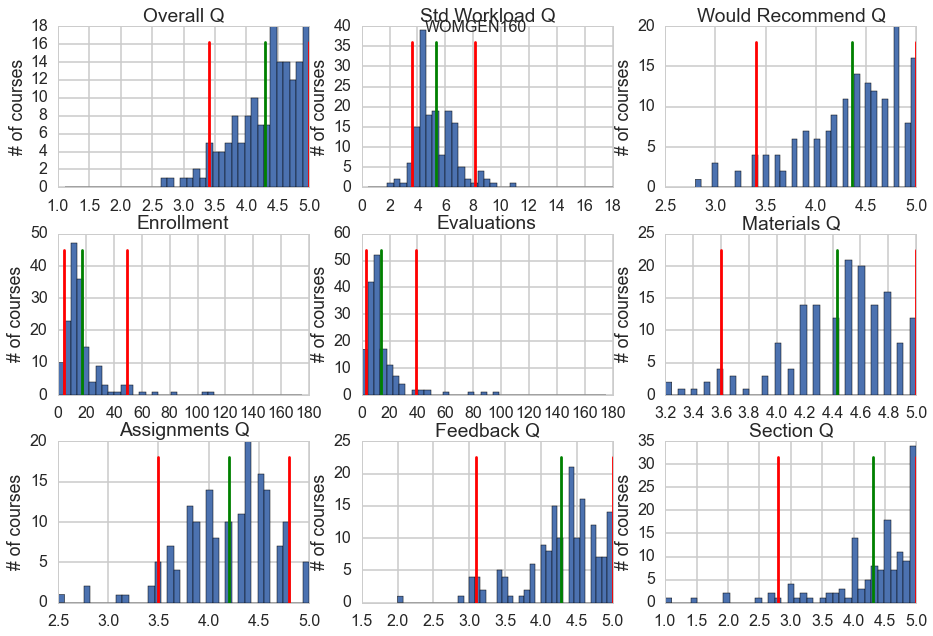

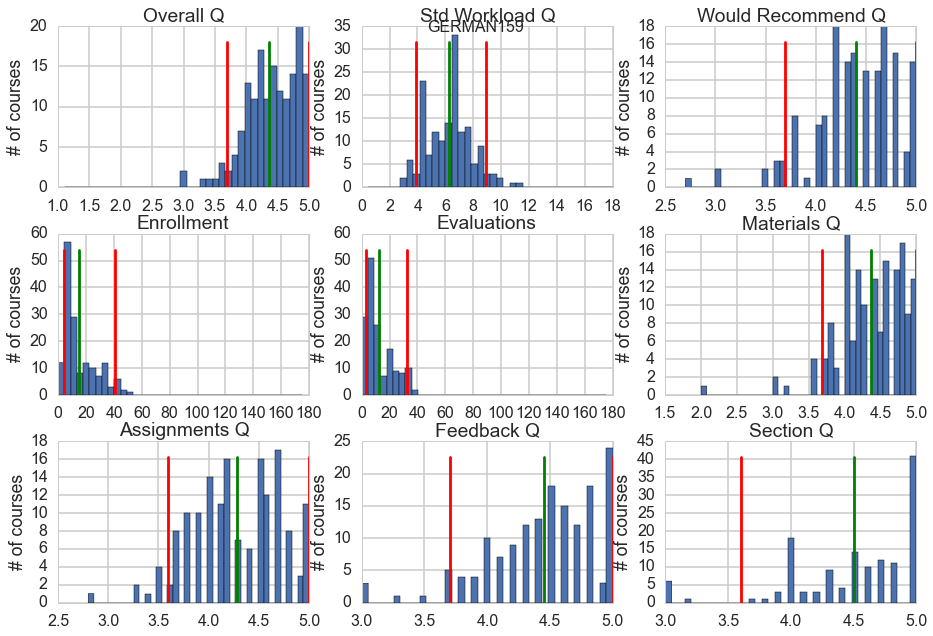

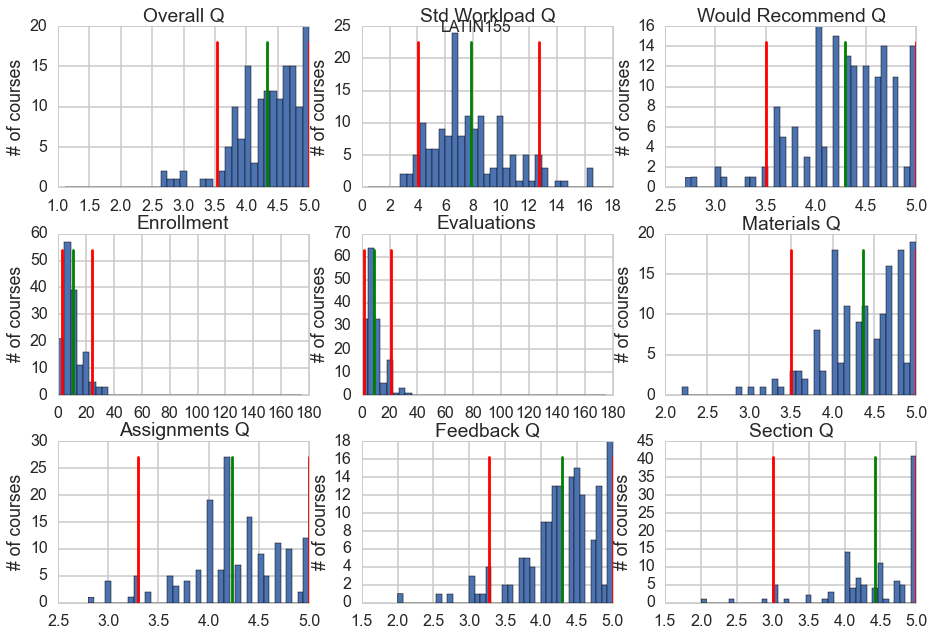

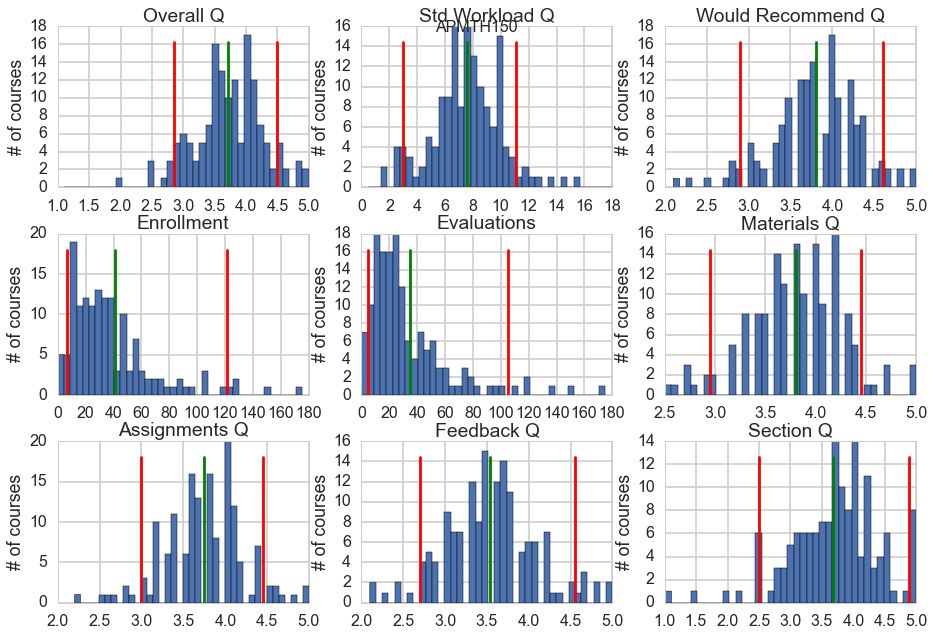

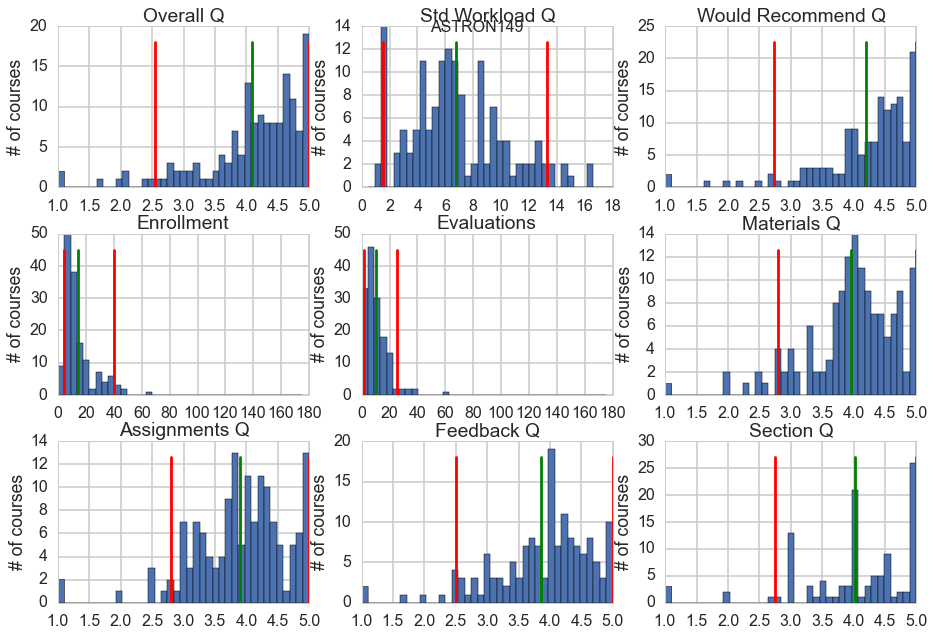

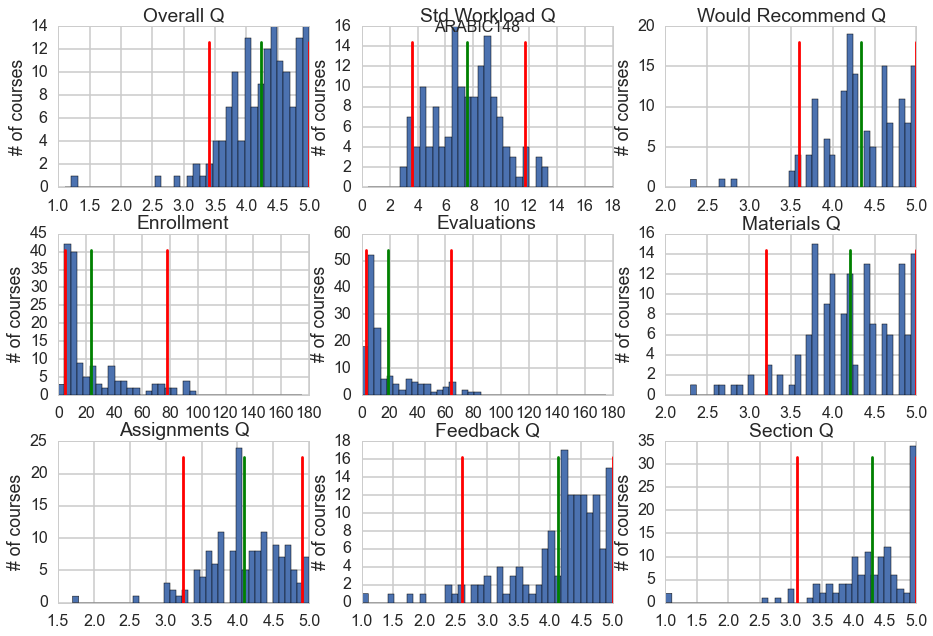

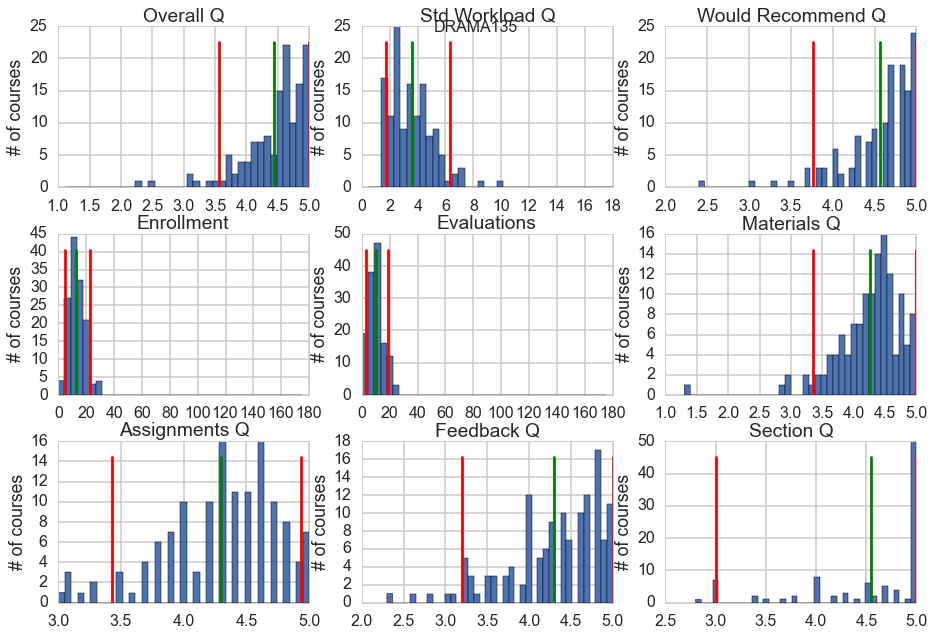

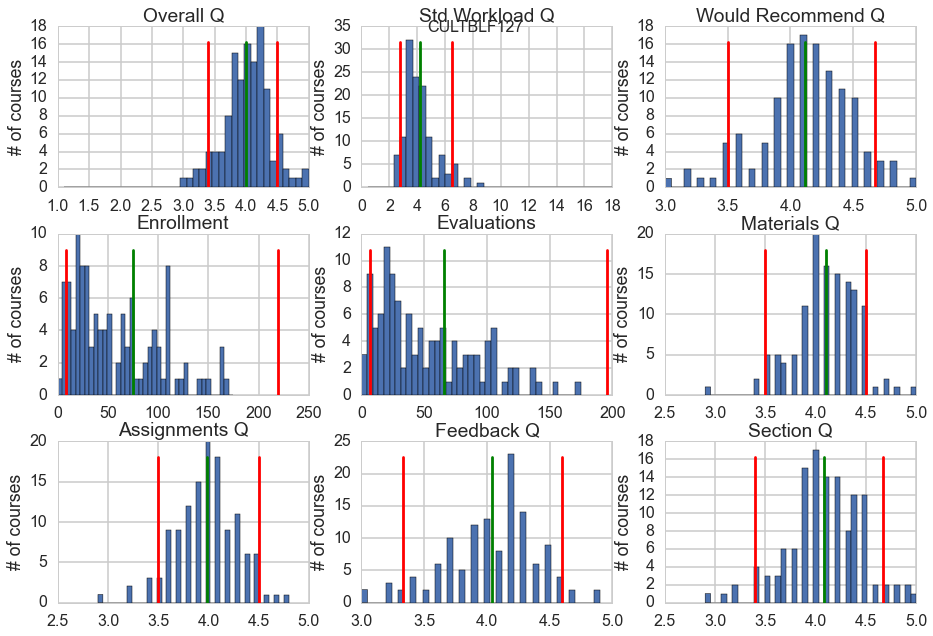

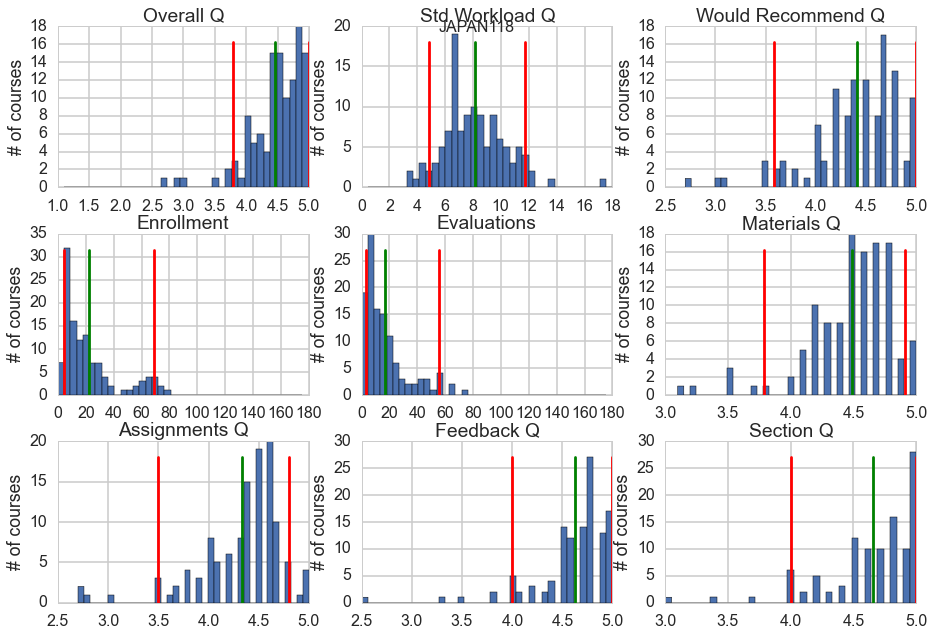

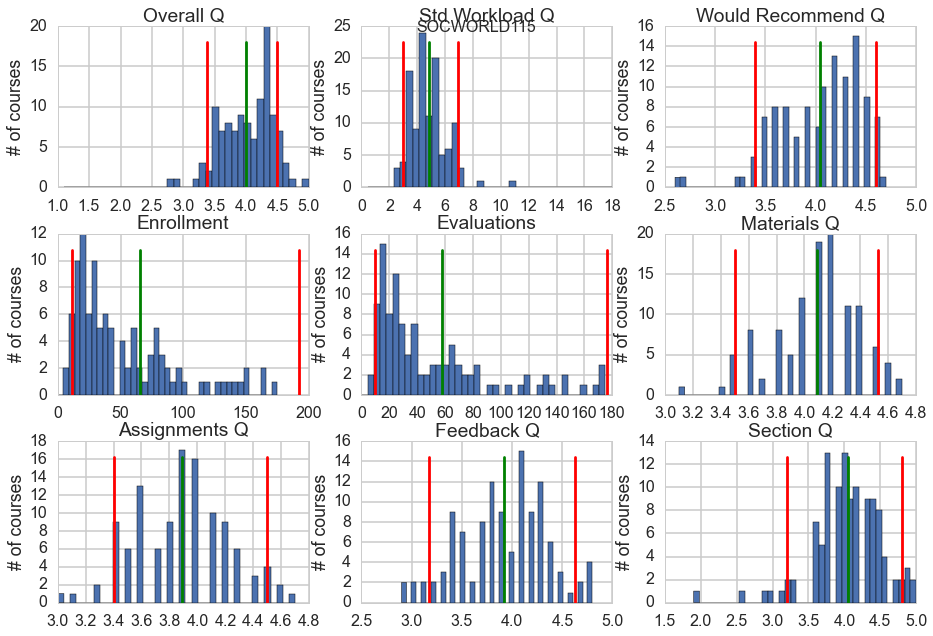

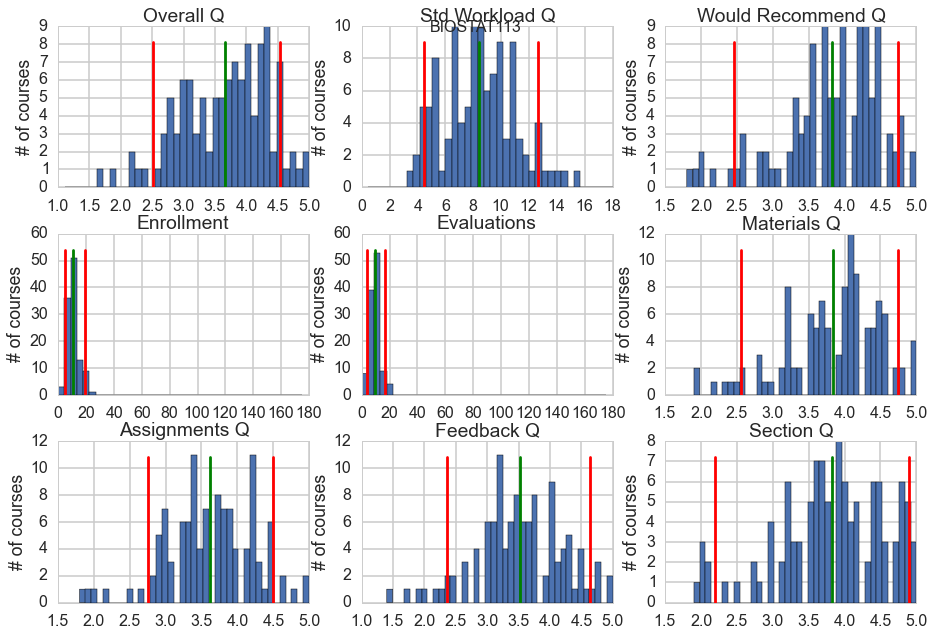

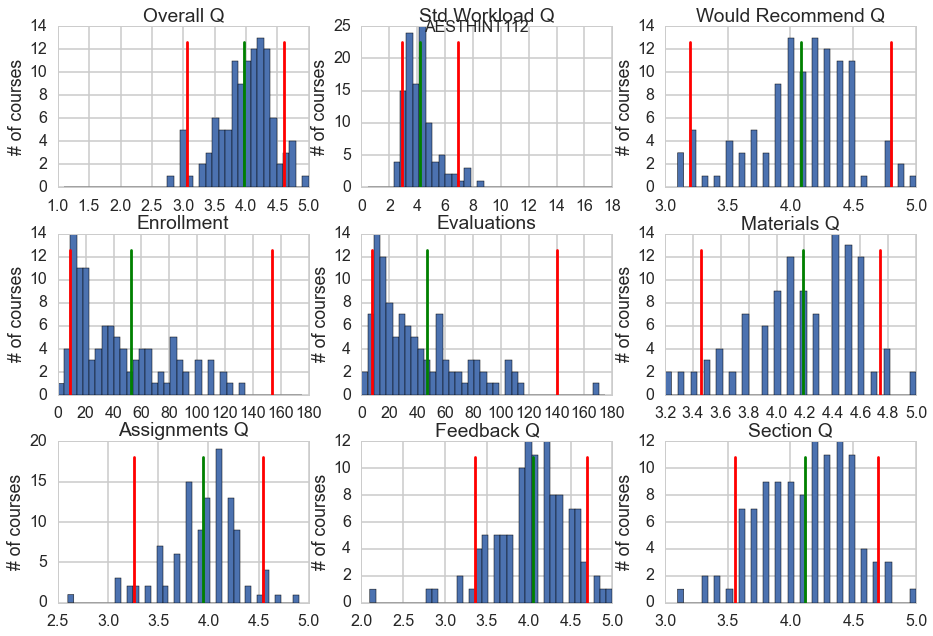

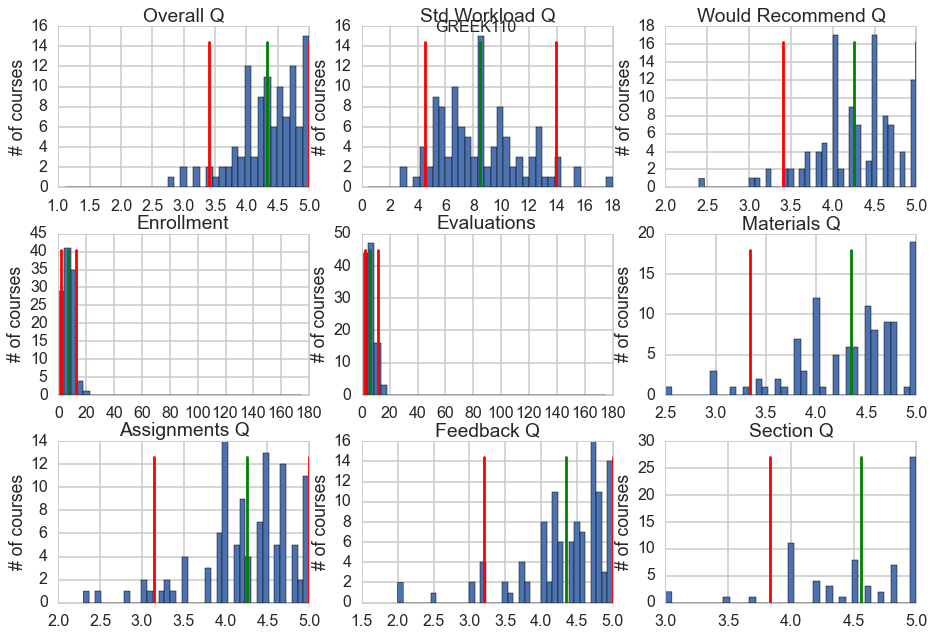

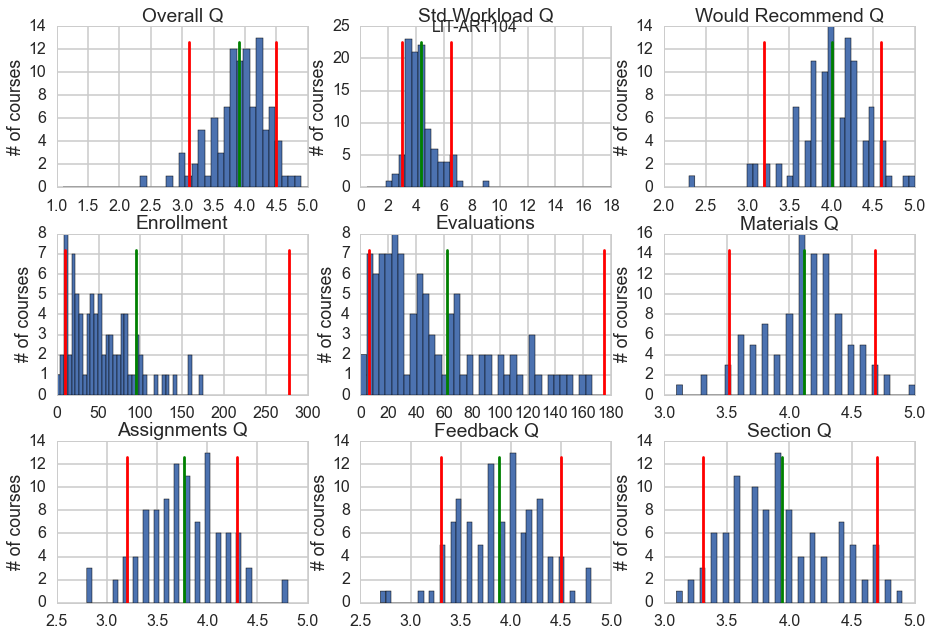

In [15]:
allcats = df['Course Category'].value_counts()
allcatsFloored = [v for v in allcats if v >= 100]
print allcatsFloored #len(allcatsFloored)
catsFloorWithInd = allcats[:47]
for cat in catsFloorWithInd.keys():
    minedf = df[df['Course Category'] == cat]
    thetitle = cat + str(len(minedf))
    histogramColsOnDF(minedf, alltitle=thetitle)

######Analyzing each of the largest categories

FRSEMR with 1011 classes tops the list. 3 hours less than average workload. expected
HIST 1 hours more workload than avg, avg rest
ECON -0.2 overall, 0.5 workload +, others -0.5
GOV avg, EXPOS mostly avg
PSY classes have approximately 1 hour mean less workload than average.
VES and MATH classes are 0.3 overall higher, 0.5 for most others, but 1.8 hours more workload.
MUSIC, ANTHRO classes have slightly higher workload and overall, and +0.5 for most others.
SOCIOL is basically average.
ENG-SCI: classes suck. 0.4 worse overall, 1.5 more hours workload, -0.4 in most others.
STAT: 0.2 worse overall, 0.5 hours more workload, -0.1 for most others
HAA, HISTSCI: 0.5 hours less workload, average rest
COMPSCI: 3 hours more workload, 0.5- feedback and section, avg rest
OEB: 1.5 hours less workload, average rest


### Enrollment

In [16]:
enrol = bothdf.sort('Enrollment', ascending=False)
xxx = enrol.drop(enrol.columns[range(9,22)], axis=1)
xxx = xxx.drop(xxx.columns[range(4,8)], axis=1)
xxx = xxx.drop(xxx.columns[0], axis=1)
xxx = xxx.reset_index()
xxx = xxx.drop(xxx.columns[range(0,2)], axis=1)
xxx.head(20)
xxx.head(10)

Course Number                                       Course Title  Enrollment  Year    Term
0      ECON 10A                            Principles of Economics         711  2014    Fall
1    COMPSCI 50                 Introduction to Computer Science I         696  2014    Fall
2    ETHRSON 18     Classical Chinese Ethical and Political Theory         694  2014    Fall
3      ECON 10B                            Principles of Economics         604  2015  Spring
4    LIFESCI 1A  An Integrated Introduction to the Life Science...         485  2014    Fall
5    LIFESCI 1B  An Integrated Introduction to the Life Science...         446  2015  Spring
6    ECON 1010B                               Macroeconomic Theory         344  2015  Spring
7      PHYSCI 1  Chemical Bonding, Energy, and Reactivity: An I...         326  2015  Spring
8      STAT 110                        Introduction to Probability         320  2014    Fall
9    CULTBLF 34  Madness and Medicine: Themes in the History of...         315  2014    Fall

In [17]:
#pd.set_option('display.max_rows', 150)
enrol = df.sort('Enrollment', ascending=False)
xxx = enrol.drop(enrol.columns[range(9,22)], axis=1)
xxx = xxx.drop(xxx.columns[range(4,8)], axis=1)
xxx = xxx.drop(xxx.columns[0], axis=1)
xxx = xxx.reset_index()
xxx = xxx.drop(xxx.columns[range(0,2)], axis=1)
xxx.head(20)
xxx.head(10)

Course Number                                    Course Title  Enrollment  Year  Term
0   MOR-REAS 22                                         Justice        1072  2007  Fall
1   SOC-ANAL 10                         Principles of Economics         947  2006  Fall
2   MOR-REAS 22                                         Justice         872  2008  Fall
3   SOC-ANAL 10                         Principles of Economics         812  2007  Fall
4    ETHRSON 22                                         Justice         797  2010  Fall
5       ECON 10                         Principles of Economics         776  2010  Fall
6   SOC-ANAL 10                         Principles of Economics         765  2008  Fall
7      ECON 10A                         Principles of Economics         762  2013  Fall
8    ETHRSON 18  Classical Chinese Ethical and Political Theory         723  2013  Fall
9       ECON 10                         Principles of Economics         722  2011  Fall

In [18]:
enrol = bothdf.sort('Enrollment', ascending=False)
enrol = enrol[enrol['Course Category'] == 'ETHRSON']
xxx = enrol.drop(enrol.columns[range(9,22)], axis=1)
xxx = xxx.drop(xxx.columns[range(4,8)], axis=1)
xxx = xxx.drop(xxx.columns[0], axis=1)
xxx = xxx.reset_index()
xxx = xxx.drop(xxx.columns[range(0,2)], axis=1)
xxx.head(40)
#xxx.head(10)
#ETHRSON

Course Number                                       Course Title  Enrollment  Year    Term
0     ETHRSON 18     Classical Chinese Ethical and Political Theory         694  2014    Fall
1     ETHRSON 33                         Medical Ethics and History         193  2014    Fall
2     ETHRSON 39                         Money, Markets, and Morals         186  2014    Fall
3     ETHRSON 38                                The Meaning of Life         116  2015  Spring
4     ETHRSON 30                                     The Just World         115  2014    Fall
5     ETHRSON 32                     Security: Carefree or Careless          82  2014    Fall
6     ETHRSON 37                                         Adam & Eve          62  2015  Spring
7     ETHRSON 31                     The Philosopher and the Tyrant          48  2014    Fall
8     ETHRSON 15  If There is No God, All is Permitted: Theism a...          34  2014    Fall
9     ETHRSON 34                                            Liberty          18  2015  Spring
10    ETHRSON 17  Ethics, Religion, and Violence in Comparative ...          18  2015  Spring

In [19]:
print enrol['Enrollment'].sum() #1352 for fall, 214 for spring
print enrol[enrol['Term'] == 'Spring']['Enrollment'].sum()

1566.0
214.0


#### Enrollment Chart

In [123]:
def getEnrollmentChart(df):
    alltehcats = {}
    alltehcatsnw = {}
    for _, course in df.iterrows():
        if not math.isnan(course['Enrollment']): #damn nan
            alltehcats[course['Course Category']] = alltehcats.get(course['Course Category'], 0) + course['Enrollment']
        alltehcatsnw[course['Course Category']] = alltehcatsnw.get(course['Course Category'], 0) + 1
    return (alltehcats, alltehcatsnw)
#alltehcats, alltehcatsnw = getEnrollmentPieChart(df)
alltehcats, alltehcatsnw = getEnrollmentChart(df)


['SOCWORLD', 'ECON', 'CHEM', 'CHNSE', 'RELIGION', 'BIOSTAT', 'HAA', 'APMTH', 'SPANSH', 'SOC-STD', 'STAT', 'FRENCH', 'LING', 'ENGLISH', 'AFRAMER', 'HIST', 'WOMGEN', 'SOCIOL', 'ENG-SCI', 'ASTRON', 'PSY', 'JAPAN', 'MATH', 'SLAVIC', 'HISTSCI', 'ITAL', 'PHYSICS', 'LATIN', 'PHIL', 'E-PSCI', 'VES', 'GERMAN', 'DRAMA', 'COMPSCI', 'HEB', 'NEUROBIO', 'SCRB', 'OEB', 'FRSEMR', 'LIT-ART', 'GOV', 'MCB', 'GREEK', 'ANTHRO', 'CULTBLF', 'EXPOS', 'MUSIC', 'ARABIC', 'AESTHINT']
[115, 921, 209, 196, 218, 113, 314, 150, 192, 262, 312, 252, 172, 697, 237, 945, 160, 438, 426, 149, 506, 118, 496, 268, 312, 101, 244, 155, 253, 196, 490, 159, 135, 304, 161, 179, 102, 298, 1072, 104, 896, 284, 110, 480, 127, 664, 441, 148, 112]
ITAL         101
SCRB         102
LIT-ART      104
GREEK        110
AESTHINT     112
BIOSTAT      113
SOCWORLD     115
JAPAN        118
CULTBLF      127
DRAMA        135
ARABIC       148
ASTRON       149
APMTH        150
LATIN        155
GERMAN       159
WOMGEN       160
HEB          161
LI

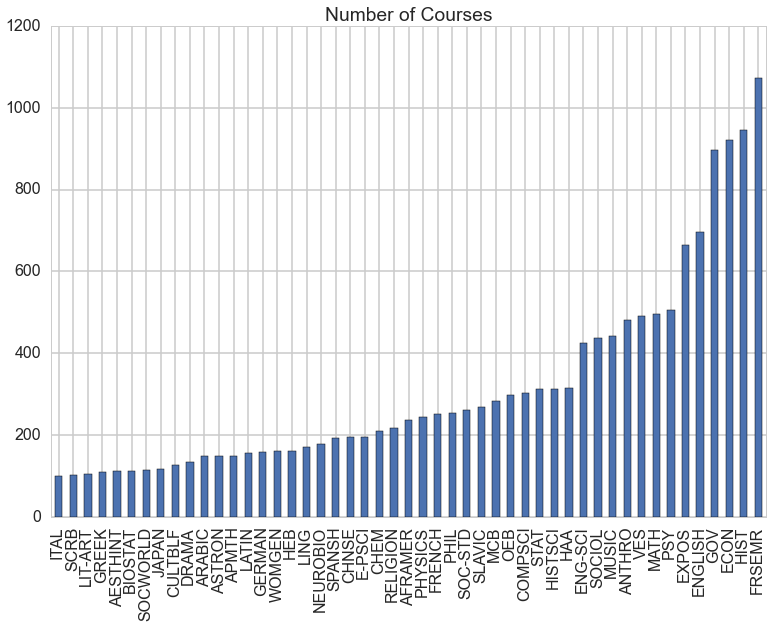

In [124]:
co = []
va = []
other = 0
for k, v in alltehcatsnw.iteritems():
    if v > 100:
        co.append(k)
        va.append(v)
 #   elif v > 1:
  #      other += v
#co.append('Other')
#va.append(other)
series = pd.Series(va, index=co, name='Number of Courses')
series.sort()
print co
print va
print series

series.plot(kind='bar', title='Number of Courses')#, figsize=(6, 6))

In [125]:
import math
math.isnan(alltehcats['ECON'])

False

['SOCWORLD', 'ECON', 'CHEM', 'CHNSE', 'RELIGION', 'HAA', 'APMTH', 'SPANSH', 'SOC-STD', 'STAT', 'FRENCH', 'ENGLISH', 'ETHRSON', 'AFRAMER', 'HIST', 'SOCIOL', 'SCIENCE', 'ENG-SCI', 'PSY', 'MOR-REAS', 'MATH', 'SOC-ANAL', 'HISTSCI', 'LIFESCI', 'SCIPHUNV', 'SCILIVSY', 'PHYSICS', 'PHIL', 'VES', 'COMPSCI', 'HEB', 'OEB', 'FRSEMR', 'LIT-ART', 'GOV', 'PHYSCI', 'MCB', 'ANTHRO', 'CULTBLF', 'EXPOS', 'MUSIC', 'ARABIC', 'HIS-STD', 'AESTHINT', 'US-WORLD']
[7547.0, 35234.0, 9433.0, 6277.0, 3469.0, 6945.0, 6175.0, 4703.0, 4239.0, 11362.0, 5527.0, 17510.0, 7603.0, 5737.0, 15216.0, 13560.0, 5402.0, 7203.0, 14150.0, 4375.0, 11538.0, 7549.0, 6406.0, 10411.0, 5380.0, 3648.0, 5624.0, 4703.0, 5609.0, 15249.0, 3155.0, 5895.0, 11121.0, 9802.0, 27261.0, 7375.0, 9746.0, 8173.0, 9544.0, 9604.0, 7598.0, 3456.0, 6406.0, 5880.0, 4931.0]
HEB          3155
ARABIC       3456
RELIGION     3469
SCILIVSY     3648
SOC-STD      4239
MOR-REAS     4375
SPANSH       4703
PHIL         4703
US-WORLD     4931
SCIPHUNV     5380
SCIEN

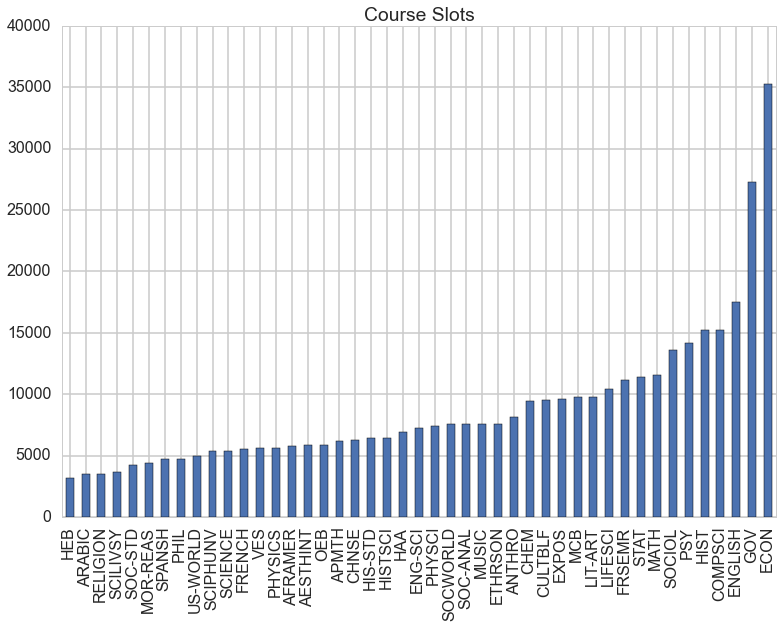

In [149]:
co = []
va = []
other = 0
for k, v in alltehcats.iteritems():
    if v > 3000:
        co.append(k)
        va.append(v)
 #   elif v > 1:
  #      other += v
#co.append('Other')
#va.append(other)
series = pd.Series(va, index=co, name='Course Slots')
series.sort()
print co
print va
print series

series.plot(kind='bar', title='Course Slots')#, figsize=(6, 6))

In [148]:
co = []
va = []
other = 0
for k, v in alltehcats.iteritems():
#    if v > 0:
    co.append(k)
    va.append(v)
 #   elif v > 1:
  #      other += v
#co.append('Other')
#va.append(other)
series = pd.Series(va, index=co, name='Enrollment')
series.sort()
print co
print va
print series
print len(va)
va.sort()
ensum = 0
for i in xrange(0, 136):
    ensum += va[i]
print ensum
print ensum/136
#series.plot(kind='bar', title='Enrollment')#, figsize=(6, 6))

['SWEDISH', 'BE', 'GEN-ED', 'SOCWORLD', 'APPHY', 'WOM-STD', 'ECON', 'LIT', 'MEDGREEK', 'DUTCH', 'ESPP', 'CHEM', 'CHNSE', 'AMSTDIES', 'BIOPHYS', 'NEPALI', 'CLASSIC', 'RELIGION', 'BIOSTAT', 'HUMAN', 'SAS', 'TAM', 'YIDDISH', 'URD', 'NEP', 'SCTGALIC', 'HAA', 'UKRAN', 'LPS', 'BIOLOGY', 'MEDLATIN', 'IRANCIV', 'APMTH', 'THI', 'SPANSH', 'SYSTBIO', 'MOD-HEB', 'CELTIC', 'UYGHUR', 'LITERTRE', 'PAL', 'UKRA', 'VIROLOGY', 'SOC-STD', 'GERM-STD', 'SWAHILI', 'STAT', 'HSEMR-EL', 'HBTM', 'HSEMR-MA', 'SPOL', 'MONGOLN', 'FRENCH', 'LING', 'VIETNAM', 'HSEMR-LE', 'SANSKRT', 'ENGLISH', 'CHNSLING', 'DRB', 'HSEMR-LO', 'MED-SCI', 'WELSH', 'ETHRSON', 'CLAS-HEB', 'AFRAMER', 'EABS', 'HIST', 'WOMGEN', 'ROM-STD', 'SOCIOL', 'HSEMR-WI', 'ROM-LANG', 'SCIENCE', 'ENG-SCI', 'QNT-REAS', 'ASTRON', 'PORTUG', 'RSRA', 'ANE', 'SHBT', 'TIBETAN', 'EMREAS', 'GERMPHIL', 'GENETIC', 'CATALAN', 'PSY', 'CHEMBIO', 'PALI', 'JAPAN', 'MOR-REAS', 'MODMDEST', 'MATH', 'SOC-ANAL', 'SLAVIC', 'HISTSCI', 'IRANIAN', 'SCAND', 'KORHIST', 'ITAL', 'NEC'

AttributeError: 'float' object has no attribute 'mean'

### Workload

In [23]:
xxx = df.sort('Std Workload Q', ascending=False) #oh my god I forgot to sort by std workload q instead of workload q
usilly = xxx[xxx['Enrollment'] > 30]

xxx = xxx.drop(xxx.columns[range(7,24)], axis=1)
xxx = xxx.drop(xxx.columns[range(4,6)], axis=1)
xxx = xxx.drop(xxx.columns[0], axis=1)
xxx = xxx.reset_index()
xxx = xxx.drop(xxx.columns[range(0,2)], axis=1)
display(xxx.head(10))

#axxx = usilly.drop(usilly.columns[range(7,24)], axis=1)
axxx = usilly.drop(usilly.columns[range(7,22)], axis=1)
axxx = axxx.drop(axxx.columns[range(4,6)], axis=1)
axxx = axxx.drop(axxx.columns[0], axis=1)
axxx = axxx.reset_index()
axxx = axxx.drop(axxx.columns[range(0,2)], axis=1)
display(axxx.head(10))



Course Number                                   Course Title  Std Workload Q
0    COMPSCI 161                              Operating Systems            30.3
1      HIST 2272                      The Soviet Union: Seminar            26.7
2   PHYSICS 253B                        Quantum Field Theory II            25.4
3        MCB 293  Biochemistry, Chemical and Structural Biology            23.7
4      APPHY 282                  Solids: Structure and Defects            22.8
5  PHYSICS 287BR                        Topics in String Theory            22.0
6   PHYSICS 287A                  Introduction to String Theory            22.0
7       MATH 55B               Honors Real and Complex Analysis            20.6
8       SHBT 205          Neural Coding and Perception of Sound            20.1
9    ENG-SCI 289               Innovation and National Security            20.0

Course Number                                   Course Title  Std Workload Q  Year    Term
0   COMPSCI 124                 Data Structures and Algorithms            18.6  2015  Spring
1    ECON 2010A                                Economic Theory            17.9  2014    Fall
2   COMPSCI 161                              Operating Systems            16.5  2013  Spring
3   COMPSCI 171                                  Visualization            16.1  2015  Spring
4  PHYSICS 253A                         Quantum Field Theory I            15.8  2014    Fall
5   COMPSCI 207  Systems Development for Computational Science            15.6  2014    Fall
6      MATH 25A      Honors Linear Algebra and Real Analysis I            15.5  2014    Fall
7    COMPSCI 51            Introduction to Computer Science II            15.4  2015  Spring
8      GOV 2000         Introduction to Quantitative Methods I            15.3  2007    Fall
9      MATH 25B     Honors Linear Algebra and Real Analysis II            14.9  2010  Spring

In [24]:
xxx = df.sort('Std Workload Q', ascending=False)
usilly = xxx[xxx['Enrollment'] > 259]

#axxx = usilly.drop(usilly.columns[range(7,24)], axis=1)
#axxx = usilly.drop(usilly.columns[range(7,22)], axis=1)
axxx = usilly.drop(usilly.columns[range(9,22)], axis=1)
axxx = axxx.drop(usilly.columns[7], axis=1)
axxx = axxx.drop(axxx.columns[range(4,6)], axis=1)
axxx = axxx.drop(axxx.columns[0], axis=1)
axxx = axxx.reset_index()
axxx = axxx.drop(axxx.columns[range(0,2)], axis=1)
display(axxx.head(10))

Course Number                         Course Title  Std Workload Q  Enrollment  Year    Term
0    COMPSCI 51  Introduction to Computer Science II            15.4         312  2015  Spring
1    COMPSCI 50   Introduction to Computer Science I            14.2         696  2014    Fall
2    COMPSCI 50   Introduction to Computer Science I            13.3         488  2010    Fall
3    COMPSCI 50   Introduction to Computer Science I            13.3         330  2008    Fall
4    COMPSCI 50   Introduction to Computer Science I            12.9         336  2009    Fall
5    COMPSCI 50   Introduction to Computer Science I            12.9         604  2011    Fall
6    COMPSCI 50   Introduction to Computer Science I            12.5         701  2012    Fall
7    COMPSCI 50   Introduction to Computer Science I            12.5         583  2013    Fall
8    COMPSCI 50   Introduction to Computer Science I            11.3         282  2007    Fall
9      STAT 110          Introduction to Probability            10.5         449  2013    Fall

#### Category Workloads

In [25]:
cs50pls = df[df['Course Number'] == 'COMPSCI 50']
usedhours = 0
for _, c in cs50pls.iterrows():
    usedhours += c['Enrollment'] * c['Std Workload Q']
print usedhours

57017.8


In [26]:
cs50pls = df[df['Course Number'] == 'ECON 10A']
usedhours = 0
for _, c in cs50pls.iterrows():
    usedhours += c['Enrollment'] * c['Std Workload Q']
print usedhours

10092.6


In [27]:
dfcat = df[df['Course Category'] == 'COMPSCI']
dfcat['hmm'] = dfcat['Enrollment'] * dfcat['Std Workload Q']
dfcat['hmm'].sum()

/Users/Roger/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


161705.39999999994

In [28]:
#this is dumb and pointless, a meaningless statistic
co = getCategories(df)
va = []
other = 0
for cat in co:
    dfcat = df[df['Course Category'] == cat]
    dfcat['totalwork'] = dfcat['Enrollment'] * dfcat['Std Workload Q']
    #co.append(cat)
    va.append(dfcat['totalwork'].sum())
 #   elif v > 1:
  #      other += v
#co.append('Other')
#va.append(other)
series = pd.Series(va, index=co, name='Total Workloads')
series.sort()

/Users/Roger/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
series

SALLC            0.0
HSEMR-LO         9.0
TAMIL            9.0
GIKUYU           9.0
TIBHIST         13.5
MONGOLN         13.5
CHNSLING        18.0
PAL             18.0
UKRAN           19.5
CATALAN         24.0
UKRA            29.5
IRANCIV         38.1
NORWGN          42.1
PALI            42.5
NEPALI          42.9
SCTGALIC        43.1
DUTCH           43.2
SPOL            43.5
GERM-STD        45.5
BUSSTUD         52.0
GERMPHIL        53.8
SEMPHIL         58.5
PATHOL          62.1
HSEMR-MA        78.1
EGYPTIAN        89.9
MES             93.1
ARAMAIC         96.2
NEP             98.5
HSEMR-CU       111.9
HINDI          114.0
              ...   
HIS-STD      30302.7
HISTSCI      31323.4
HAA          31722.2
FRSEMR       33838.1
SOC-STD      33866.6
SOCWORLD     34397.4
CULTBLF      36056.3
MUSIC        36754.6
SOC-ANAL     38309.9
LIT-ART      39803.9
VES          40475.9
ANTHRO       43327.9
APMTH        45835.0
CHNSE        49198.6
PHYSCI       51813.1
PHYSICS      51949.7
ENG-SCI      

In [30]:
sssss = df[df['Std Workload Q'] > 16.6]
print len(sssss)

24


### Sorting

In [31]:
def sortthedf(thedf, overall=3.7, recommend=3.7, enrollment=15):
    thedf = thedf.sort(['Workload Q', 'Overall Q', 'Would Recommend Q', 'Evaluations'], ascending=[True, False, False, False]
                                        )
    thedf = thedf[thedf['Enrollment'] > enrollment]
    thedf = thedf[thedf['Overall Q'] > overall]
    thedf = thedf[thedf['Would Recommend Q'] > recommend]
    return thedf
sortedbothdf = sortthedf(bothdf)

## Customizable-Sorting

In [32]:
df.columns

Index([u'Unnamed: 0', u'Course Category', u'Course Number', u'Course Title', u'Overall Q', u'Workload Q', u'Std Workload Q', u'Would Recommend Q', u'Enrollment', u'Evaluations', u'Response Rate', u'Materials Q', u'Assignments Q', u'Feedback Q', u'Section Q', u'Elective Reason', u'Concentration Req Reason', u'Secondary Field or Language Req Reason', u'Undeergrad Core or Gen Ed Req Reason', u'Expos Req Reason', u'Foreign Lang Req Reason', u'Pre-Med Req Reason', u'Year', u'Term'], dtype='object')

In [33]:
def bettersort(thedf,\
               sortbytup=(['Workload Q', 'Overall Q', 'Would Recommend Q', 'Evaluations'],[True, False, False, False]),\
               categories=[],\
               minoverall=0, maxworkload=0, minrecommend=0, minenrollment=0,\
               minmaterials=0, minassignments=0, minfeedback=0, minsection=0, coursetitle=None):
    cols,asc = sortbytup
    thedf = thedf.sort(cols, ascending=asc)
    if coursetitle: return thedf[thedf['Course Number'] == coursetitle]
    if len(categories): thedf=thedf[thedf['Course Category'].isin(categories)]
    if minoverall: thedf = thedf[thedf['Overall Q'] > minoverall]
    if maxworkload: thedf = thedf[thedf['Workload Q'] < maxworkload]
    if minenrollment: thedf = thedf[thedf['Enrollment'] > minenrollment]
    if minrecommend: thedf = thedf[thedf['Would Recommend Q'] > minrecommend]
    if minmaterials: thedf = thedf[thedf['Materials Q'] > minmaterials]
    if minassignments: thedf = thedf[thedf['Assignments Q'] > minassignments]
    if minfeedback: thedf = thedf[thedf['Feedback Q'] > minfeedback]
    if minsection: thedf = thedf[thedf['Section Q'] > minsection]
    return thedf

In [34]:
bettersort(df)

Unnamed: 0 Course Category     Course Number                                       Course Title  Overall Q  Workload Q  Std Workload Q  Would Recommend Q  Enrollment  Evaluations  Response Rate  Materials Q  Assignments Q  Feedback Q  Section Q  Elective Reason  Concentration Req Reason  Secondary Field or Language Req Reason  Undeergrad Core or Gen Ed Req Reason  Expos Req Reason  Foreign Lang Req Reason  Pre-Med Req Reason  Year    Term
1236          305          FRSEMR        FRSEMR 22I                             The Science of Sailing        5.0           1             1.5                5.0          11            7          63.64          4.4            4.8         4.2        4.5              100                         0                                       0                                     0                 0                        0                   0  2007    Fall
3201          348          FRSEMR        FRSEMR 32X                    Topics in Indo-Tibetan Buddhism        5.0           1             1.5                5.0           4            4         100.00          5.0            4.8         4.2        NaN              100                         0                                       0                                     0                 0                        0                   0  2009    Fall
6533          484         GENETIC       GENETIC 219                        Inheritance and Weird Stuff        5.0           1             1.5                5.0           6            4          66.67          3.5            5.0         5.0        NaN               75                        25                                      25                                     0                 0                        0                   0  2012    Fall
12637         373          FRSEMR        FRSEMR 22T               Why We Animals Sing (the ways we do)        5.0           1             1.5                5.0           4            4         100.00          4.8            5.0         5.0        5.0              100                         0                                       0                                     0                 0                        0                   0  2010  Spring
13420          95         CATALAN        CATALAN 20  Catalan Language and Culture: a Multimedia App...        5.0           1             1.5                5.0           4            4         100.00          4.5            4.5         4.5        5.0               75                         0                                      25                                     0                 0                        0                   0  2011  Spring
17454         788           MUSIC        MUSIC 103R  Masterwork: The Choreographic Process of Willi...        5.0           1             1.5                5.0           5            4          80.00          5.0            5.0         4.2        5.0               50                         0                                      50                                     0                 0                        0                   0  2014  Spring
2680          795             PSY          PSY 3490              Advanced Statistical Methods Workshop        5.0           1             1.5                5.0           8            3          37.50          NaN            NaN         NaN        NaN               67                         0                                       0                                     0                 0                        0                   0  2008    Fall
7412          267         ENG-SCI       ENG-SCI 139  Innovation in Science and Engineering: Confere...        5.0           1             1.5                5.0           4            3          75.00          5.0            4.7         4.3        4.7               67                        33                                       0                                     0                 0                 

In [150]:
minoverall = 0
maxworkload = 0
minrecommend = 0
minenrollment = 0


coursetitle=None
sortbytup = (['Workload Q', 'Overall Q', 'Would Recommend Q', 'Enrollment'],[True, False, False, False])
#sortbytup = (['Enrollment', 'Workload Q', 'Overall Q', 'Would Recommend Q'],[False, True, False, False])
minoverall = 3.7
maxworkload = 8.1
minrecommend = 3.8
minenrollment = 15
okcategories = ['ECON', 'GOV', 'PSY', 'VES', 'MUSIC', 'SOCIOL', 'ENG-SCI', 'STAT', 'COMPSCI', 'OEB', 'SOC-STD', 'PHIL', 'HEB', 'APMTH', 'ASTRON']
#okcategories = ['GOV']
abb= bettersort(df, sortbytup=sortbytup, categories=okcategories, minoverall=minoverall, maxworkload=maxworkload,\
           minrecommend=minrecommend, minenrollment=minenrollment)
#ss = abb[abb['Enrollment'] > 100]
#print len(ss)
#print len(abb)
display(abb)

Unnamed: 0 Course Category Course Number                                       Course Title  Overall Q  Workload Q  Std Workload Q  Would Recommend Q  Enrollment  Evaluations  Response Rate  Materials Q  Assignments Q  Feedback Q  Section Q  Elective Reason  Concentration Req Reason  Secondary Field or Language Req Reason  Undeergrad Core or Gen Ed Req Reason  Expos Req Reason  Foreign Lang Req Reason  Pre-Med Req Reason  Year    Term
10525         209         ENG-SCI   ENG-SCI 109                                   Science Fictions        4.4         1.0             1.5                4.7          16            9          56.25          3.9            4.5         4.5        5.0              100                         0                                       0                                     0                 0                        0                   0  2008  Spring
18875        1038            STAT   STAT 300HFR                             Research in Statistics        4.2         1.0             1.0                4.6          24            8          33.33          4.5            5.0         4.7        5.0               12                       100                                       0                                     0                 0                        0                   0  2015  Spring
14488          83          ASTRON  ASTRON 301HF                                       Journal Club        4.2         1.0             1.5                4.4          34           21          61.76          4.0            4.2         3.6        3.0               10                        90                                       0                                     0                 0                        0                   0  2012  Spring
69             69          ASTRON  ASTRON 301HF                                     Research Forum        4.1         1.0             1.5                4.7          17            9          52.94          3.7            4.0         4.0        4.0               89                        22                                       0                                     0                 0                        0                   0  2006    Fall
5023           76          ASTRON  ASTRON 301HF                                       Journal Club        4.1         1.0             1.5                4.6          34           18          52.94          4.0            4.7         4.5        5.0                6                        83                                       0                                     0                 0                        0                   0  2011    Fall
3936           74          ASTRON  ASTRON 301HF                                       Journal Club        4.1         1.0             1.5                4.1          28           19          67.86          4.4            4.3         4.6        3.7               11                        84                                       0                                     5                 0                        0                   0  2010    Fall
8375           82          ASTRON  ASTRON 301HF                                       Journal Club        4.1         1.0             1.0                3.9          44            8          18.18          5.0            4.3         4.0        5.0               12                       100                                       0                                     0                 0                        0                   0  2014    Fall
16757          91          ASTRON  ASTRON 301HF                                       Journal Club        4.0         1.0             1.5                4.0          46            5          10.87          5.0            5.0         5.0        NaN               40                        60                                       0                                     0                 0                        0                   0  2014  

In [36]:
df['Course Category'].value_counts()[:40]
# ['ECON', 'GOV', 'PSY', 'VES', 'MUSIC', 'SOCIOL', 'ENG-SCI', 'STAT', 'COMPSCI', 'OEB', 'SOC-STD', 'PHIL', 'HEB', APMTH', 'ASTRON']

FRSEMR      1072
HIST         945
ECON         921
GOV          896
ENGLISH      697
EXPOS        664
PSY          506
MATH         496
VES          490
ANTHRO       480
MUSIC        441
SOCIOL       438
ENG-SCI      426
HAA          314
STAT         312
HISTSCI      312
COMPSCI      304
OEB          298
MCB          284
SLAVIC       268
SOC-STD      262
PHIL         253
FRENCH       252
PHYSICS      244
AFRAMER      237
RELIGION     218
CHEM         209
E-PSCI       196
CHNSE        196
SPANSH       192
NEUROBIO     179
LING         172
HEB          161
WOMGEN       160
GERMAN       159
LATIN        155
APMTH        150
ASTRON       149
ARABIC       148
DRAMA        135
dtype: int64